<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Airbus/Airbus_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIRFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 15:12:17,085 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 15:12:17,089 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AIRFREUR
2019-08-27 15:13:26,337 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 15:15:50,621 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 15:17:04,441 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 15:17:54,570 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 15:18:44,036 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 15:19:41,428 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 15:20:58,224 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 15:22:11,268 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 15:26:10,697 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AIRFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AIRFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AIRFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.83058  0.83288  0.82578  0.83068  20.071400
2018-01-02 09:00:00  0.83068  0.83077  0.82198  0.82277  20.329359
2018-01-02 10:00:00  0.82298  0.82767  0.82228  0.82517  17.612610
2018-01-02 11:00:00  0.82518  0.82608  0.82338  0.82368  12.789800
2018-01-02 12:00:00  0.82368  0.82828  0.82257  0.82747  12.433010
...                      ...      ...      ...      ...        ...
2018-12-31 08:00:00  0.83715  0.84217  0.83637  0.83647  10.723599
2018-12-31 09:00:00  0.83647  0.83928  0.83248  0.83877   9.321700
2018-12-31 10:00:00  0.83867  0.83968  0.83457  0.83688  10.258800
2018-12-31 11:00:00  0.83688  0.83798  0.83388  0.83728  10.813700
2018-12-31 12:00:00  0.83728  0.83948  0.83607  0.83908  10.268478

[2274 rows x 5 columns]

Open         High          Low        Close       Volume
count  2274.000000  2274.000000  2274.000000  2274.000000  2274.000000
mean      0.976365     0.979578     0.973153     0.976385     7.388286
std       0.068266     0.068044     0.068439     0.068232     5.992543
min       0.812670     0.815480     0.788070     0.812670     0.000600
25%       0.935872     0.938672     0.931445     0.935880     3.321757
50%       0.973380     0.976625     0.969980     0.973475     5.532890
75%       1.037930     1.042330     1.033022     1.037778     9.778217
max       1.106770     1.111180     1.104370     1.106780    48.234077

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close     Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-09 13:00:00  0.86798  0.86858  0.86667  0.86717  12.444700    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.868339  0.861843  0.863267  0.869408  0.867363  0.864535     0.86782    0.867520  0.861374  0.867985  0.868639  0.868723  0.868465  0.867985  0.868343  0.862505                0.872805                 0.867985                0.863165                0.875215                 0.867985                0.860755                0.877625                 0.867985                0.858345                0.880035                 0.867985                0.855935  0.867363  0.867970  0.863381                0.872184                 0.867363                0.862543                0.874594                 0.867363                0.860133                0.877004                 0.867363                0.857723                0.879414                 0.867363   
2018-01-09 14:00:00  0.86717  0.87128  0.86657  0.86981  18.854691    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.868412  0.862007  0.864556  0.869920  0.867907  0.864819     0.86782    0.867720  0.862261  0.868640  0.869298  0.869051  0.868871  0.868640  0.868490  0.863258                0.872805                 0.868640                0.864474                0.874888                 0.868640                0.862392                0.876971                 0.868640                0.860309                0.879054                 0.868640                0.858226  0.867907  0.869090  0.864114                0.872073                 0.867907                0.863742                0.874155                 0.867907                0.861659                0.876238                 0.867907                0.859576                0.878321                 0.867907   
2018-01-09 15:00:00  0.86981  0.86988  0.86737  0.86

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000    2224.000000  2224.000000   2224.000000     2224.000000     2224.000000       2224.000000  2224.000000  2224.000000  2224.000000  2224.000000   2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000  2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000  2224.000000  2224.000000  2224.000000             2224.000000              2224.000000             2224.000000             2224.000000              2224.000000             2224.000000             2224.000000   
mean      0.979243     0.982461     0.976004     0.979251     7.241760    15.998201     2.017536   185.370054      30.424011    11.376349      0.034173        0.023831        0.002248          0.004047     6.595324     2.533273    26.933453     2.017536      2.004496    26.933453     0.979307     0.979357     0.024001     0.979252     0.979298     0.979188     0.979192     0.978941     0.978532     0.979299     0.979252     0.979300     0.979283     0.979299     0.979261     0.979391                0.989402                 0.979299                0.969197                0.994453                 0.979299                0.964146                0.999505                 0.979299                0.959094                1.004556                 0.979299                0.954043     0.979298     0.979260     0.979377                0.989401                 0.979298                0.969196                0.994452                 0.979298                0.964144                0.999503   
std       0.066211     0.065966     0.066445     0.066198     5.945368     8.589347     1.412354   101.949002       0.854497     2.620037      0.181713        0.152557        0.047373          0.063500     3.354708     1.103615    14.564732     1.412354      1.404631    14.564732     0.065906     0.065220     0.980521     0.066300     0.065677     0.065861     0.065846     0.065991     0.066773     0.065812     0.066269     0.065876     0.065889     0.065812     0.066096     0.065130                0.065023                 0.065812                0.067383                0.064933                 0.065812                0.068447                0.065046                 0.065812                0.069686                0.065363                 0.065812                0.071089     0.065677     0.066059     0.065230                0.064914                 0.065677                0.067227                0.064837                 0.065677                0.068280                0.064964   
min       0.812670     0.815480     0.7880

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.188065  0.179574  0.248498  0.185305  0.257997    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.180829  0.136219  0.893202  0.185923  0.173804  0.152950    0.173526    0.188786  0.226869  0.172586  0.183381  0.176711  0.176855  0.172586  0.181483  0.146206                0.161201                 0.172586                0.257816                0.150781                 0.172586                0.341773                0.141073                 0.172586                0.408460                0.132434                 0.172586                0.462709  0.173804  0.182096  0.151046                0.154170                 0.173804                0.224935                0.141955                 0.173804                0.313521                0.132364                 0.173804                0.386128                0.124268                 0.173804   
2018-01-09 14:00:00  0.185311  0.188705  0.248182  0.194281  0.390892    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.181085  0.136827  0.893785  0.187676  0.175719  0.153957    0.173526    0.189475  0.229616  0.174884  0.185628  0.177857  0.178271  0.174884  0.181988  0.148948                0.161203                 0.174884                0.261924                0.149759                 0.174884                0.346319                0.139147                 0.174884                0.413354                0.129703                 0.174884                0.467885  0.175719  0.185955  0.153698                0.153805                 0.175719                0.228881                0.140597                 0.175719                0.317963                0.130129                 0.175719                0.390943                0.121252                 0.175719   
2018-01-09 15:00:00  0.194288  0.183970  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzanc9oz0
  JVM stdout: /tmp/tmpzanc9oz0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzanc9oz0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_dj3qx0
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.754317  0.871097              0.292481  0.525759  0.276422
1  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.747882  0.629682              0.268369  0.465138  0.216354
2  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.728902  0.615607              0.285476  0.461906  0.213357
3  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.700065  0.988196              0.350888  0.544025  0.295963
4  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.689312  0.663064              0.325798  0.485760  0.235963
5  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.689312  0.668181              0.331786  0.488236  0.238375
6  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.688009  3.316547              0.374104  0.595373  0.354469
7  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.628381  0.676166              0.412390  0.491654  0.241723
8              DeepLearning_1_AutoML_20190827_153641  0.609808  0.666077              0.424446  0.486591  0.236771
9  DeepLearning_grid_1_AutoML_20190827_153641_mod...  0.585288  0.927093              0.424446  0.550367  0.302904

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.007545
1                        hour             0.518747           0.518747    0.003914
2                         SUB             0.433031           0.433031    0.003267
3          CDLCLOSINGMARUBOZU             0.430577           0.430577    0.003249
4                 CDLLONGLINE             0.398857           0.398857    0.003009
...                       ...                  ...                ...         ...
1032                   EMA_24             0.099546           0.099546    0.000751
1033  BBANDS_lowerband_24_2_4             0.099310           0.099310    0.000749
1034             MINMAX_max_8             0.099110           0.099110    0.000748
1035   BBANDS_lowerband_8_7_4             0.097508           0.097508    0.000736
1036       CDLSEPARATINGLINES             0.096267           0.096267    0.000726

[1037 rows x 4 columns]

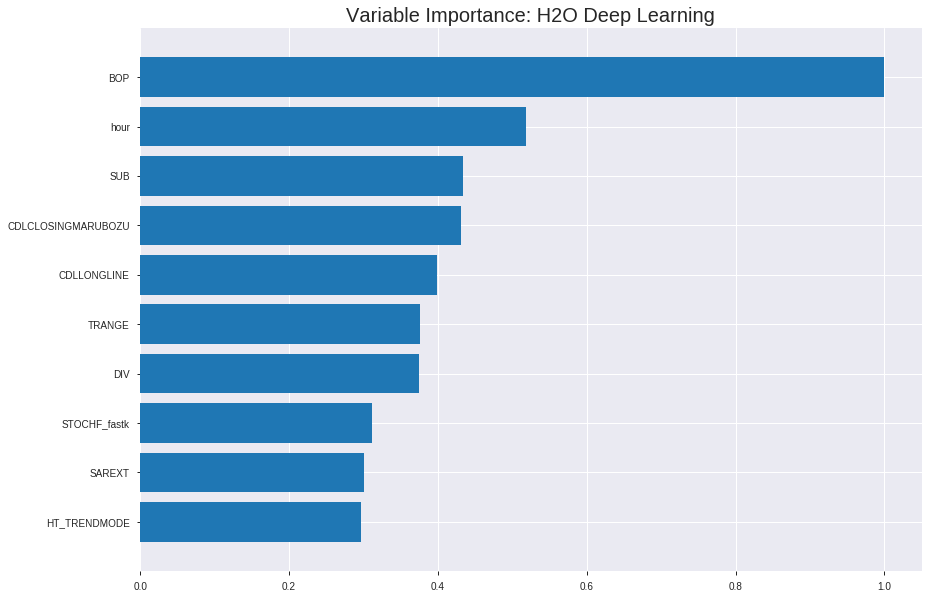

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_153641_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20627176228175115
RMSE: 0.4541715119662958
LogLoss: 0.613164317492019
Mean Per-Class Error: 0.2990085773283211
AUC: 0.773203790967332
pr_auc: 0.7539620744890974
Gini: 0.5464075819346641
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2115205436456229: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      423  385   0.4765   (385.0/808.0)
1      109  639   0.1457   (109.0/748.0)
Total  532  1024  0.3175   (494.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211521     0.721219  294
max f2                       0.0385957    0.843263  374
max f0point5                 0.500405     0.689424  175
max accuracy                 0.303933     0.698586  254
max precision                0.990627     1         0
max recall                   0.000241211  1         399
max specificity              0.990627     1         0
max absolute_mcc             0.279967     0.404597  265
max min_per_class_accuracy   0.358808     0.692513  232
max mean_per_class_accuracy  0.300537     0.700991  255

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 39.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.950596           2.08021   2.08021            1                0.967      1                           0.967               0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.930986           1.9502    2.01521            0.9375           0.940302   0.96875                     0.953651            0.0200535       0.0414439                  95.0201   101.521
    3        0.0302057                   0.911429           1.94153   1.99169            0.933333         0.920482   0.957447                    0.943065            0.0187166       0.0601604                  94.1533   99.1694
    4        0.0404884                   0.895788           2.08021   2.01418            1                0.904333   0.968254                    0.933228            0.0213904       0.0815508                  108.021   101.418
    5        0.0501285                   0.88152            1.38681   1.89353            0.666667         0.88911    0.910256                    0.924744            0.013369        0.0949198                  38.6809   89.3528
    6        0.100257                    0.822157           1.86686   1.88019            0.897436         0.851437   0.903846                    0.888091            0.0935829       0.188503                   86.6859   88.0193
    7        0.150386                    0.750118           1.49349   1.75129            0.717949         0.786077   0.84188                     0.854086            0.0748663       0.263369                   49.3487   75.1291
    8        0.200514                    0.695701           1.52016   1.69351            0.730769         0.721735   0.814103                    0.820998            0.0762032       0.339572                   52.0156   69.3507
    9        0.300129                    0.577504           1.30181   1.5635             0.625806         0.632927   0.751606                    0.758576            0.129679        0.469251                   30.1811   56.3501
    10       0.400386                    0.460738           1.18679   1.46917            0.570513         0.513069   0.70626                     0.697101            0.118984        0.588235                   18.6789   46.9172
    11       0.5                         0.352696           1.11392   1.3984             0.535484         0.405951   0.672237                    0.639096            0.110963        0.699198                   11.3921   39.8396
    12       0.600257                    0.266471           1.04011   1.33855            0.5              0.307249   0.643469                    0.583669            0.104278        0.803476                   4.0107    33.8553
    13       0.699871                    0.165075           0.805244  1.26265            0.387097         0.216441   0.606979                    0.531401            0.0802139       0.88369                    -19.4756  26.2646
    14       0.800129                    0.0822617          0.600062  1.17962            0.288462         0.120833   0.567068                    0.479956            0.0601604       0.94385                    -39.9938  17.9623
    15       0.899743                    0.0289366          0.416043  1.09508            0.2              0.0544984  0.526429                    0.432852            0.0414439       0.985294                   -58.3957  9.5084
    16       1                           5.84235e-06        0.146682  1                  0.0705128        0.0132976  0.48072                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20952198643684
RMSE: 0.45773571680265457
LogLoss: 0.6270244662028251
Mean Per-Class Error: 0.3083478617577684
AUC: 0.7402420264588246
pr_auc: 0.6788665136634108
Gini: 0.4804840529176493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3025648403125658: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      132  113  0.4612   (113.0/245.0)
1      32   167  0.1608   (32.0/199.0)
Total  164  280  0.3266   (145.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.302565     0.697286  256
max f2                       0.127887     0.825411  325
max f0point5                 0.32063      0.637293  246
max accuracy                 0.32063      0.677928  246
max precision                0.985389     1         0
max recall                   0.00117756   1         397
max specificity              0.985389     1         0
max absolute_mcc             0.317649     0.391295  250
max min_per_class_accuracy   0.440677     0.658291  196
max mean_per_class_accuracy  0.317649     0.691652  250

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 42.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.970983           2.23116   2.23116            1                0.976708   1                           0.976708            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.950399           1.67337   1.98325            0.75             0.961074   0.888889                    0.969759            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.920585           1.78492   1.91242            0.8              0.939292   0.857143                    0.958878            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.897381           1.67337   1.8593             0.75             0.908979   0.833333                    0.947789            0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.881719           1.78492   1.84313            0.8              0.886364   0.826087                    0.934436            0.0201005       0.0954774                  78.4925   84.3129
    6        0.101351                    0.804281           1.72407   1.78492            0.772727         0.846977   0.8                         0.891678            0.0854271       0.180905                   72.4075   78.4925
    7        0.150901                    0.749886           1.52124   1.69834            0.681818         0.777928   0.761194                    0.854327            0.0753769       0.256281                   52.1243   69.8342
    8        0.20045                     0.70644            1.62266   1.67963            0.727273         0.727332   0.752809                    0.822935            0.080402        0.336683                   62.2659   67.9634
    9        0.29955                     0.595346           1.01416   1.45948            0.454545         0.646165   0.654135                    0.764455            0.100503        0.437186                   1.41617   45.9478
    10       0.400901                    0.505481           1.23953   1.40387            0.555556         0.547832   0.629213                    0.709691            0.125628        0.562814                   23.9531   40.3873
    11       0.5                         0.42294            1.21699   1.36683            0.545455         0.462374   0.612613                    0.660673            0.120603        0.683417                   21.6994   36.6834
    12       0.599099                    0.330948           1.21699   1.34205            0.545455         0.377513   0.601504                    0.613835            0.120603        0.80402                    21.6994   34.2049
    13       0.70045                     0.229124           0.743719  1.25547            0.333333         0.281796   0.562701                    0.56579             0.0753769       0.879397                   -25.6281  25.5474
    14       0.79955                     0.135696           0.709913  1.18785            0.318182         0.183595   0.532394                    0.51842             0.0703518       0.949749                   -29.0087  18.7855
    15       0.898649                    0.0611412          0.25354   1.08482            0.113636         0.104047   0.486216                    0.472725            0.0251256       0.974874                   -74.646   8.48226
    16       1                           0.000328674        0.247906  1                  0.111111         0.0252782  0.448198                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 15:37:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 15:38:00  1 min 11.878 sec  365 obs/sec       0.291131  1             453        0.681336         10.4187             -0.859638      0.544931        0.295787           1.05952          0.51928                          0.704026           11.1679               -1.00412         0.527279          0.289256             1.02808            0.502252
    2019-08-27 15:38:09  1 min 21.345 sec  385 obs/sec       2.41003   8             3750       0.569569         1.54763             -0.299567      0.664544        0.559221           1.9502           0.411954                         0.565976           1.40364               -0.295219        0.680012          0.629056             1.78492            0.457207
    2019-08-27 15:38:20  1 min 32.079 sec  386 obs/sec       4.8509    16            7548       0.498841         0.738416            0.00314775     0.739883        0.721828           2.08021          0.330977                         0.471638           0.651394              0.100576         0.751154          0.69809              2.23116            0.344595
    2019-08-27 15:38:29  1 min 41.412 sec  391 obs/sec       7.00964   23            10907      0.579394         1.21455             -0.344787      0.6663          0.644604           1.82019          0.42545                          0.567094           1.03409               -0.30034         0.660148          0.579208             1.78492            0.40991
    2019-08-27 15:38:41  1 min 52.729 sec  395 obs/sec       9.72301   32            15129      0.455014         0.603028            0.170616       0.748259        0.711894           1.69017          0.341902                         0.465304           0.62753               0.124571         0.719383          0.651551             2.23116            0.367117
    2019-08-27 15:38:51  2 min  2.863 sec  397 obs/sec       12.1266   40            18869      0.490186         0.698801            0.0374395      0.685634        0.66833            1.82019          0.431877                         0.51124            0.745964              -0.0568085       0.641462          0.549553             1.33869            0.427928
    2019-08-27 15:39:01  2 min 12.385 sec  403 obs/sec       14.5591   48            22654      0.482064         0.701434            0.0690739      0.741177        0.678089           1.69017          0.339974                         0.500603           0.759324              -0.0132888       0.69077           0.590519             1.33869            0.382883
    2019-08-27 15:39:10  2 min 21.881 sec  407 obs/sec       16.9563   56            26384      0.454172         0.613164            0.173684       0.773204        0.753962           2.08021          0.317481                         0.457736           0.627024              0.152819         0.740242          0.678867             2.23116            0.326577
    2019-08-27 15:39:19 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.007544542765133856
hour                     0.518747091293335      0.518747091293335    0.003913709614551362
SUB                      0.43303096294403076    0.43303096294403076  0.003267020618558334
CDLCLOSINGMARUBOZU       0.4305766820907593     0.4305766820907593   0.0032485041917031782
CDLLONGLINE              0.39885738492012024    0.39885738492012024  0.0030091965977193024
---                      ---                    ---                  ---
EMA_24                   0.09954581409692764    0.09954581409692764  0.0007510276515443352
BBANDS_lowerband_24_2_4  0.09930994361639023    0.09930994361639023  0.000749248116616888
MINMAX_max_8             0.09910966455936432    0.09910966455936432  0.0007477371027061954
BBANDS_lowerband_8_7_4   0.09750755876302719    0.09750755876302719  0.0007356499470114611
CDLSEPARATINGLINES       0.09626718610525131    0.09626718610525131  0.0007262919024501682


See the whole table with table.as_data_frame()


('accuracy', 0.7130044843049327)

('F1', 0.7112970711297071)

('auc', 0.7543173672205931)

('logloss', 0.871096774601338)

('mean_per_class_error', 0.2865347018572826)

('rmse', 0.5257586587160334)

('mse', 0.2764221672148825)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


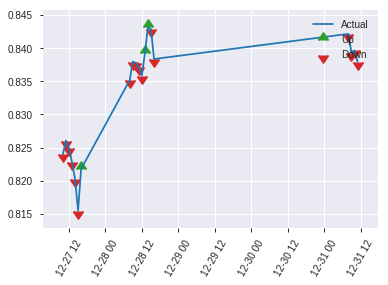


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2764221672148825
RMSE: 0.5257586587160334
LogLoss: 0.871096774601338
Mean Per-Class Error: 0.2865347018572826
AUC: 0.7543173672205931
pr_auc: 0.6783913770591995
Gini: 0.5086347344411861
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06313592434408798: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   55   0.4435   (55.0/124.0)
1      14   85   0.1414   (14.0/99.0)
Total  83   140  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0631359    0.711297  139
max f2                       0.0185063    0.817556  184
max f0point5                 0.152393     0.680346  90
max accuracy                 0.152393     0.713004  90
max precision                0.948126     1         0
max recall                   0.000445593  1         221
max specificity              0.948126     1         0
max absolute_mcc             0.0631359    0.426592  139
max min_per_class_accuracy   0.108354     0.69697   105
max mean_per_class_accuracy  0.096453     0.713465  115

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 19.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.819124           2.25253   2.25253            1                0.896849    1                           0.896849            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.789857           2.25253   2.25253            1                0.799422    1                           0.857878            0.020202        0.0505051                  125.253   125.253
    3        0.0313901                   0.719062           1.12626   1.93074            0.5              0.774708    0.857143                    0.834115            0.010101        0.0606061                  12.6263   93.0736
    4        0.0403587                   0.682175           2.25253   2.00224            1                0.694089    0.888889                    0.802998            0.020202        0.0808081                  125.253   100.224
    5        0.0538117                   0.66101            0.750842  1.68939            0.333333         0.672565    0.75                        0.77039             0.010101        0.0909091                  -24.9158  68.9394
    6        0.103139                    0.52294            1.6382    1.66491            0.727273         0.564761    0.73913                     0.672046            0.0808081       0.171717                   63.82     66.491
    7        0.152466                    0.437024           1.43343   1.59002            0.636364         0.488344    0.705882                    0.612613            0.0707071       0.242424                   43.3425   59.0018
    8        0.201794                    0.326645           1.6382    1.6018             0.727273         0.399674    0.711111                    0.560561            0.0808081       0.323232                   63.82     60.1796
    9        0.300448                    0.225768           1.43343   1.54651            0.636364         0.263832    0.686567                    0.463128            0.141414        0.464646                   43.3425   54.651
    10       0.399103                    0.154541           1.53581   1.54387            0.681818         0.194699    0.685393                    0.396775            0.151515        0.616162                   53.5813   54.3866
    11       0.502242                    0.104543           1.07729   1.44805            0.478261         0.124139    0.642857                    0.340787            0.111111        0.727273                   7.72947   44.8052
    12       0.600897                    0.0703617          1.02388   1.37841            0.454545         0.0863284   0.61194                     0.29901             0.10101         0.828283                   2.38751   37.8411
    13       0.699552                    0.0439862          0.511938  1.25622            0.227273         0.0571112   0.557692                    0.264896            0.0505051       0.878788                   -48.8062  25.6216
    14       0.798206                    0.0265126          0.511938  1.16423            0.227273         0.0347932   0.516854                    0.236457            0.0505051       0.929293                   -48.8062  16.4227
    15       0.896861                    0.00913928         0.307163  1.06995            0.136364         0.0162898   0.475                       0.212238            0.030303        0.959596                   -69.2837  6.99495
    16       1                           3.45874e-06        0.391744  1                  0.173913         0.00507205  0.443946   

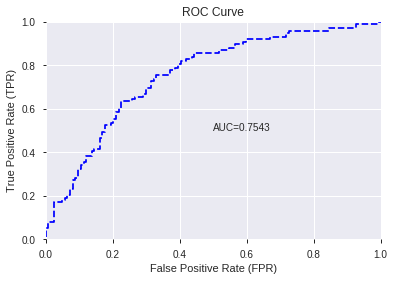

This function is available for GLM models only


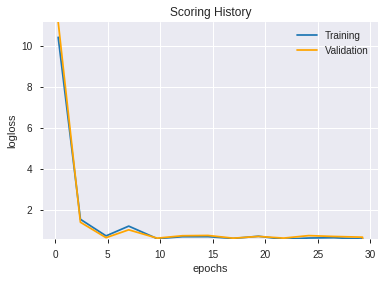

--2019-08-27 16:07:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.7MB/s    in 10s     

2019-08-27 16:07:15 (33.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_153641_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_153641_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_160731_model_8  0.773053  0.598111              0.268328  0.453647  0.205796
1  DeepLearning_grid_1_AutoML_20190827_160731_model_7  0.767595  0.704815              0.284457  0.466074  0.217225
2  DeepLearning_grid_1_AutoML_20190827_160731_model_5  0.767269  0.576164              0.307551  0.442987  0.196237
3  DeepLearning_grid_1_AutoML_20190827_160731_model_2  0.766781  0.664086              0.291504  0.463823  0.215132
4  DeepLearning_grid_1_AutoML_20190827_160731_model_6  0.765070  0.580881              0.329749  0.443374  0.196581
5  DeepLearning_grid_1_AutoML_20190827_160731_model_9  0.760508  0.583786              0.309588  0.445869  0.198800
6  DeepLearning_grid_1_AutoML_20190827_160731_model_3  0.756109  0.680141              0.284417  0.460134  0.211723
7               DeepLearning_1_AutoML_20190827_160731  0.738433  0.636221              0.273379  0.459036  0.210714
8  DeepLearning_grid_1_AutoML_20190827_160731_model_4  0.719778  0.860664              0.344860  0.512162  0.262309
9  DeepLearning_grid_1_AutoML_20190827_160731_model_1  0.712040  0.838508              0.309710  0.498875  0.248876

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.035408
1    CDLCLOSINGMARUBOZU             0.813318           0.813318    0.028798
2                   SUB             0.673874           0.673874    0.023860
3                TRANGE             0.666433           0.666433    0.023597
4                  hour             0.654375           0.654375    0.023170
5                   DIV             0.652209           0.652209    0.023093
6          HT_TRENDMODE             0.648676           0.648676    0.022968
7               WILLR_8             0.619002           0.619002    0.021917
8                ULTOSC             0.611749           0.611749    0.021661
9          CDLSHORTLINE             0.609112           0.609112    0.021567
10         weekday_name             0.605095           0.605095    0.021425
11             CORREL_8             0.594280           0.594280    0.021042
12                  day             0.584070           0.584070    0.020680
13          CDLLONGLINE             0.581921           0.581921    0.020604
14               MFI_14             0.578167           0.578167    0.020471
15               Volume             0.575115           0.575115    0.020363
16         STOCHF_fastk             0.562943           0.562943    0.019932
17           aroonup_30             0.561078           0.561078    0.019866
18       STOCHRSI_fastk             0.560818           0.560818    0.019857
19   CDLIDENTICAL3CROWS             0.554672           0.554672    0.019640
20               MFI_12             0.550304           0.550304    0.019485
21                DX_12             0.549507           0.549507    0.019457
22       STOCHRSI_fastd             0.544469           0.544469    0.019278
23       CDL3BLACKCROWS             0.542767           0.542767    0.019218
24               SAREXT             0.541015           0.541015    0.019156
25                  OBV             0.537728           0.537728    0.019040
26          CDLHIGHWAVE             0.536985           0.536985    0.019013
27              BETA_30             0.535387           0.535387    0.018957
28            dayofweek             0.534888           0.534888    0.018939
29           aroonup_12             0.531263           0.531263    0.018811
30          aroondown_8             0.531147           0.531147    0.018807
31         aroondown_12             0.530290           0.530290    0.018776
32                CCI_8             0.529911           0.529911    0.018763
33       CDLRICKSHAWMAN             0.526950           0.526950    0.018658
34         aroondown_14             0.525237           0.525237    0.018597
35         STOCHF_fastd             0.524393           0.524393    0.018567
36          STOCH_slowd             0.521798           0.521798    0.018476
37                 DX_8             0.519846           0.519846    0.018406
38          STOCH_slowk             0.514699           0.514699    0.018224
39                   AD             0.512914           0.512914    0.018161
40   CDLEVENINGDOJISTAR             0.512783           0.512783    0.018156
41          CDLPIERCING             0.509938           0.509938    0.018056
42      CDLLADDERBOTTOM             0.508519           0.508519    0.018005
43  CDLGAPSIDESIDEWHITE             0.505001           0.505001    0.017881
44           aroonup_24             0.504743           0.504743    0.017872
45               MFI_30             0.494313           0.494313    0.017502
46              weekday             0.487989           0.487989    0.017278
47    CDLSTALLEDPATTERN             0.471600           0.471600    0.016698
48      CDLUNIQUE3RIVER             0.470310           0.470310    0.016653
49       CDLEVENINGSTAR             0.428984           0.428984    0.015189

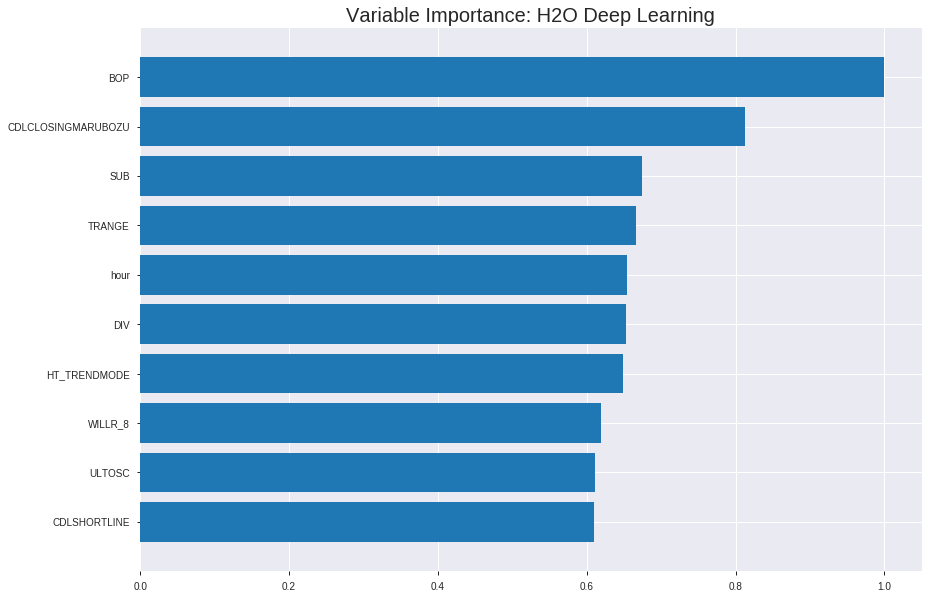

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_160731_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1895392345921049
RMSE: 0.435361039359409
LogLoss: 0.5557044880396403
Mean Per-Class Error: 0.28441189707206016
AUC: 0.7913313390162545
pr_auc: 0.76855050449409
Gini: 0.582662678032509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49567226765948524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      420  388   0.4802   (388.0/808.0)
1      93   655   0.1243   (93.0/748.0)
Total  513  1043  0.3091   (481.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495672     0.731435  204
max f2                       0.305552     0.858953  284
max f0point5                 0.55654      0.707237  158
max accuracy                 0.55654      0.716581  158
max precision                0.852387     1         0
max recall                   0.0275514    1         391
max specificity              0.852387     1         0
max absolute_mcc             0.55654      0.431859  158
max min_per_class_accuracy   0.549744     0.706683  163
max mean_per_class_accuracy  0.55654      0.715588  158

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 49.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.814079           2.08021    2.08021            1                0.835805   1                           0.835805            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.797333           2.08021    2.08021            1                0.805168   1                           0.820486            0.0213904       0.0427807                  108.021   108.021
    3        0.0302057                   0.789104           1.94153    2.03595            0.933333         0.793283   0.978723                    0.811805            0.0187166       0.0614973                  94.1533   103.595
    4        0.0404884                   0.779594           1.82019    1.98116            0.875            0.783916   0.952381                    0.804722            0.0187166       0.0802139                  82.0187   98.1156
    5        0.0501285                   0.770248           2.08021    2.00021            1                0.774761   0.961538                    0.79896             0.0200535       0.100267                   108.021   100.021
    6        0.100257                    0.721216           1.70684    1.85352            0.820513         0.746627   0.891026                    0.772793            0.0855615       0.185829                   70.6842   85.3524
    7        0.150386                    0.683253           1.76018    1.82241            0.846154         0.700476   0.876068                    0.748688            0.0882353       0.274064                   76.0181   82.241
    8        0.200514                    0.650847           1.3068     1.69351            0.628205         0.665731   0.814103                    0.727949            0.065508        0.339572                   30.6801   69.3507
    9        0.300129                    0.60297            1.36891    1.58577            0.658065         0.626564   0.762313                    0.694298            0.136364        0.475936                   36.8915   58.5773
    10       0.400386                    0.571792           1.3068     1.51592            0.628205         0.58526    0.728732                    0.666995            0.131016        0.606952                   30.6801   51.5918
    11       0.5                         0.547915           1.1005     1.43316            0.529032         0.559751   0.688946                    0.645629            0.109626        0.716578                   10.05     43.3155
    12       0.600257                    0.519062           0.893425   1.34301            0.429487         0.534253   0.64561                     0.627027            0.0895722       0.80615                    -10.6575  34.3007
    13       0.699871                    0.471354           0.899189   1.27984            0.432258         0.500462   0.615243                    0.609012            0.0895722       0.895722                   -10.0811  27.9838
    14       0.800129                    0.32775            0.720074   1.2097             0.346154         0.409388   0.581526                    0.583999            0.0721925       0.967914                   -27.9926  20.9699
    15       0.899743                    0.141554           0.254994   1.104              0.122581         0.23212    0.530714                    0.545041            0.0254011       0.993316                   -74.5006  10.3999
    16       1                           0.00348268         0.0666735  1                  0.0320513        0.0693535  0.48072   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20506263695547045
RMSE: 0.45283842256976214
LogLoss: 0.59549558307591
Mean Per-Class Error: 0.3047482309506717
AUC: 0.7464260075889652
pr_auc: 0.6852981978268103
Gini: 0.4928520151779303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46390461651863363: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  126  0.5143   (126.0/245.0)
1      23   176  0.1156   (23.0/199.0)
Total  142  302  0.3356   (149.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463905     0.702595  264
max f2                       0.251669     0.821152  325
max f0point5                 0.536259     0.649867  201
max accuracy                 0.536259     0.689189  201
max precision                0.863282     1         0
max recall                   0.0506961    1         385
max specificity              0.863282     1         0
max absolute_mcc             0.463905     0.394661  264
max min_per_class_accuracy   0.546818     0.678392  187
max mean_per_class_accuracy  0.531476     0.695252  207

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 48.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.820299           2.23116   2.23116            1                0.843214   1                           0.843214            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.788696           1.67337   1.98325            0.75             0.805318   0.888889                    0.826371            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.778444           1.78492   1.91242            0.8              0.785618   0.857143                    0.811816            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.757499           1.67337   1.8593             0.75             0.769711   0.833333                    0.80246             0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.742783           2.23116   1.94014            1                0.749277   0.869565                    0.790898            0.0251256       0.100503                   123.116   94.0135
    6        0.101351                    0.698762           1.62266   1.78492            0.727273         0.720154   0.8                         0.756312            0.080402        0.180905                   62.2659   78.4925
    7        0.150901                    0.662208           1.52124   1.69834            0.681818         0.67951    0.761194                    0.731093            0.0753769       0.256281                   52.1243   69.8342
    8        0.20045                     0.631332           1.31841   1.60443            0.590909         0.64537    0.719101                    0.709903            0.0653266       0.321608                   31.841    60.4427
    9        0.29955                     0.593538           1.2677    1.49303            0.568182         0.612591   0.669173                    0.67771             0.125628        0.447236                   26.7702   49.3029
    10       0.400901                    0.565893           1.38827   1.46655            0.622222         0.580185   0.657303                    0.653054            0.140704        0.58794                    38.8275   46.6546
    11       0.5                         0.543162           1.16629   1.40704            0.522727         0.553686   0.630631                    0.63336             0.115578        0.703518                   16.6286   40.7035
    12       0.599099                    0.503883           0.963454  1.33366            0.431818         0.524828   0.597744                    0.615407            0.0954774       0.798995                   -3.65464  33.3661
    13       0.70045                     0.446607           0.892462  1.26982            0.4              0.479554   0.569132                    0.59575             0.0904523       0.889447                   -10.7538  26.9822
    14       0.79955                     0.31327            0.557789  1.18157            0.25             0.390237   0.529577                    0.570278            0.0552764       0.944724                   -44.2211  18.157
    15       0.898649                    0.147287           0.25354   1.07923            0.113636         0.221799   0.483709                    0.531849            0.0251256       0.969849                   -74.646   7.92307
    16       1                           0.0109973          0.297487  1                  0.133333         0.0745876  0.448198                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:12:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:12:45  1 min 17.563 sec  598 obs/sec       0.592545  1             922        0.491696         0.730788            0.0315014      0.72334         0.678128           1.82019          0.347686                         0.485452           0.730111              0.0471178        0.727689          0.661784             1.78492            0.371622
    2019-08-27 16:12:54  1 min 26.978 sec  929 obs/sec       6.02378   10            9373       0.435361         0.555704            0.240714       0.791331        0.768551           2.08021          0.309126                         0.452838           0.595496              0.17085          0.746426          0.685298             2.23116            0.335586
    2019-08-27 16:13:03  1 min 35.914 sec  1035 obs/sec      12.0386   20            18732      0.427865         0.53954             0.266637       0.809591        0.786955           2.08021          0.287918                         0.458229           0.607985              0.15099          0.740673          0.675288             2.23116            0.36036
    2019-08-27 16:13:13  1 min 45.469 sec  1121 obs/sec      19.2783   32            29997      0.420075         0.521931            0.293098       0.827206        0.810851           2.08021          0.271851                         0.453966           0.636166              0.166717         0.742119          0.67487              2.23116            0.342342
    2019-08-27 16:13:22  1 min 54.682 sec  1175 obs/sec      26.5186   44            41263      0.400853         0.47747             0.35631        0.844891        0.819505           2.08021          0.253213                         0.468126           0.647316              0.11392          0.730233          0.648841             2.23116            0.326577
    2019-08-27 16:13:31  2 min  3.927 sec  1207 obs/sec      33.7256   56            52477      0.39784          0.47266             0.365952       0.863179        0.847582           2.08021          0.246787                         0.471759           0.637388              0.100114         0.709014          0.636013             2.23116            0.353604
    2019-08-27 16:13:40  2 min 12.903 sec  1237 obs/sec      41.0084   68            63809      0.382075         0.439321            0.415207       0.884169        0.867788           2.08021          0.223008                         0.473513           0.660386              0.09341          0.707138          0.630935             2.23116            0.380631
    2019-08-27 16:13:41  2 min 13.822 sec  1236 obs/sec      41.0084   68            63809      0.435361         0.555704            0.240714       0.791331        0.768551           2.08021          0.309126                         0.452838           0.595496              0.17085          0.746426          0.685298             2.23116            0.335586

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.035407521833029525
CDLCLOSINGMARUBOZU  0.8133176565170288     0.8133176565170288   0.028797562680315105
SUB                 0.6738736033439636     0.6738736033439636   0.02386019432310367
TRANGE              0.6664327383041382     0.6664327383041382   0.023596731731749424
hour                0.654374897480011      0.654374897480011    0.023169793469509946
---                 ---                    ---                  ---
MFI_30              0.4943125247955322     0.4943125247955322   0.017502381514037754
weekday             0.487989217042923      0.487989217042923    0.01727848885673028
CDLSTALLEDPATTERN   0.47160032391548157    0.47160032391548157  0.01669819876550121
CDLUNIQUE3RIVER     0.47031018137931824    0.47031018137931824  0.016652518015484286
CDLEVENINGSTAR      0.42898431420326233    0.42898431420326233  0.01518927147117921


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.7232142857142857)

('auc', 0.7730531117627891)

('logloss', 0.5981111193572708)

('mean_per_class_error', 0.26832844574780057)

('rmse', 0.4536469965596298)

('mse', 0.20579559748757278)

deeplearning prediction progress: |███████████████████████████████████████| 100%


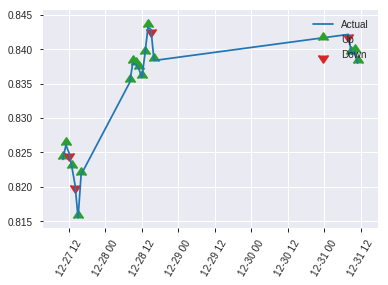


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20579559748757278
RMSE: 0.4536469965596298
LogLoss: 0.5981111193572708
Mean Per-Class Error: 0.26832844574780057
AUC: 0.7730531117627891
pr_auc: 0.7026695709380074
Gini: 0.5461062235255782
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5304444048262665: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   44   0.3548   (44.0/124.0)
1      18   81   0.1818   (18.0/99.0)
Total  98   125  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.530444     0.723214  124
max f2                       0.343834     0.811518  176
max f0point5                 0.575047     0.688488  85
max accuracy                 0.546794     0.721973  112
max precision                0.688538     0.896552  28
max recall                   0.0962895    1         213
max specificity              0.836553     0.991935  0
max absolute_mcc             0.530444     0.463835  124
max min_per_class_accuracy   0.554232     0.701613  106
max mean_per_class_accuracy  0.530444     0.731672  124

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 50.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.817161           1.50168   1.50168            0.666667         0.828712  0.666667                    0.828712            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.805967           2.25253   1.80202            1                0.808997  0.8                         0.820826            0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.800347           1.12626   1.60895            0.5              0.803322  0.714286                    0.815825            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.783379           2.25253   1.75196            1                0.794735  0.777778                    0.811138            0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.774127           2.25253   1.8771             1                0.779972  0.833333                    0.803347            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.70468            2.04775   1.95872            0.909091         0.729685  0.869565                    0.768117            0.10101         0.20202                    104.775   95.8718
    7        0.152466                    0.671165           1.6382    1.85502            0.727273         0.687193  0.823529                    0.741936            0.0808081       0.282828                   63.82     85.5021
    8        0.201794                    0.63474            1.6382    1.80202            0.727273         0.647484  0.8                         0.718848            0.0808081       0.363636                   63.82     80.202
    9        0.300448                    0.598267           1.12626   1.58013            0.5              0.616882  0.701493                    0.685367            0.111111        0.474747                   12.6263   58.013
    10       0.399103                    0.568181           1.53581   1.56917            0.681818         0.583682  0.696629                    0.660231            0.151515        0.626263                   53.5813   56.9175
    11       0.502242                    0.549368           1.17523   1.48828            0.521739         0.559112  0.660714                    0.639466            0.121212        0.747475                   17.5231   48.8276
    12       0.600897                    0.524313           0.8191    1.37841            0.363636         0.534584  0.61194                     0.622246            0.0808081       0.828283                   -18.09    37.8411
    13       0.699552                    0.471036           0.716713  1.28509            0.318182         0.503223  0.570513                    0.605461            0.0707071       0.89899                    -28.3287  28.5095
    14       0.798206                    0.331263           0.40955   1.17688            0.181818         0.419328  0.522472                    0.582456            0.040404        0.939394                   -59.045   17.6881
    15       0.896861                    0.191883           0.204775  1.06995            0.0909091        0.254128  0.475                       0.54634             0.020202        0.959596                   -79.5225  6.99495
    16       1                           0.031924           0.391744  1                  0.173913         0.109449  0.443946                    0.501279            

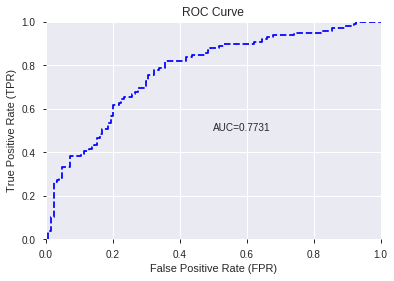

This function is available for GLM models only


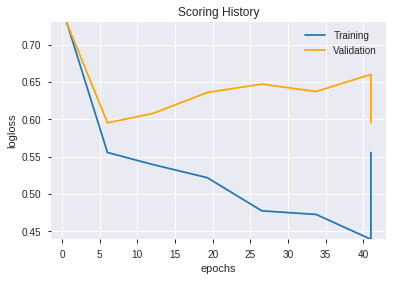

--2019-08-27 16:14:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_160731_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_160731_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'TRANGE',
 'hour',
 'DIV',
 'HT_TRENDMODE',
 'WILLR_8',
 'ULTOSC',
 'CDLSHORTLINE',
 'weekday_name',
 'CORREL_8',
 'day',
 'CDLLONGLINE',
 'MFI_14',
 'Volume',
 'STOCHF_fastk',
 'aroonup_30',
 'STOCHRSI_fastk',
 'CDLIDENTICAL3CROWS',
 'MFI_12',
 'DX_12',
 'STOCHRSI_fastd',
 'CDL3BLACKCROWS',
 'SAREXT',
 'OBV',
 'CDLHIGHWAVE',
 'BETA_30',
 'dayofweek',
 'aroonup_12',
 'aroondown_8',
 'aroondown_12',
 'CCI_8',
 'CDLRICKSHAWMAN',
 'aroondown_14',
 'STOCHF_fastd',
 'STOCH_slowd',
 'DX_8',
 'STOCH_slowk',
 'AD',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'aroonup_24',
 'MFI_30',
 'weekday',
 'CDLSTALLEDPATTERN',
 'CDLUNIQUE3RIVER',
 'CDLEVENINGSTAR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_161511_model_1  0.76564  0.584976              0.286453  0.445851  0.198783

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.446101           1.000000    0.123059
1    CDLCLOSINGMARUBOZU             0.233127           0.522588    0.064309
2                  hour             0.158212           0.354656    0.043644
3                ULTOSC             0.146962           0.329437    0.040540
4          STOCHF_fastk             0.141011           0.316096    0.038899
5                   OBV             0.137879           0.309077    0.038035
6                Volume             0.136445           0.305861    0.037639
7               WILLR_8             0.133900           0.300157    0.036937
8                   SUB             0.129479           0.290247    0.035718
9           CDLLONGLINE             0.127236           0.285217    0.035099
10               MFI_14             0.122019           0.273524    0.033660
11               TRANGE             0.117007           0.262289    0.032277
12                CCI_8             0.101789           0.228175    0.028079
13              BETA_30             0.095713           0.214555    0.026403
14          CDLHIGHWAVE             0.086161           0.193143    0.023768
15                  DIV             0.081632           0.182989    0.022518
16       STOCHRSI_fastk             0.077754           0.174296    0.021449
17                DX_12             0.076815           0.172192    0.021190
18         STOCHF_fastd             0.076336           0.171119    0.021058
19          STOCH_slowk             0.075680           0.169649    0.020877
20      CDLLADDERBOTTOM             0.072348           0.162179    0.019958
21         HT_TRENDMODE             0.063116           0.141484    0.017411
22          STOCH_slowd             0.058235           0.130542    0.016064
23   CDLIDENTICAL3CROWS             0.052187           0.116985    0.014396
24       CDLRICKSHAWMAN             0.050824           0.113931    0.014020
25         CDLSHORTLINE             0.049835           0.111712    0.013747
26         aroondown_12             0.048431           0.108566    0.013360
27               MFI_12             0.042758           0.095848    0.011795
28          CDLPIERCING             0.041985           0.094116    0.011582
29  CDLGAPSIDESIDEWHITE             0.039045           0.087524    0.010771
30               SAREXT             0.036673           0.082208    0.010116
31         aroondown_14             0.035876           0.080421    0.009897
32    CDLSTALLEDPATTERN             0.035233           0.078979    0.009719
33      CDLUNIQUE3RIVER             0.035113           0.078710    0.009686
34         weekday_name             0.028224           0.063268    0.007786
35           aroonup_30             0.027996           0.062758    0.007723
36             CORREL_8             0.027439           0.061508    0.007569
37   CDLEVENINGDOJISTAR             0.025381           0.056896    0.007002
38       STOCHRSI_fastd             0.021372           0.047907    0.005895
39                 DX_8             0.020605           0.046190    0.005684
40           aroonup_24             0.018516           0.041506    0.005108
41            dayofweek             0.016659           0.037343    0.004595
42              weekday             0.016565           0.037134    0.004570
43               MFI_30             0.014182           0.031790    0.003912
44          aroondown_8             0.011295           0.025319    0.003116
45                  day             0.010150           0.022753    0.002800
46       CDL3BLACKCROWS             0.010107           0.022656    0.002788
47       CDLEVENINGSTAR             0.009380           0.021026    0.002587
48                   AD             0.003445           0.007722    0.000950
49           aroonup_12             0.000856           0.001919    0.000236

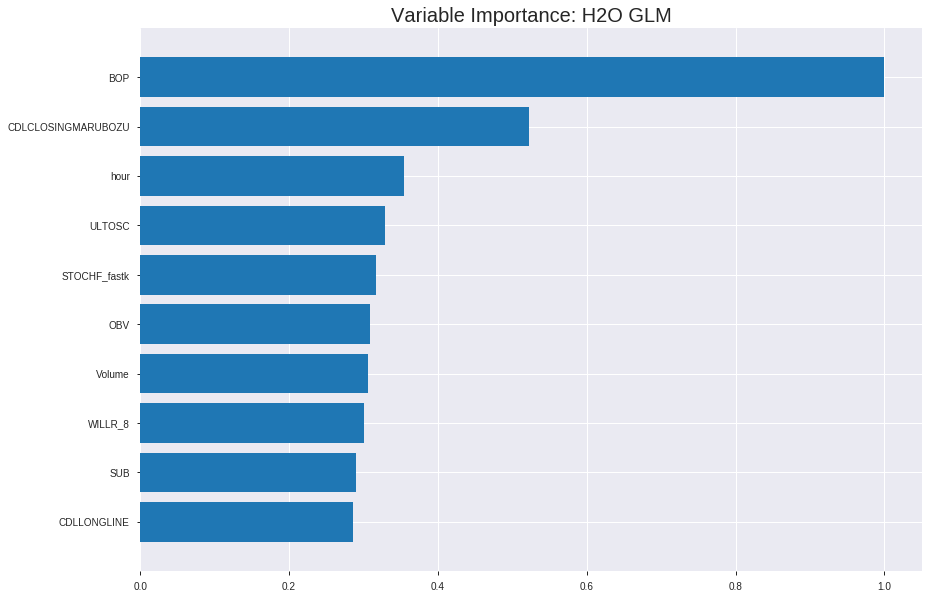

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_161511_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19237553431030505
RMSE: 0.4386063546168763
LogLoss: 0.565638343713596
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2154.759827525797
Residual deviance: 1760.2665256367106
AIC: 1862.2665256367106
AUC: 0.7780177833959866
pr_auc: 0.752231487496342
Gini: 0.5560355667919732
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42315921404918927: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      467  341  0.422    (341.0/808.0)
1      123  625  0.1644   (123.0/748.0)
Total  590  966  0.2982   (464.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423159     0.729288  236
max f2                       0.250033     0.8461    318
max f0point5                 0.578635     0.689891  148
max accuracy                 0.440606     0.707584  227
max precision                0.948309     1         0
max recall                   0.0428665    1         396
max specificity              0.948309     1         0
max absolute_mcc             0.440606     0.430206  227
max min_per_class_accuracy   0.497697     0.68984   196
max mean_per_class_accuracy  0.440606     0.711491  227

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.881961           2.08021   2.08021            1                0.904224  1                           0.904224            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.862119           1.69017   1.88519            0.8125           0.871485  0.90625                     0.887854            0.0173797       0.0387701                  69.0174   88.5194
    3        0.0302057                   0.845023           1.94153   1.90317            0.933333         0.855693  0.914894                    0.87759             0.0187166       0.0574866                  94.1533   90.3174
    4        0.0404884                   0.824256           1.9502    1.91512            0.9375           0.83324   0.920635                    0.866327            0.0200535       0.0775401                  95.0201   91.5118
    5        0.0501285                   0.808393           2.08021   1.94687            1                0.818822  0.935897                    0.857191            0.0200535       0.0975936                  108.021   94.6867
    6        0.100257                    0.748989           1.76018   1.85352            0.846154         0.775998  0.891026                    0.816595            0.0882353       0.185829                   76.0181   85.3524
    7        0.150386                    0.703688           1.60016   1.76907            0.769231         0.722711  0.850427                    0.7853              0.0802139       0.266043                   60.0165   76.9071
    8        0.200514                    0.660376           1.33347   1.66017            0.641026         0.682561  0.798077                    0.759615            0.0668449       0.332888                   33.347    66.0171
    9        0.300129                    0.605277           1.4226    1.58132            0.683871         0.633146  0.760171                    0.717639            0.141711        0.474599                   42.2598   58.1319
    10       0.400386                    0.552654           1.20012   1.48587            0.576923         0.577569  0.714286                    0.682565            0.120321        0.59492                    20.0123   48.5867
    11       0.5                         0.493177           1.04682   1.3984             0.503226         0.522284  0.672237                    0.650633            0.104278        0.699198                   4.68173   39.8396
    12       0.600257                    0.436556           1.20012   1.36528            0.576923         0.465082  0.656317                    0.619641            0.120321        0.819519                   20.0123   36.528
    13       0.699871                    0.361855           0.671037  1.26647            0.322581         0.398965  0.608815                    0.588232            0.0668449       0.886364                   -32.8963  26.6466
    14       0.800129                    0.291109           0.666735  1.19132            0.320513         0.327816  0.572691                    0.555601            0.0668449       0.953209                   -33.3265  19.1319
    15       0.899743                    0.182104           0.348939  1.09806            0.167742         0.240725  0.527857                    0.52074             0.0347594       0.987968                   -65.1061  9.80558
    16       1                           0.0262858          0.120012  1                  0.0576923        0.121563  0.48072                     0.48072           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20429352458918734
RMSE: 0.4519884120076391
LogLoss: 0.5950907602836327
Null degrees of freedom: 443
Residual degrees of freedom: 393
Null deviance: 612.6260558984648
Residual deviance: 528.4405951318658
AIC: 630.4405951318658
AUC: 0.7426930571223465
pr_auc: 0.6860321013459355
Gini: 0.4853861142446929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4394499986088758: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  93   0.3796   (93.0/245.0)
1      41   158  0.206    (41.0/199.0)
Total  193  251  0.3018   (134.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43945      0.702222  223
max f2                       0.302461     0.821678  309
max f0point5                 0.43945      0.656692  223
max accuracy                 0.43945      0.698198  223
max precision                0.913422     1         0
max recall                   0.0690253    1         394
max specificity              0.913422     1         0
max absolute_mcc             0.43945      0.41571   223
max min_per_class_accuracy   0.501909     0.663317  183
max mean_per_class_accuracy  0.43945      0.707189  223

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 47.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.885703           2.23116   2.23116            1                0.901266  1                           0.901266            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.869298           1.67337   1.98325            0.75             0.879304  0.888889                    0.891505            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.840681           1.78492   1.91242            0.8              0.86013   0.857143                    0.8803              0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.808774           2.23116   1.98325            1                0.820293  0.888889                    0.866965            0.0201005       0.080402                   123.116   98.325
    5        0.0518018                   0.791486           1.78492   1.94014            0.8              0.800092  0.869565                    0.852427            0.0201005       0.100503                   78.4925   94.0135
    6        0.101351                    0.72663            1.82549   1.88409            0.818182         0.752322  0.844444                    0.803487            0.0904523       0.190955                   82.5491   88.4087
    7        0.150901                    0.68743            1.31841   1.69834            0.590909         0.705757  0.761194                    0.771396            0.0653266       0.256281                   31.841    69.8342
    8        0.20045                     0.658944           1.21699   1.57936            0.545455         0.670547  0.707865                    0.746467            0.0603015       0.316583                   21.6994   57.9357
    9        0.29955                     0.597413           1.21699   1.45948            0.545455         0.628378  0.654135                    0.7074              0.120603        0.437186                   21.6994   45.9478
    10       0.400901                    0.542346           1.33869   1.42894            0.6              0.567497  0.640449                    0.672031            0.135678        0.572864                   33.8693   42.8942
    11       0.5                         0.483613           1.11558   1.36683            0.5              0.512998  0.612613                    0.640511            0.110553        0.683417                   11.5578   36.6834
    12       0.599099                    0.414605           1.2677    1.35044            0.568182         0.452983  0.605263                    0.609492            0.125628        0.809045                   26.7702   35.0436
    13       0.70045                     0.355385           0.7933    1.26982            0.355556         0.384031  0.569132                    0.576869            0.080402        0.889447                   -20.67    26.9822
    14       0.79955                     0.284811           0.557789  1.18157            0.25             0.321785  0.529577                    0.545253            0.0552764       0.944724                   -44.2211  18.157
    15       0.898649                    0.201641           0.304249  1.08482            0.136364         0.245028  0.486216                    0.512145            0.0301508       0.974874                   -69.5751  8.48226
    16       1                           0.0307419          0.247906  1                  0.111111         0.129293  0.448198                    0.473343            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:15:12  0.000 sec   2            20        51            1.3697            1.3654
    2019-08-27 16:15:12  0.093 sec   4            12        51            1.36156           1.35773
    2019-08-27 16:15:12  0.148 sec   6            7.7       51            1.34981           1.34677
    2019-08-27 16:15:12  0.227 sec   8            4.8       51            1.33363           1.3319
    2019-08-27 16:15:12  0.251 sec   10           3         51            1.3126            1.31299
    2019-08-27 16:15:12  0.277 sec   12           1.9       51            1.28708           1.2907
    2019-08-27 16:15:12  0.317 sec   14           1.2       51            1.25852           1.26674
    2019-08-27 16:15:12  0.350 sec   16           0.71      51            1.22918           1.24346
    2019-08-27 16:15:12  0.381 sec   18           0.44      51            1.20158           1.22329
    2019-08-27 16:15:12  0.411 sec   20           0.28      51            1.1776            1.20779
    2019-08-27 16:15:12  0.432 sec   22           0.17      51            1.15806           1.19749
    2019-08-27 16:15:12  0.451 sec   24           0.11      51            1.14284           1.19191
    2019-08-27 16:15:12  0.474 sec   26           0.066     51            1.13128           1.19018
    2019-08-27 16:15:12  0.495 sec   28           0.041     51            1.12265           1.19126
    2019-08-27 16:15:12  0.524 sec   30           0.025     51            1.11631           1.19411
    2019-08-27 16:15:12  0.565 sec   32           0.016     51            1.11169           1.19784
    2019-08-27 16:15:12  0.588 sec   34           0.0098    51            1.10836           1.20181
    2019-08-27 16:15:12  0.617 sec   36           0.0061    51            1.10597           1.20569

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7124463519313305)

('auc', 0.7656402737047898)

('logloss', 0.5849757017666886)

('mean_per_class_error', 0.27847018572825033)

('rmse', 0.44585112313160746)

('mse', 0.1987832239977158)

glm prediction progress: |████████████████████████████████████████████████| 100%


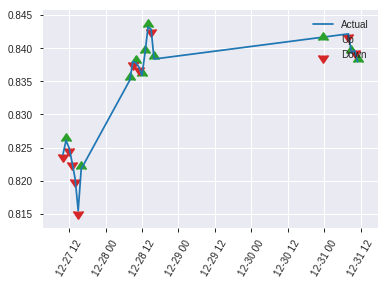


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1987832239977158
RMSE: 0.44585112313160746
LogLoss: 0.5849757017666886
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 307.54649216112034
Residual deviance: 260.8991629879431
AIC: 362.8991629879431
AUC: 0.7656402737047898
pr_auc: 0.6844605751611212
Gini: 0.5312805474095796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4073490724927064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   51   0.4113   (51.0/124.0)
1      16   83   0.1616   (16.0/99.0)
Total  89   134  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407349     0.712446  133
max f2                       0.271024     0.824561  173
max f0point5                 0.554057     0.689223  74
max accuracy                 0.466267     0.717489  109
max precision                0.913677     1         0
max recall                   0.0812239    1         220
max specificity              0.913677     1         0
max absolute_mcc             0.45218      0.440377  113
max min_per_class_accuracy   0.470376     0.701613  106
max mean_per_class_accuracy  0.45218      0.72153   113

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.886672           2.25253   2.25253            1                0.904572  1                           0.904572            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.845691           1.12626   1.80202            0.5              0.849338  0.8                         0.882478            0.010101        0.040404                   12.6263   80.202
    3        0.0313901                   0.801578           1.12626   1.60895            0.5              0.823952  0.714286                    0.865757            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.792261           2.25253   1.75196            1                0.797101  0.777778                    0.8505              0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.787236           1.50168   1.68939            0.666667         0.790542  0.75                        0.83551             0.020202        0.0909091                  50.1684   68.9394
    6        0.103139                    0.704452           1.84298   1.76285            0.818182         0.730405  0.782609                    0.785243            0.0909091       0.181818                   84.2975   76.2846
    7        0.152466                    0.650129           1.6382    1.72252            0.727273         0.677427  0.764706                    0.750361            0.0808081       0.262626                   63.82     72.2519
    8        0.201794                    0.617949           1.02388   1.55174            0.454545         0.636654  0.688889                    0.722566            0.0505051       0.313131                   2.38751   55.174
    9        0.300448                    0.573516           1.94536   1.68099            0.863636         0.592383  0.746269                    0.679819            0.191919        0.505051                   94.5363   68.0989
    10       0.399103                    0.520389           1.12626   1.54387            0.5              0.545274  0.685393                    0.646561            0.111111        0.616162                   12.6263   54.3866
    11       0.502242                    0.464533           1.17523   1.46816            0.521739         0.491382  0.651786                    0.614694            0.121212        0.737374                   17.5231   46.8164
    12       0.600897                    0.406812           1.02388   1.39522            0.454545         0.429733  0.619403                    0.584327            0.10101         0.838384                   2.38751   39.5221
    13       0.699552                    0.338927           0.511938  1.27066            0.227273         0.380409  0.564103                    0.555569            0.0505051       0.888889                   -48.8062  27.0655
    14       0.798206                    0.25054            0.614325  1.18954            0.272727         0.301799  0.52809                     0.524205            0.0606061       0.949495                   -38.5675  18.9536
    15       0.896861                    0.16767            0.102388  1.06995            0.0454545        0.220233  0.475                       0.490768            0.010101        0.959596                   -89.7612  6.99495
    16       1                           0.00876944         0.391744  1                  0.173913         0.115868  0.443946                    0.452101           

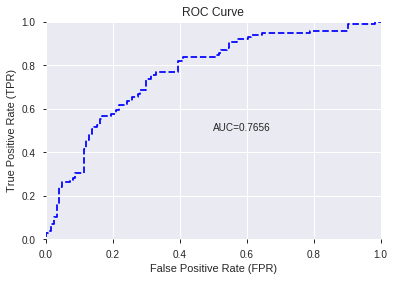

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


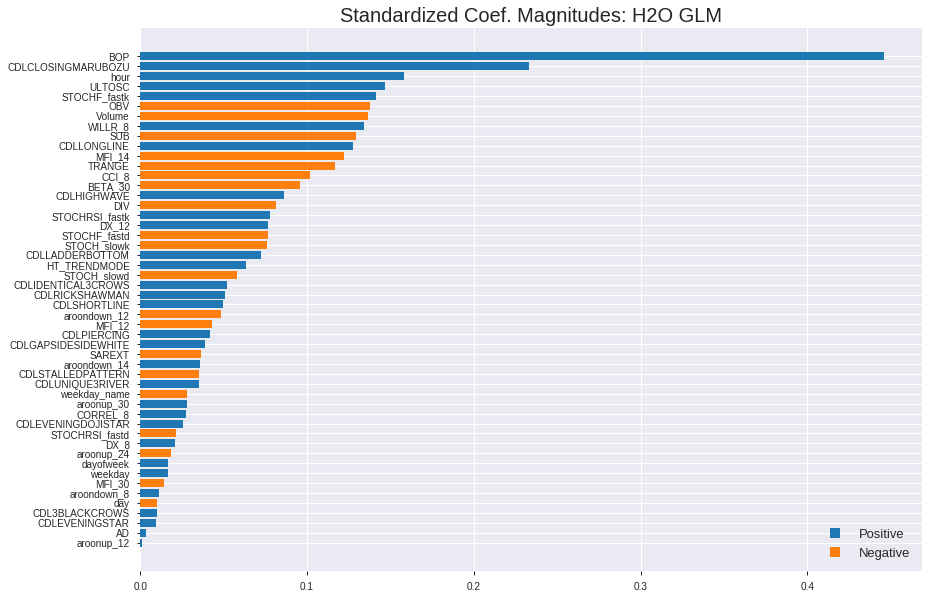

'log_likelihood'
--2019-08-27 16:15:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_161511_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_161511_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'ULTOSC',
 'STOCHF_fastk',
 'OBV',
 'Volume',
 'WILLR_8',
 'SUB',
 'CDLLONGLINE',
 'MFI_14',
 'TRANGE',
 'CCI_8',
 'BETA_30',
 'CDLHIGHWAVE',
 'DIV',
 'STOCHRSI_fastk',
 'DX_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLLADDERBOTTOM',
 'HT_TRENDMODE',
 'STOCH_slowd',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'aroondown_12',
 'MFI_12',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'SAREXT',
 'aroondown_14',
 'CDLSTALLEDPATTERN',
 'CDLUNIQUE3RIVER',
 'weekday_name',
 'aroonup_30',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastd',
 'DX_8',
 'aroonup_24',
 'dayofweek',
 'weekday',
 'MFI_30',
 'aroondown_8',
 'day',
 'CDL3BLACKCROWS',
 'CDLEVENINGSTAR',
 'AD',
 'aroonup_12']

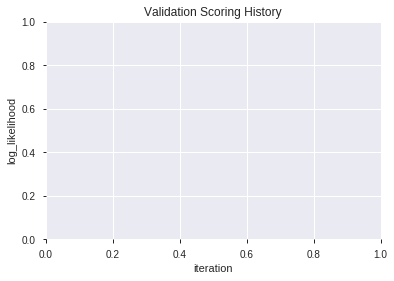

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_161537_model_4  0.781240  0.560085              0.254154  0.435478  0.189641
1               XGBoost_2_AutoML_20190827_161537  0.769632  0.568890              0.247149  0.438936  0.192664
2  XGBoost_grid_1_AutoML_20190827_161537_model_6  0.766129  0.565388              0.255173  0.438757  0.192508
3               XGBoost_1_AutoML_20190827_161537  0.763115  0.570047              0.256150  0.441428  0.194859
4  XGBoost_grid_1_AutoML_20190827_161537_model_3  0.762219  0.573769              0.268288  0.442780  0.196054
5  XGBoost_grid_1_AutoML_20190827_161537_model_2  0.758635  0.587448              0.260223  0.448676  0.201311
6  XGBoost_grid_1_AutoML_20190827_161537_model_7  0.758553  0.577975              0.260182  0.445063  0.198081
7               XGBoost_3_AutoML_20190827_161537  0.757250  0.572920              0.255213  0.442843  0.196110
8  XGBoost_grid_1_AutoML_20190827_161537_model_1  0.745031  0.575886              0.289427  0.445531  0.198497
9  XGBoost_grid_1_AutoML_20190827_161537_model_5  0.736070  0.605595              0.308610  0.456843  0.208706

variable  relative_importance  scaled_importance  percentage
0              BOP          2025.784912           1.000000    0.430862
1              DIV           347.190033           0.171385    0.073844
2           TRANGE           316.381989           0.156177    0.067291
3             hour           201.312042           0.099375    0.042817
4            CCI_8           141.003479           0.069604    0.029990
5              OBV           124.670517           0.061542    0.026516
6           MFI_12           119.067848           0.058776    0.025324
7           Volume           106.982132           0.052810    0.022754
8          BETA_30           104.284821           0.051479    0.022180
9           MFI_14            98.433273           0.048590    0.020936
10          ULTOSC            90.828270           0.044836    0.019318
11             SUB            90.471161           0.044660    0.019242
12    STOCHF_fastk            90.366539           0.044608    0.019220
13           DX_12            82.189468           0.040572    0.017481
14         WILLR_8            72.025467           0.035554    0.015319
15  STOCHRSI_fastd            69.832977           0.034472    0.014853
16     STOCH_slowd            64.724266           0.031950    0.013766
17      aroonup_30            60.730423           0.029979    0.012917
18            DX_8            59.414108           0.029329    0.012637
19     STOCH_slowk            49.038719           0.024207    0.010430
20        CORREL_8            45.270714           0.022347    0.009629
21              AD            39.969254           0.019730    0.008501
22  STOCHRSI_fastk            36.157669           0.017849    0.007690
23          SAREXT            34.608341           0.017084    0.007361
24      aroonup_12            31.496977           0.015548    0.006699
25             day            29.311165           0.014469    0.006234
26          MFI_30            26.303879           0.012985    0.005595
27    weekday_name            24.144022           0.011918    0.005135
28       dayofweek            23.991123           0.011843    0.005103
29    HT_TRENDMODE            23.490681           0.011596    0.004996
30    aroondown_14            22.613626           0.011163    0.004810
31     aroondown_8            21.945757           0.010833    0.004668
32      aroonup_24            17.735184           0.008755    0.003772
33     CDLLONGLINE             9.927845           0.004901    0.002112

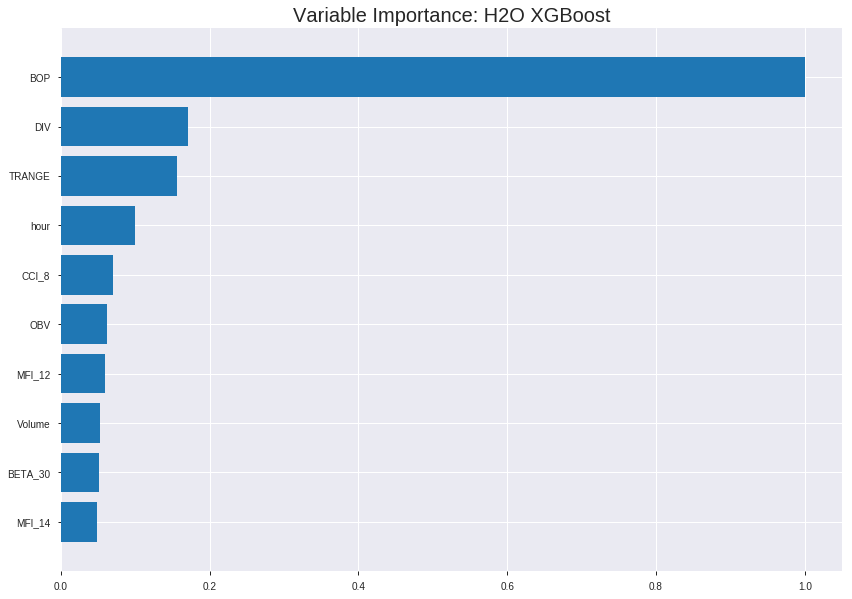

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_161537_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1738817971622329
RMSE: 0.4169913634144392
LogLoss: 0.5246630896191686
Mean Per-Class Error: 0.2523991369725208
AUC: 0.830799624080055
pr_auc: 0.8106010452607723
Gini: 0.6615992481601101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3922236959139506: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      441  367   0.4542   (367.0/808.0)
1      68   680   0.0909   (68.0/748.0)
Total  509  1047  0.2796   (435.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392224     0.75766   252
max f2                       0.273132     0.85867   306
max f0point5                 0.598705     0.755     136
max accuracy                 0.528592     0.747429  179
max precision                0.850265     1         0
max recall                   0.131041     1         376
max specificity              0.850265     1         0
max absolute_mcc             0.501661     0.494966  192
max min_per_class_accuracy   0.517337     0.74505   185
max mean_per_class_accuracy  0.501661     0.747601  192

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.812115           1.9502     1.9502             0.9375           0.83111   0.9375                      0.83111             0.0200535       0.0200535                  95.0201   95.0201
    2        0.0205656                   0.799965           2.08021    2.01521            1                0.804199  0.96875                     0.817655            0.0213904       0.0414439                  108.021   101.521
    3        0.0302057                   0.789244           2.08021    2.03595            1                0.79308   0.978723                    0.809812            0.0200535       0.0614973                  108.021   103.595
    4        0.0404884                   0.780775           1.9502     2.01418            0.9375           0.785151  0.968254                    0.803549            0.0200535       0.0815508                  95.0201   101.418
    5        0.0501285                   0.768203           2.08021    2.02688            1                0.773558  0.974359                    0.797781            0.0200535       0.101604                   108.021   102.688
    6        0.100257                    0.747241           1.86686    1.94687            0.897436         0.758232  0.935897                    0.778007            0.0935829       0.195187                   86.6859   94.6867
    7        0.150386                    0.718148           1.60016    1.8313             0.769231         0.732526  0.880342                    0.762846            0.0802139       0.275401                   60.0165   83.1299
    8        0.200514                    0.691982           1.78685    1.82019            0.858974         0.706651  0.875                       0.748797            0.0895722       0.364973                   78.685    82.0187
    9        0.300129                    0.630738           1.54338    1.72831            0.741935         0.66227   0.830835                    0.720079            0.153743        0.518717                   54.3385   72.8315
    10       0.400386                    0.574186           1.22679    1.60273            0.589744         0.602867  0.770465                    0.690729            0.122995        0.641711                   22.6793   60.2733
    11       0.5                         0.510313           1.12734    1.50802            0.541935         0.542194  0.724936                    0.661136            0.112299        0.754011                   12.7342   50.8021
    12       0.600257                    0.444221           0.866756   1.40091            0.416667         0.476057  0.673448                    0.630224            0.0868984       0.840909                   -13.3244  40.0915
    13       0.699871                    0.36119            0.818665   1.31804            0.393548         0.406991  0.633609                    0.59845             0.0815508       0.92246                    -18.1335  31.8042
    14       0.800129                    0.252126           0.466715   1.21137            0.224359         0.311893  0.582329                    0.562544            0.0467914       0.969251                   -53.3285  21.137
    15       0.899743                    0.155753           0.254994   1.10549            0.122581         0.196145  0.531429                    0.521979            0.0254011       0.994652                   -74.5006  10.5485
    16       1                           0.0769123          0.0533388  1                  0.025641         0.12518   0.48072                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20314479949701933
RMSE: 0.4507158744675179
LogLoss: 0.5910089384124473
Mean Per-Class Error: 0.30301507537688444
AUC: 0.7442108501692134
pr_auc: 0.678993341971444
Gini: 0.4884217003384268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3966448903083801: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  115  0.4694   (115.0/245.0)
1      30   169  0.1508   (30.0/199.0)
Total  160  284  0.3266   (145.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396645     0.699793  254
max f2                       0.142879     0.820957  373
max f0point5                 0.529378     0.658561  176
max accuracy                 0.529378     0.693694  176
max precision                0.826686     1         0
max recall                   0.142879     1         373
max specificity              0.826686     1         0
max absolute_mcc             0.440591     0.396528  229
max min_per_class_accuracy   0.50839      0.681633  192
max mean_per_class_accuracy  0.440591     0.696985  229

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 46.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.795732           1.78492   1.78492            0.8              0.814698  0.8                         0.814698            0.0201005       0.0201005                  78.4925   78.4925
    2        0.0202703                   0.786914           2.23116   1.98325            1                0.791951  0.888889                    0.804588            0.0201005       0.040201                   123.116   98.325
    3        0.0315315                   0.778509           1.78492   1.91242            0.8              0.7841    0.857143                    0.797271            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.769896           1.67337   1.8593             0.75             0.775934  0.833333                    0.79253             0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.758239           1.33869   1.74612            0.6              0.763231  0.782609                    0.78616             0.0150754       0.0904523                  33.8693   74.6122
    6        0.101351                    0.726942           1.92691   1.83451            0.863636         0.742259  0.822222                    0.764697            0.0954774       0.18593                    92.6907   83.4506
    7        0.150901                    0.688008           1.41983   1.69834            0.636364         0.708852  0.761194                    0.74636             0.0703518       0.256281                   41.9826   69.8342
    8        0.20045                     0.666419           1.31841   1.60443            0.590909         0.676958  0.719101                    0.729204            0.0653266       0.321608                   31.841    60.4427
    9        0.29955                     0.620173           1.21699   1.47625            0.545455         0.642529  0.661654                    0.70053             0.120603        0.442211                   21.6994   47.6253
    10       0.400901                    0.554687           1.48744   1.47908            0.666667         0.584311  0.662921                    0.671149            0.150754        0.592965                   48.7437   47.9081
    11       0.5                         0.494537           1.06487   1.39698            0.477273         0.526907  0.626126                    0.64256             0.105528        0.698492                   6.48698   39.6985
    12       0.599099                    0.424953           1.06487   1.34205            0.477273         0.459133  0.601504                    0.612219            0.105528        0.80402                    6.48698   34.2049
    13       0.70045                     0.318154           0.694137  1.2483             0.311111         0.378604  0.559486                    0.578416            0.0703518       0.874372                   -30.5863  24.8299
    14       0.79955                     0.203414           0.557789  1.16271            0.25             0.253394  0.521127                    0.538132            0.0552764       0.929648                   -44.2211  16.2715
    15       0.898649                    0.160833           0.456373  1.08482            0.204545         0.183203  0.486216                    0.498992            0.0452261       0.974874                   -54.3627  8.48226
    16       1                           0.0960377          0.247906  1                  0.111111         0.134384  0.448198                    0.462038          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:15:49  4.639 sec   0                  0.5              0.693147            0.5             0                  1                0.51928                          0.5                0.693147              0.5               0                    1                  0.551802
    2019-08-27 16:15:49  4.760 sec   5                  0.477967         0.64975             0.782479        0.744092           1.82019          0.327121                         0.481202           0.655988              0.734971          0.652326             1.78492            0.369369
    2019-08-27 16:15:49  4.834 sec   10                 0.462807         0.620057            0.788747        0.758226           1.9502           0.318766                         0.469909           0.633568              0.735678          0.666958             1.78492            0.364865
    2019-08-27 16:15:49  4.914 sec   15                 0.452665         0.599818            0.79717         0.77008            1.9502           0.30527                          0.463743           0.620783              0.730776          0.664673             1.78492            0.369369
    2019-08-27 16:15:49  5.010 sec   20                 0.445208         0.584415            0.799045        0.77243            1.9502           0.298843                         0.458805           0.610265              0.737083          0.675296             2.23116            0.337838
    2019-08-27 16:15:49  5.098 sec   25                 0.439898         0.573047            0.802169        0.777421           1.9502           0.296915                         0.456625           0.604983              0.736478          0.674443             2.23116            0.333333
    2019-08-27 16:15:49  5.190 sec   30                 0.435625         0.563898            0.805086        0.78089            1.9502           0.298843                         0.454902           0.600784              0.737083          0.678004             2.23116            0.362613
    2019-08-27 16:15:50  5.287 sec   35                 0.431381         0.554912            0.810275        0.787684           2.08021          0.287275                         0.45373            0.597971              0.73694           0.672618             2.23116            0.333333
    2019-08-27 16:15:50  5.387 sec   40                 0.427861         0.547387            0.81473         0.794058           2.08021          0.298843                         0.453137           0.59649               0.737596          0.671939             2.23116            0.342342
    2019-08-27 16:15:50  5.477 sec   45                 0.424882         0.540848            0.81789         0.796418           1.9502           0.296915                         0.452258           0.594425              0.740057          0.675346             2.23116            0.34009
    2019-08-27 16:15:50  5.570 sec   50                 0.421883         0.534701            0.823176        0.802764           1.9502           0.291774                         0.45228            0.594154              0.738745          0.67151              2.23116            0.333333
    2019-08-27 16:15:50  5.663 sec   55                 0.419315         0.529281            0.826969        0.805437           1.9502           0.287918                         0.451218           0.59204               0.74177           0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2025.784912109375      1.0                    0.43086234350756253
DIV           347.1900329589844      0.1713854372611889     0.07384353114142418
TRANGE        316.3819885253906      0.15617748292732309    0.06729099629717876
hour          201.31204223632812     0.09937483541957538    0.04281687447455658
CCI_8         141.00347900390625     0.06960436824316385    0.02998990121961294
---           ---                    ---                    ---
HT_TRENDMODE  23.490680694580078     0.011595841470711766   0.004996211431013051
aroondown_14  22.61362648010254      0.01116289609273267    0.004809671570846212
aroondown_8   21.945756912231445     0.01083321174970157    0.004667623002190081
aroonup_24    17.735183715820312     0.008754721989390927   0.003772080033106165
CDLLONGLINE   9.927845001220703      0.0049007399264728475  0.0021115442896411708


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.7435897435897436)

('auc', 0.78123981753014)

('logloss', 0.5600849506251333)

('mean_per_class_error', 0.25317693059628543)

('rmse', 0.4354783580629675)

('mse', 0.1896414003412181)

xgboost prediction progress: |████████████████████████████████████████████| 100%


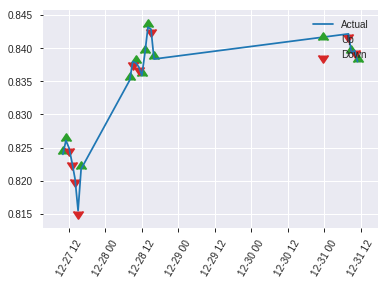


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1896414003412181
RMSE: 0.4354783580629675
LogLoss: 0.5600849506251333
Mean Per-Class Error: 0.25317693059628543
AUC: 0.78123981753014
pr_auc: 0.6776899264700924
Gini: 0.5624796350602801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42870622873306274: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   48   0.3871   (48.0/124.0)
1      12   87   0.1212   (12.0/99.0)
Total  88   135  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428706     0.74359   134
max f2                       0.201629     0.846154  187
max f0point5                 0.514948     0.688337  105
max accuracy                 0.47723      0.735426  127
max precision                0.732058     0.833333  17
max recall                   0.201629     1         187
max specificity              0.822759     0.991935  0
max absolute_mcc             0.428706     0.499819  134
max min_per_class_accuracy   0.514948     0.725806  105
max mean_per_class_accuracy  0.47723      0.746823  127

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 46.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.781559           1.50168   1.50168            0.666667         0.808753  0.666667                    0.808753            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.767745           1.12626   1.35152            0.5              0.771558  0.6                         0.793875            0.010101        0.030303                   12.6263   35.1515
    3        0.0313901                   0.764513           2.25253   1.60895            1                0.76658   0.714286                    0.786076            0.020202        0.0505051                  125.253   60.8947
    4        0.0403587                   0.76269            1.12626   1.50168            0.5              0.763742  0.666667                    0.781113            0.010101        0.0606061                  12.6263   50.1684
    5        0.0538117                   0.757791           2.25253   1.68939            1                0.761007  0.75                        0.776087            0.030303        0.0909091                  125.253   68.9394
    6        0.103139                    0.712535           1.6382    1.66491            0.727273         0.730849  0.73913                     0.754451            0.0808081       0.171717                   63.82     66.491
    7        0.152466                    0.673247           1.84298   1.72252            0.818182         0.689113  0.764706                    0.733312            0.0909091       0.262626                   84.2975   72.2519
    8        0.201794                    0.655792           1.6382    1.70191            0.727273         0.664617  0.755556                    0.71652             0.0808081       0.343434                   63.82     70.1908
    9        0.300448                    0.600623           1.12626   1.51289            0.5              0.6279    0.671642                    0.687421            0.111111        0.454545                   12.6263   51.289
    10       0.399103                    0.548856           1.43343   1.49325            0.636364         0.58002   0.662921                    0.660872            0.141414        0.59596                    43.3425   49.3247
    11       0.502242                    0.512347           1.46904   1.48828            0.652174         0.525512  0.660714                    0.633075            0.151515        0.747475                   46.9038   48.8276
    12       0.600897                    0.446701           1.22865   1.44565            0.545455         0.486003  0.641791                    0.608929            0.121212        0.868687                   22.865    44.5651
    13       0.699552                    0.345072           0.511938  1.31397            0.227273         0.380314  0.583333                    0.576688            0.0505051       0.919192                   -48.8062  31.3973
    14       0.798206                    0.223142           0.40955   1.20219            0.181818         0.27401   0.533708                    0.539279            0.040404        0.959596                   -59.045   20.219
    15       0.896861                    0.170379           0.40955   1.115              0.181818         0.19682   0.495                       0.501608            0.040404        1                          -59.045   11.5
    16       1                           0.0997965          0         1                  0                0.137617  0.443946                    0.464067            0  

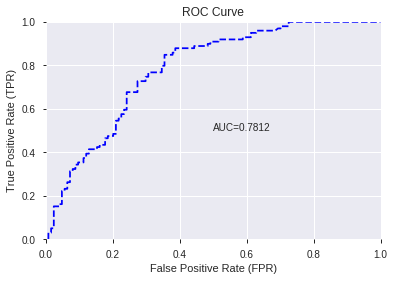

This function is available for GLM models only


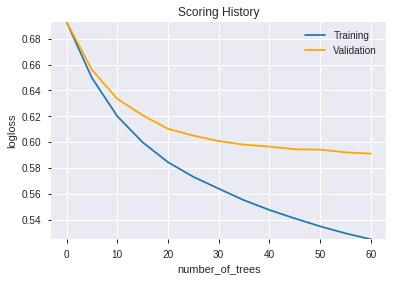

--2019-08-27 16:16:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_161537_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_161537_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'hour',
 'CCI_8',
 'OBV',
 'MFI_12',
 'Volume',
 'BETA_30',
 'MFI_14',
 'ULTOSC',
 'SUB',
 'STOCHF_fastk',
 'DX_12',
 'WILLR_8',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'aroonup_30',
 'DX_8',
 'STOCH_slowk',
 'CORREL_8',
 'AD',
 'STOCHRSI_fastk',
 'SAREXT',
 'aroonup_12',
 'day',
 'MFI_30',
 'weekday_name',
 'dayofweek',
 'HT_TRENDMODE',
 'aroondown_14',
 'aroondown_8',
 'aroonup_24',
 'CDLLONGLINE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_161616_model_1  0.756843  0.590135               0.26731  0.448898  0.20151

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.348220           1.000000  3.753851e-02
1           CDLCLOSINGMARUBOZU             0.207259           0.595196  2.234277e-02
2                         hour             0.150548           0.432336  1.622924e-02
3                          SUB             0.141386           0.406025  1.524157e-02
4                       TRANGE             0.120628           0.346413  1.300383e-02
...                        ...                  ...                ...           ...
1032                   MA_12_1             0.000008           0.000024  8.989589e-07
1033   BBANDS_upperband_30_6_4             0.000004           0.000012  4.554446e-07
1034                    WMA_24             0.000004           0.000012  4.318358e-07
1035  BBANDS_middleband_24_2_2             0.000002           0.000006  2.223464e-07
1036   BBANDS_lowerband_20_5_5             0.000001           0.000003  1.262136e-07

[1037 rows x 4 columns]

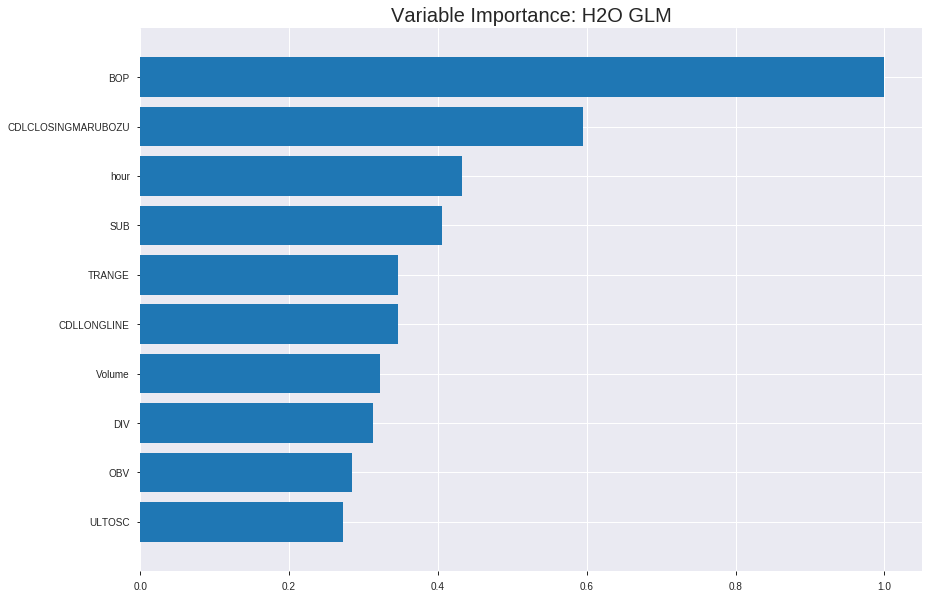

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_161616_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18604812322163217
RMSE: 0.43133296097288015
LogLoss: 0.5515212935147765
Null degrees of freedom: 1555
Residual degrees of freedom: 518
Null deviance: 2154.759827525797
Residual deviance: 1716.3342654179842
AIC: 3792.334265417984
AUC: 0.7966201951077461
pr_auc: 0.773604265179765
Gini: 0.5932403902154921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35919725094461347: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      396  412   0.5099   (412.0/808.0)
1      71   677   0.0949   (71.0/748.0)
Total  467  1089  0.3104   (483.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359197     0.737071  263
max f2                       0.232656     0.848401  319
max f0point5                 0.600779     0.715066  131
max accuracy                 0.487338     0.720437  197
max precision                0.934903     1         0
max recall                   0.0379731    1         396
max specificity              0.934903     1         0
max absolute_mcc             0.487338     0.442151  197
max min_per_class_accuracy   0.500651     0.712871  189
max mean_per_class_accuracy  0.487338     0.721187  197

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.882737           2.08021    2.08021            1                0.903353  1                           0.903353            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.866508           2.08021    2.08021            1                0.875076  1                           0.889215            0.0213904       0.0427807                  108.021   108.021
    3        0.0302057                   0.844889           1.66417    1.94743            0.8              0.856867  0.93617                     0.878891            0.0160428       0.0588235                  66.4171   94.7434
    4        0.0404884                   0.828675           1.9502     1.94814            0.9375           0.835988  0.936508                    0.867995            0.0200535       0.078877                   95.0201   94.8137
    5        0.0501285                   0.813433           1.80285    1.9202             0.866667         0.821017  0.923077                    0.858961            0.0173797       0.0962567                  80.2852   92.0197
    6        0.100257                    0.75249            1.76018    1.84019            0.846154         0.778304  0.884615                    0.818633            0.0882353       0.184492                   76.0181   84.0189
    7        0.150386                    0.70735            1.68017    1.78685            0.807692         0.729776  0.858974                    0.789014            0.0842246       0.268717                   68.0173   78.685
    8        0.200514                    0.67301            1.62683    1.74685            0.782051         0.688136  0.839744                    0.763794            0.0815508       0.350267                   62.6834   74.6846
    9        0.300129                    0.610913           1.4226     1.63923            0.683871         0.639308  0.788009                    0.722476            0.141711        0.491979                   42.2598   63.9226
    10       0.400386                    0.554595           1.12012    1.50924            0.538462         0.583166  0.725522                    0.687593            0.112299        0.604278                   12.0115   50.924
    11       0.5                         0.49442            1.19445    1.44652            0.574194         0.525607  0.695373                    0.655321            0.118984        0.723262                   19.4445   44.6524
    12       0.600257                    0.425813           0.973433   1.36751            0.467949         0.45901   0.657388                    0.622532            0.0975936       0.820856                   -2.65666  36.7507
    13       0.699871                    0.358479           0.845506   1.29321            0.406452         0.394696  0.621671                    0.590104            0.0842246       0.90508                    -15.4494  29.3209
    14       0.800129                    0.282856           0.506719   1.19466            0.24359          0.323368  0.574297                    0.556681            0.0508021       0.955882                   -49.3281  19.4661
    15       0.899743                    0.181473           0.348939   1.10103            0.167742         0.232863  0.529286                    0.52083             0.0347594       0.990642                   -65.1061  10.1028
    16       1                           0.0216701          0.0933429  1                  0.0448718        0.120755  0.48072                     0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20473138645512923
RMSE: 0.4524725256356779
LogLoss: 0.5939726117920278
Null degrees of freedom: 443
Residual degrees of freedom: -594
Null deviance: 612.6260558984648
Residual deviance: 527.4476792713207
AIC: 2603.447679271321
AUC: 0.7459337503845759
pr_auc: 0.6938625628582396
Gini: 0.49186750076915176
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4572202387894315: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  102  0.4163   (102.0/245.0)
1      35   164  0.1759   (35.0/199.0)
Total  178  266  0.3086   (137.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45722      0.705376  238
max f2                       0.338897     0.821617  304
max f0point5                 0.506798     0.656388  211
max accuracy                 0.506798     0.695946  211
max precision                0.907873     1         0
max recall                   0.105596     1         389
max specificity              0.907873     1         0
max absolute_mcc             0.45722      0.413809  238
max min_per_class_accuracy   0.527021     0.678392  193
max mean_per_class_accuracy  0.45722      0.703897  238

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.897739           2.23116   2.23116            1                0.903057  1                           0.903057            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.887078           2.23116   2.23116            1                0.894181  1                           0.899112            0.0201005       0.0452261                  123.116   123.116
    3        0.0315315                   0.859898           2.23116   2.23116            1                0.873878  1                           0.8901              0.0251256       0.0703518                  123.116   123.116
    4        0.0405405                   0.848379           1.11558   1.98325            0.5              0.856416  0.888889                    0.882614            0.0100503       0.080402                   11.5578   98.325
    5        0.0518018                   0.838487           2.23116   2.03714            1                0.844038  0.913043                    0.874228            0.0251256       0.105528                   123.116   103.714
    6        0.101351                    0.775259           1.52124   1.78492            0.681818         0.804543  0.8                         0.84016             0.0753769       0.180905                   52.1243   78.4925
    7        0.150901                    0.728875           1.72407   1.76494            0.772727         0.745855  0.791045                    0.809194            0.0854271       0.266332                   72.4075   76.4944
    8        0.20045                     0.689863           1.01416   1.57936            0.454545         0.708114  0.707865                    0.784208            0.0502513       0.316583                   1.41617   57.9357
    9        0.29955                     0.631992           1.31841   1.49303            0.590909         0.657934  0.669173                    0.742433            0.130653        0.447236                   31.841    49.3029
    10       0.400901                    0.567406           1.23953   1.42894            0.555556         0.601976  0.640449                    0.706925            0.125628        0.572864                   23.9531   42.8942
    11       0.5                         0.519464           1.21699   1.38693            0.545455         0.54066   0.621622                    0.673971            0.120603        0.693467                   21.6994   38.6935
    12       0.599099                    0.457035           1.31841   1.3756             0.590909         0.493292  0.616541                    0.644084            0.130653        0.824121                   31.841    37.56
    13       0.70045                     0.37823            0.594975  1.26265            0.266667         0.415409  0.565916                    0.610996            0.0603015       0.884422                   -40.5025  26.2648
    14       0.79955                     0.317475           0.608497  1.18157            0.272727         0.347685  0.529577                    0.57836             0.0603015       0.944724                   -39.1503  18.157
    15       0.898649                    0.208828           0.354957  1.09041            0.159091         0.265075  0.488722                    0.543813            0.0351759       0.979899                   -64.5043  9.04145
    16       1                           0.0250059          0.198325  1                  0.0888889        0.143677  0.448198                    0.503258            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:16:20  0.000 sec   2            .2E2      1021          1.3617063509377694  1.3588336049985887
     2019-08-27 16:16:22  2.075 sec   4            .15E2     1037          1.354743087425971   1.3529986563416665
     2019-08-27 16:16:24  4.183 sec   6            .11E2     1038          1.3460773186078852  1.3456906477158888
     2019-08-27 16:16:27  6.521 sec   8            .77E1     1038          1.3354580189286682  1.3368441542921634
     2019-08-27 16:16:29  8.567 sec   10           .56E1     1038          1.3227228768895871  1.3263584818969962
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:16:58  37.760 sec  38           .66E-1    1038          1.0919309760168292  1.1887914415136807
     2019-08-27 16:17:00  39.787 sec  40           .48E-1    1038          1.081791401304259   1.1923129489261937
     2019-08-27 16:17:02  41.811 sec  42           .35E-1    1038          1.0726057010259502  1.1987145194380782
     2019-08-27 16:17:04  43.830 sec  44           .25E-1    1038          1.064375899450003   1.2096069761662787
     2019-08-27 16:17:06  45.871 sec  46           .19E-1    1038          1.056854801612234   1.2224655350917946


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7256637168141592)

('auc', 0.7568426197458455)

('logloss', 0.5901354951948914)

('mean_per_class_error', 0.2673101987618116)

('rmse', 0.448898339117025)

('mse', 0.20150971886202357)

glm prediction progress: |████████████████████████████████████████████████| 100%


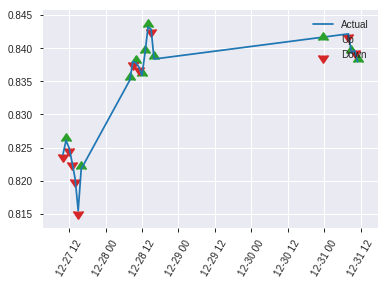


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20150971886202357
RMSE: 0.448898339117025
LogLoss: 0.5901354951948914
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 307.54649216112034
Residual deviance: 263.20043085692157
AIC: 2339.2004308569217
AUC: 0.7568426197458455
pr_auc: 0.6538867332558691
Gini: 0.5136852394916911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39252154534409683: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      79   45   0.3629   (45.0/124.0)
1      17   82   0.1717   (17.0/99.0)
Total  96   127  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392522     0.725664  126
max f2                       0.252635     0.828924  170
max f0point5                 0.392522     0.675453  126
max accuracy                 0.392522     0.721973  126
max precision                0.860799     0.833333  5
max recall                   0.100526     1         210
max specificity              0.94134      0.991935  0
max absolute_mcc             0.392522     0.46698   126
max min_per_class_accuracy   0.451521     0.693548  106
max mean_per_class_accuracy  0.392522     0.73269   126

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 43.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.912464           1.50168   1.50168            0.666667         0.922584  0.666667                    0.922584            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.874715           2.25253   1.80202            1                0.897874  0.8                         0.9127              0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.847238           1.12626   1.60895            0.5              0.859322  0.714286                    0.897449            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.821191           1.12626   1.50168            0.5              0.835994  0.666667                    0.883792            0.010101        0.0606061                  12.6263   50.1684
    5        0.0538117                   0.800183           2.25253   1.68939            1                0.813284  0.75                        0.866165            0.030303        0.0909091                  125.253   68.9394
    6        0.103139                    0.728877           1.43343   1.56697            0.636364         0.767351  0.695652                    0.818906            0.0707071       0.161616                   43.3425   56.6974
    7        0.152466                    0.676514           1.6382    1.59002            0.727273         0.693792  0.705882                    0.778428            0.0808081       0.242424                   63.82     59.0018
    8        0.201794                    0.616028           1.43343   1.55174            0.636364         0.657853  0.688889                    0.748954            0.0707071       0.313131                   43.3425   55.174
    9        0.300448                    0.549644           1.43343   1.51289            0.636364         0.578846  0.671642                    0.693098            0.141414        0.454545                   43.3425   51.289
    10       0.399103                    0.488151           1.43343   1.49325            0.636364         0.521505  0.662921                    0.650682            0.141414        0.59596                    43.3425   49.3247
    11       0.502242                    0.444397           1.17523   1.42794            0.521739         0.462628  0.633929                    0.612063            0.121212        0.717172                   17.5231   42.794
    12       0.600897                    0.371932           1.22865   1.39522            0.545455         0.405541  0.619403                    0.578157            0.121212        0.838384                   22.865    39.5221
    13       0.699552                    0.291529           0.614325  1.28509            0.272727         0.335931  0.570513                    0.543997            0.0606061       0.89899                    -38.5675  28.5095
    14       0.798206                    0.228272           0.511938  1.18954            0.227273         0.265976  0.52809                     0.509635            0.0505051       0.949495                   -48.8062  18.9536
    15       0.896861                    0.15362            0.204775  1.08121            0.0909091        0.19309   0.48                        0.474815            0.020202        0.969697                   -79.5225  8.12121
    16       1                           0.00760716         0.293808  1                  0.130435         0.102139  0.443946                    0.436377            0

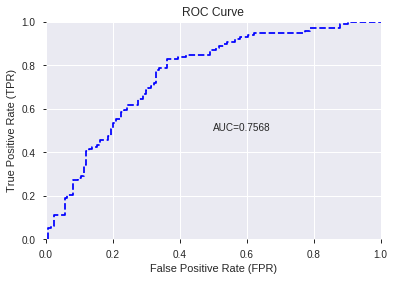

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


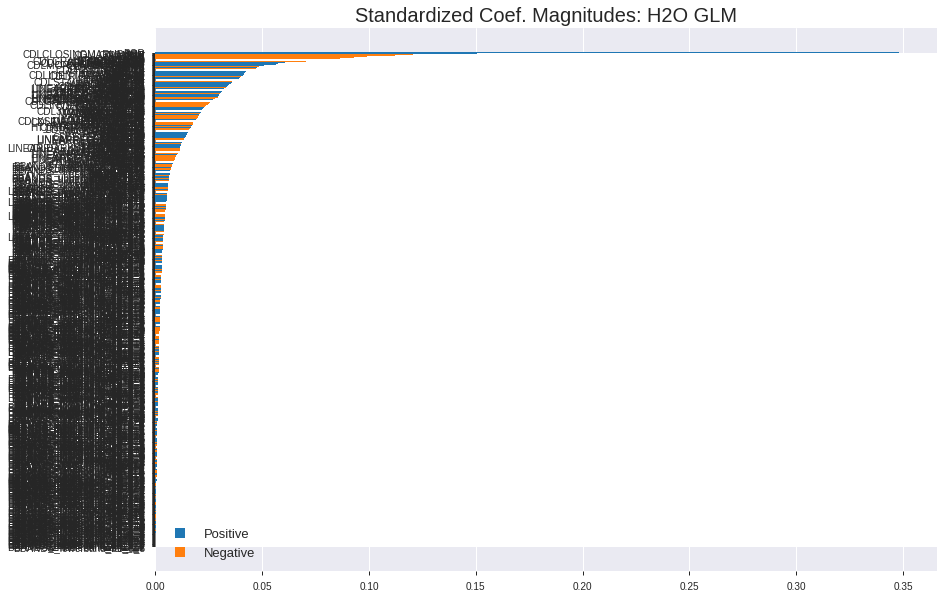

'log_likelihood'
--2019-08-27 16:17:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.82.114
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.82.114|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_161616_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_161616_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

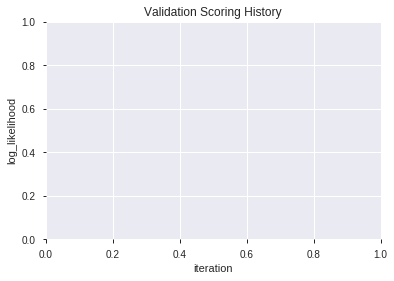

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_161746  0.790648  0.555280              0.270365  0.433401  0.187836
1  XGBoost_grid_1_AutoML_20190827_161746_model_4  0.776149  0.565524              0.260223  0.438612  0.192381
2  XGBoost_grid_1_AutoML_20190827_161746_model_1  0.774112  0.559454              0.268288  0.436436  0.190476
3  XGBoost_grid_1_AutoML_20190827_161746_model_2  0.770772  0.566874              0.277289  0.439393  0.193066
4               XGBoost_1_AutoML_20190827_161746  0.770528  0.563733              0.272279  0.438577  0.192350
5  XGBoost_grid_1_AutoML_20190827_161746_model_3  0.762219  0.569184              0.288449  0.442022  0.195383
6               XGBoost_3_AutoML_20190827_161746  0.761323  0.571602              0.278348  0.442248  0.195583
7  XGBoost_grid_1_AutoML_20190827_161746_model_7  0.760101  0.571845              0.295495  0.443261  0.196481
8  XGBoost_grid_1_AutoML_20190827_161746_model_6  0.755376  0.573530              0.294477  0.443473  0.196669
9  XGBoost_grid_1_AutoML_20190827_161746_model_5  0.753340  0.580018              0.313620  0.446108  0.199013

variable  relative_importance  scaled_importance  percentage
0                        BOP          1480.968018           1.000000    0.204471
1                        DIV           310.750854           0.209830    0.042904
2                     TRANGE           283.021240           0.191106    0.039075
3             STOCHRSI_fastk           201.813675           0.136271    0.027864
4         CDLCLOSINGMARUBOZU           178.270248           0.120374    0.024613
..                       ...                  ...                ...         ...
260  BBANDS_upperband_12_6_5             1.579916           0.001067    0.000218
261  BBANDS_lowerband_12_4_4             1.279999           0.000864    0.000177
262                   MOM_20             0.794121           0.000536    0.000110
263                   VAR_12             0.773182           0.000522    0.000107
264  BBANDS_upperband_12_0_3             0.724266           0.000489    0.000100

[265 rows x 4 columns]

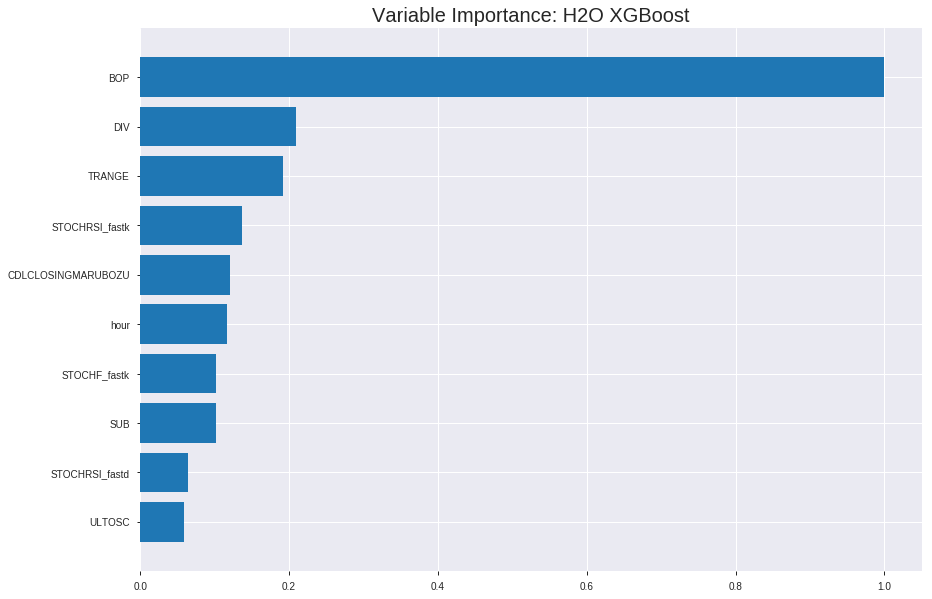

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_161746


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13380682365455845
RMSE: 0.36579615040970354
LogLoss: 0.4353858121820597
Mean Per-Class Error: 0.14286612484777894
AUC: 0.9302819068671573
pr_auc: 0.9299315029987426
Gini: 0.8605638137343146
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5061909059683481: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  132  0.1634   (132.0/808.0)
1      100  648  0.1337   (100.0/748.0)
Total  776  780  0.1491   (232.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506191     0.848168  191
max f2                       0.394217     0.889085  245
max f0point5                 0.617431     0.890434  136
max accuracy                 0.552114     0.859254  167
max precision                0.884332     1         0
max recall                   0.137375     1         363
max specificity              0.884332     1         0
max absolute_mcc             0.552114     0.720584  167
max min_per_class_accuracy   0.515088     0.847594  186
max mean_per_class_accuracy  0.552114     0.857134  167

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.855373           2.08021    2.08021            1                0.867662  1                           0.867662            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.840701           2.08021    2.08021            1                0.849089  1                           0.858376            0.0213904       0.0427807                  108.021   108.021
    3        0.0302057                   0.832306           2.08021    2.08021            1                0.836216  1                           0.851303            0.0200535       0.0628342                  108.021   108.021
    4        0.0404884                   0.816961           2.08021    2.08021            1                0.824011  1                           0.844372            0.0213904       0.0842246                  108.021   108.021
    5        0.0501285                   0.808493           2.08021    2.08021            1                0.812798  1                           0.8383              0.0200535       0.104278                   108.021   108.021
    6        0.100257                    0.767394           2.05354    2.06688            0.987179         0.789151  0.99359                     0.813726            0.102941        0.207219                   105.354   106.688
    7        0.150386                    0.738432           2.02688    2.05354            0.974359         0.751106  0.987179                    0.792853            0.101604        0.308824                   102.688   105.354
    8        0.200514                    0.707292           2.00021    2.04021            0.961538         0.721889  0.980769                    0.775112            0.100267        0.409091                   100.021   104.021
    9        0.300129                    0.65005            1.93259    2.00449            0.929032         0.678852  0.963597                    0.743162            0.192513        0.601604                   93.2586   100.449
    10       0.400386                    0.575872           1.53349    1.88655            0.737179         0.616689  0.906902                    0.711493            0.153743        0.755348                   53.3491   88.655
    11       0.5                         0.506084           1.1005     1.72995            0.529032         0.537122  0.83162                     0.676753            0.109626        0.864973                   10.05     72.9947
    12       0.600257                    0.421205           0.640066   1.54791            0.307692         0.46434   0.744111                    0.641275            0.0641711       0.929144                   -35.9934  54.7911
    13       0.699871                    0.333272           0.322098   1.37344            0.154839         0.377644  0.660239                    0.603752            0.0320856       0.96123                    -67.7902  37.3438
    14       0.800129                    0.238821           0.213355   1.22808            0.102564         0.287654  0.590361                    0.564145            0.0213904       0.98262                    -78.6645  22.8078
    15       0.899743                    0.146967           0.161049   1.10994            0.0774194        0.187257  0.533571                    0.522418            0.0160428       0.998663                   -83.8951  10.9943
    16       1                           0.0566661          0.0133347  1                  0.00641026       0.110188  0.48072                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20317561635328196
RMSE: 0.4507500597374136
LogLoss: 0.5902545633900582
Mean Per-Class Error: 0.30238949851297303
AUC: 0.7476976720336376
pr_auc: 0.6984494369066766
Gini: 0.49539534406727515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46807965636253357: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  102  0.4163   (102.0/245.0)
1      39   160  0.196    (39.0/199.0)
Total  182  262  0.3176   (141.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46808      0.694143  230
max f2                       0.155973     0.823675  369
max f0point5                 0.599823     0.657439  149
max accuracy                 0.528291     0.691441  198
max precision                0.879278     1         0
max recall                   0.155973     1         369
max specificity              0.879278     1         0
max absolute_mcc             0.490591     0.396034  218
max min_per_class_accuracy   0.546428     0.688442  187
max mean_per_class_accuracy  0.490591     0.697611  218

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.8466             2.23116   2.23116            1                0.860566  1                           0.860566            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.820538           2.23116   2.23116            1                0.832582  1                           0.848128            0.0201005       0.0452261                  123.116   123.116
    3        0.0315315                   0.809695           2.23116   2.23116            1                0.815289  1                           0.8364              0.0251256       0.0703518                  123.116   123.116
    4        0.0405405                   0.800803           1.67337   2.1072             0.75             0.808011  0.944444                    0.830091            0.0150754       0.0854271                  67.3367   110.72
    5        0.0518018                   0.791496           2.23116   2.13415            1                0.795939  0.956522                    0.822667            0.0251256       0.110553                   123.116   113.415
    6        0.101351                    0.743262           1.62266   1.88409            0.727273         0.769822  0.844444                    0.796832            0.080402        0.190955                   62.2659   88.4087
    7        0.150901                    0.716506           1.11558   1.63174            0.5              0.73196   0.731343                    0.77553             0.0552764       0.246231                   11.5578   63.1741
    8        0.20045                     0.690639           1.82549   1.67963            0.818182         0.706131  0.752809                    0.758376            0.0904523       0.336683                   82.5491   67.9634
    9        0.29955                     0.640051           1.06487   1.47625            0.477273         0.670346  0.661654                    0.729253            0.105528        0.442211                   6.48698   47.6253
    10       0.400901                    0.588511           1.53702   1.49162            0.688889         0.614377  0.668539                    0.700211            0.155779        0.59799                    53.7018   49.1615
    11       0.5                         0.530395           1.06487   1.40704            0.477273         0.561008  0.630631                    0.672621            0.105528        0.703518                   6.48698   40.7035
    12       0.599099                    0.445415           1.01416   1.34205            0.454545         0.496003  0.601504                    0.643406            0.100503        0.80402                    1.41617   34.2049
    13       0.70045                     0.336616           0.743719  1.25547            0.333333         0.393168  0.562701                    0.607198            0.0753769       0.879397                   -25.6281  25.5474
    14       0.79955                     0.238607           0.507081  1.16271            0.227273         0.286311  0.521127                    0.567426            0.0502513       0.929648                   -49.2919  16.2715
    15       0.898649                    0.168759           0.405665  1.07923            0.181818         0.20705   0.483709                    0.527686            0.040201        0.969849                   -59.4335  7.92307
    16       1                           0.0839022          0.297487  1                  0.133333         0.137523  0.448198                    0.488142          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:17:52  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.51928                          0.5                0.693147              0.5               0                    1                  0.551802
    2019-08-27 16:17:53  0.974 sec   5                  0.475088         0.644287            0.832126        0.798629           1.99354          0.258355                         0.48217            0.6579                0.737494          0.690323             1.95226            0.382883
    2019-08-27 16:17:54  1.542 sec   10                 0.45561          0.606835            0.850828        0.841317           1.9502           0.261568                         0.470691           0.635187              0.743165          0.703073             2.23116            0.351351
    2019-08-27 16:17:54  2.116 sec   15                 0.438878         0.574759            0.86609         0.861118           2.08021          0.235219                         0.463768           0.620962              0.739299          0.693601             2.23116            0.342342
    2019-08-27 16:17:55  2.701 sec   20                 0.425911         0.549816            0.879918        0.87872            2.08021          0.203085                         0.458564           0.60997               0.745257          0.700525             2.23116            0.36036
    2019-08-27 16:17:55  3.260 sec   25                 0.415836         0.530072            0.885415        0.885706           2.08021          0.20437                          0.455323           0.602929              0.748436          0.702681             2.23116            0.353604
    2019-08-27 16:17:56  3.819 sec   30                 0.406946         0.512751            0.892148        0.891946           2.08021          0.197301                         0.453021           0.597505              0.748682          0.702381             2.23116            0.335586
    2019-08-27 16:17:56  4.441 sec   35                 0.399007         0.497235            0.898555        0.898647           2.08021          0.196015                         0.452526           0.595586              0.745462          0.696282             2.23116            0.34009
    2019-08-27 16:17:57  5.094 sec   40                 0.391338         0.482807            0.907086        0.905895           2.08021          0.178663                         0.451537           0.593286              0.745718          0.69922              2.23116            0.367117
    2019-08-27 16:17:58  5.731 sec   45                 0.384249         0.469542            0.915062        0.9135             2.08021          0.167738                         0.451618           0.593109              0.745288          0.694123             2.23116            0.344595
    2019-08-27 16:17:58  6.320 sec   50                 0.377816         0.45727             0.920241        0.921524           2.08021          0.15874                          0.451196           0.591429              0.745554          0.695732             2.23116            0.335586
    2019-08-27 16:17:59  6.924 sec   55                 0.371275         0.445309            0.925959        0.926492           2.08021          0.153599                         0.450535           0.589816              0.74781           0.6

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1480.968017578125      1.0                    0.20447065396990588
DIV                      310.7508544921875      0.20982955121500088    0.04290398555914309
TRANGE                   283.021240234375       0.19110557208197435    0.03907548130089428
STOCHRSI_fastk           201.8136749267578      0.13627146064692894    0.027863514675911853
CDLCLOSINGMARUBOZU       178.27024841308594     0.12037413792677107    0.024612978702950532
---                      ---                    ---                    ---
BBANDS_upperband_12_6_5  1.579916000366211      0.0010668130449905994  0.00021813196097285448
BBANDS_lowerband_12_4_4  1.279998779296875      0.0008642987317106945  0.00017672372689824594
MOM_20                   0.7941207885742188     0.0005362173788687687  0.00010964071812732593
VAR_12                   0.7731819152832031     0.0005220787391125519  0.00010674978121012737
BBANDS_upperband_12_0_3  0.7242660522460938     0.0004890490838759026  9.999618600348918e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.7181818181818181)

('auc', 0.7906484196806778)

('logloss', 0.5552802407385259)

('mean_per_class_error', 0.2703649397197785)

('rmse', 0.43340069221534316)

('mse', 0.18783616001273862)

xgboost prediction progress: |████████████████████████████████████████████| 100%


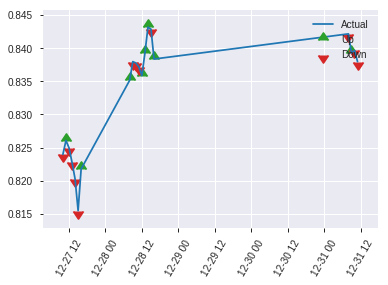


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18783616001273862
RMSE: 0.43340069221534316
LogLoss: 0.5552802407385259
Mean Per-Class Error: 0.2703649397197785
AUC: 0.7906484196806778
pr_auc: 0.7167716639051216
Gini: 0.5812968393613556
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45133161544799805: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   42   0.3387   (42.0/124.0)
1      20   79   0.202    (20.0/99.0)
Total  102  121  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451332     0.718182  120
max f2                       0.191909     0.846287  182
max f0point5                 0.529564     0.694737  93
max accuracy                 0.529564     0.726457  93
max precision                0.713329     0.9       19
max recall                   0.128919     1         211
max specificity              0.846538     0.991935  0
max absolute_mcc             0.451332     0.45804   120
max min_per_class_accuracy   0.497592     0.717742  106
max mean_per_class_accuracy  0.451332     0.729635  120

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 44.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.816426           1.50168    1.50168            0.666667         0.83274   0.666667                    0.83274             0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.793132           2.25253    1.80202            1                0.803304  0.8                         0.820966            0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.778844           2.25253    1.93074            1                0.782908  0.857143                    0.810092            0.020202        0.0606061                  125.253   93.0736
    4        0.0403587                   0.761802           1.12626    1.75196            0.5              0.777744  0.777778                    0.802904            0.010101        0.0707071                  12.6263   75.1964
    5        0.0538117                   0.751198           2.25253    1.8771             1                0.756761  0.833333                    0.791368            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.703362           2.04775    1.95872            0.909091         0.726174  0.869565                    0.760188            0.10101         0.20202                    104.775   95.8718
    7        0.152466                    0.678179           1.6382     1.85502            0.727273         0.689675  0.823529                    0.737375            0.0808081       0.282828                   63.82     85.5021
    8        0.201794                    0.641263           1.22865    1.70191            0.545455         0.661027  0.755556                    0.718712            0.0606061       0.343434                   22.865    70.1908
    9        0.300448                    0.587082           1.53581    1.64737            0.681818         0.611126  0.731343                    0.683386            0.151515        0.494949                   53.5813   64.7369
    10       0.399103                    0.535137           1.33104    1.56917            0.590909         0.56322   0.696629                    0.653682            0.131313        0.626263                   33.1038   56.9175
    11       0.502242                    0.478716           1.27317    1.50839            0.565217         0.510908  0.669643                    0.624362            0.131313        0.757576                   27.3166   50.8387
    12       0.600897                    0.426072           0.511938   1.34479            0.227273         0.448129  0.597015                    0.595428            0.0505051       0.808081                   -48.8062  34.4791
    13       0.699552                    0.305999           1.02388    1.29953            0.454545         0.371055  0.576923                    0.563786            0.10101         0.909091                   2.38751   29.9534
    14       0.798206                    0.205611           0.614325   1.21485            0.272727         0.24719   0.539326                    0.524656            0.0606061       0.969697                   -38.5675  21.4845
    15       0.896861                    0.159182           0.204775   1.10374            0.0909091        0.180643  0.49                        0.486815            0.020202        0.989899                   -79.5225  10.3737
    16       1                           0.065754           0.0979359  1                  0.0434783        0.12079   0.443946                    

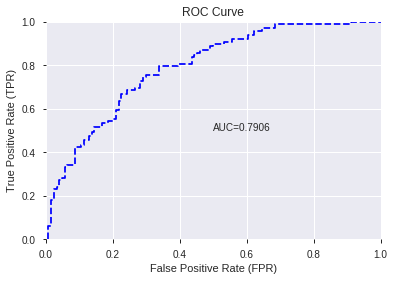

This function is available for GLM models only


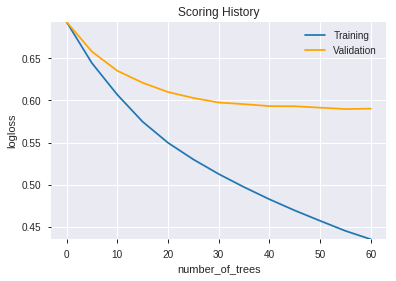

--2019-08-27 16:18:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


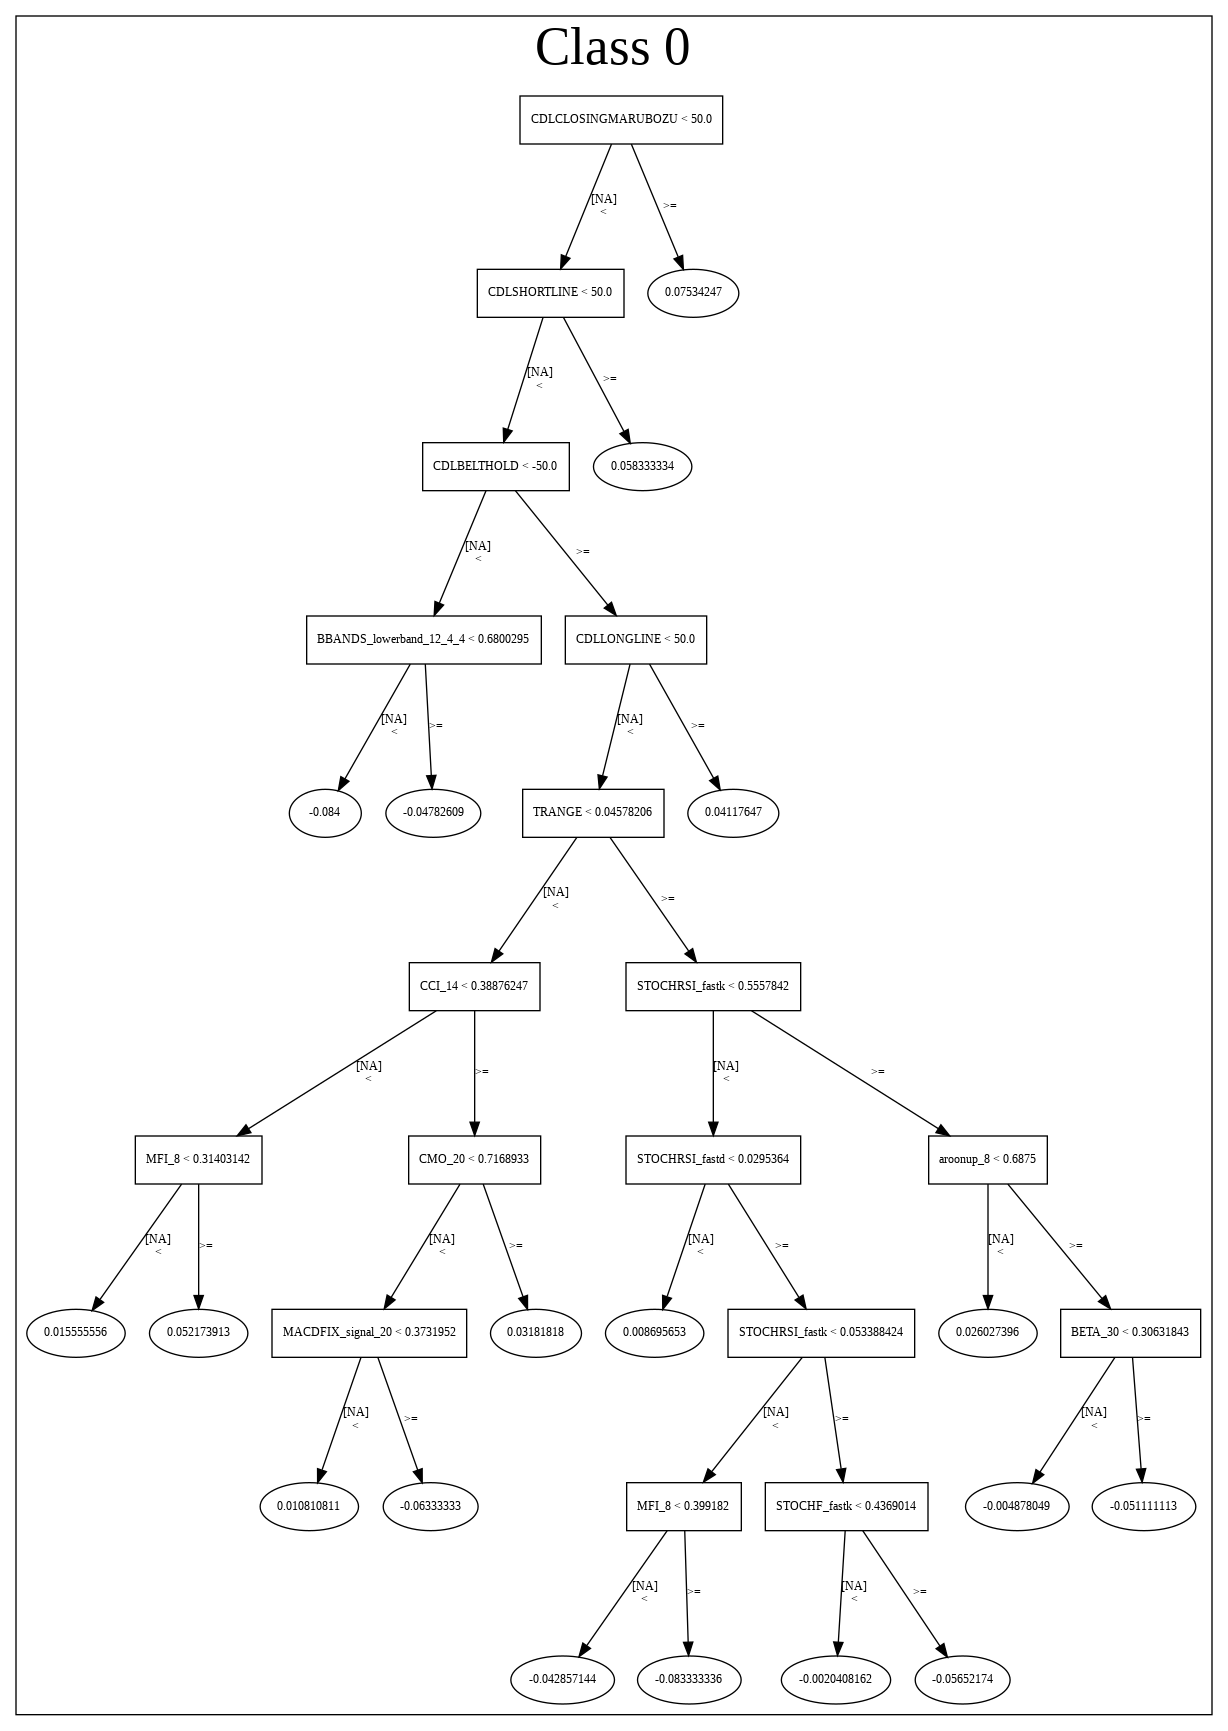

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_161746',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_161746',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_863b',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_161907_model_8  0.768247  0.592990              0.272320  0.446992  0.199802
1  DeepLearning_grid_1_AutoML_20190827_161907_model_9  0.760182  0.588492              0.276434  0.446302  0.199185
2  DeepLearning_grid_1_AutoML_20190827_161907_model_6  0.759857  0.587897              0.312602  0.446399  0.199272
3  DeepLearning_grid_1_AutoML_20190827_161907_model_5  0.750570  0.595391              0.311624  0.451985  0.204290
4  DeepLearning_grid_1_AutoML_20190827_161907_model_2  0.750000  0.782169              0.288571  0.481701  0.232036
5               DeepLearning_1_AutoML_20190827_161907  0.749022  0.626803              0.286494  0.454826  0.206867
6  DeepLearning_grid_1_AutoML_20190827_161907_model_3  0.743483  0.714746              0.342823  0.467907  0.218937
7  DeepLearning_grid_1_AutoML_20190827_161907_model_7  0.742832  0.802237              0.331704  0.495928  0.245944
8  DeepLearning_grid_1_AutoML_20190827_161907_model_4  0.728169  0.760253              0.302786  0.483937  0.234195
9  DeepLearning_grid_1_AutoML_20190827_161907_model_1  0.714402  0.883727              0.335777  0.508912  0.258991

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.038955
1    CDLCLOSINGMARUBOZU             0.713061           0.713061    0.027778
2                  hour             0.650368           0.650368    0.025335
3                   SUB             0.607947           0.607947    0.023683
4                TRANGE             0.606891           0.606891    0.023642
5                   DIV             0.583793           0.583793    0.022742
6          STOCHF_fastk             0.583670           0.583670    0.022737
7                ULTOSC             0.539098           0.539098    0.021001
8                MFI_14             0.535335           0.535335    0.020854
9           CDLLONGLINE             0.534476           0.534476    0.020821
10         CDLSHORTLINE             0.531525           0.531525    0.020706
11          CDLHIGHWAVE             0.531421           0.531421    0.020702
12                CCI_8             0.531249           0.531249    0.020695
13                  OBV             0.529011           0.529011    0.020608
14               Volume             0.528024           0.528024    0.020569
15         HT_TRENDMODE             0.526331           0.526331    0.020503
16              WILLR_8             0.520515           0.520515    0.020277
17               SAREXT             0.510017           0.510017    0.019868
18         weekday_name             0.507690           0.507690    0.019777
19              BETA_30             0.506049           0.506049    0.019713
20             CORREL_8             0.502653           0.502653    0.019581
21                  day             0.502416           0.502416    0.019572
22            dayofweek             0.501751           0.501751    0.019546
23                DX_12             0.498138           0.498138    0.019405
24         aroondown_12             0.498114           0.498114    0.019404
25           aroonup_30             0.491808           0.491808    0.019159
26              weekday             0.490666           0.490666    0.019114
27       STOCHRSI_fastd             0.490091           0.490091    0.019092
28           aroonup_24             0.488482           0.488482    0.019029
29                 DX_8             0.486268           0.486268    0.018943
30       STOCHRSI_fastk             0.485900           0.485900    0.018928
31           aroonup_12             0.485886           0.485886    0.018928
32          STOCH_slowd             0.484548           0.484548    0.018876
33               MFI_30             0.481909           0.481909    0.018773
34         STOCHF_fastd             0.479898           0.479898    0.018695
35          aroondown_8             0.477456           0.477456    0.018599
36       CDLRICKSHAWMAN             0.473050           0.473050    0.018428
37          STOCH_slowk             0.472637           0.472637    0.018412
38      CDLLADDERBOTTOM             0.466819           0.466819    0.018185
39               MFI_12             0.464385           0.464385    0.018090
40         aroondown_14             0.464164           0.464164    0.018082
41   CDLIDENTICAL3CROWS             0.455494           0.455494    0.017744
42          CDLPIERCING             0.455402           0.455402    0.017740
43  CDLGAPSIDESIDEWHITE             0.454284           0.454284    0.017697
44   CDLEVENINGDOJISTAR             0.446679           0.446679    0.017401
45                   AD             0.440527           0.440527    0.017161
46       CDL3BLACKCROWS             0.433568           0.433568    0.016890
47       CDLEVENINGSTAR             0.421425           0.421425    0.016417
48      CDLUNIQUE3RIVER             0.406212           0.406212    0.015824
49    CDLSTALLEDPATTERN             0.393273           0.393273    0.015320

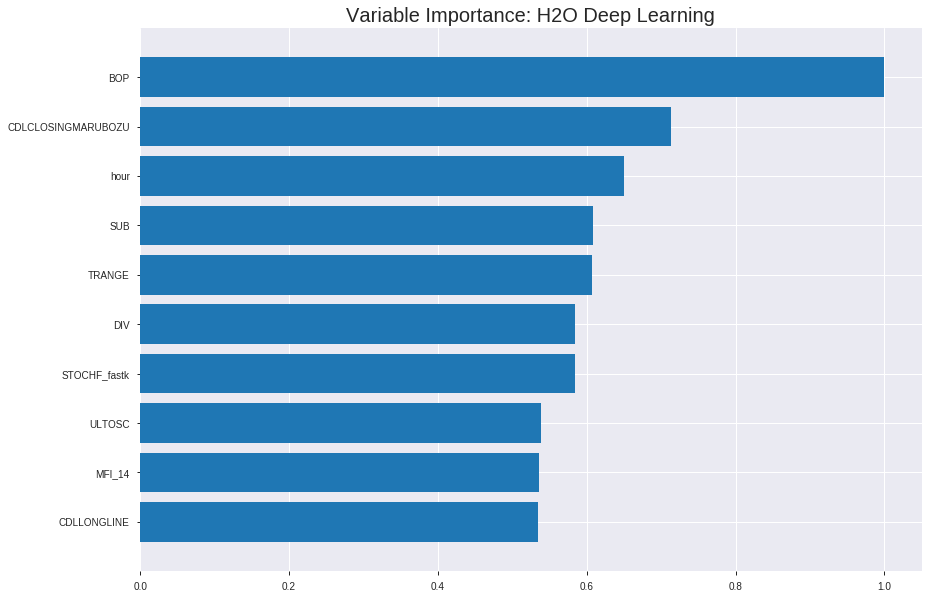

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_161907_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19737323592365685
RMSE: 0.44426707724482223
LogLoss: 0.5723666545893643
Mean Per-Class Error: 0.27992137449039023
AUC: 0.7884904299253455
pr_auc: 0.7626617615326364
Gini: 0.5769808598506909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33423485459330116: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      414  394   0.4876   (394.0/808.0)
1      70   678   0.0936   (70.0/748.0)
Total  484  1072  0.2982   (464.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334235     0.745055  251
max f2                       0.191298     0.850583  306
max f0point5                 0.45265      0.698316  175
max accuracy                 0.414431     0.717224  206
max precision                0.928545     1         0
max recall                   0.00593012   1         397
max specificity              0.928545     1         0
max absolute_mcc             0.334235     0.451998  251
max min_per_class_accuracy   0.436698     0.696524  189
max mean_per_class_accuracy  0.413292     0.720079  207

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 38.19 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.84237            2.08021    2.08021            1                0.879029   1                           0.879029            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.801104           1.9502     2.01521            0.9375           0.817946   0.96875                     0.848488            0.0200535       0.0414439                  95.0201   101.521
    3        0.0302057                   0.765665           2.08021    2.03595            1                0.784053   0.978723                    0.827923            0.0200535       0.0614973                  108.021   103.595
    4        0.0404884                   0.742199           1.82019    1.98116            0.875            0.75306    0.952381                    0.80891             0.0187166       0.0802139                  82.0187   98.1156
    5        0.0501285                   0.712497           1.94153    1.97354            0.933333         0.726869   0.948718                    0.793133            0.0187166       0.0989305                  94.1533   97.3536
    6        0.100257                    0.611125           1.78685    1.88019            0.858974         0.656262   0.903846                    0.724697            0.0895722       0.188503                   78.685    88.0193
    7        0.150386                    0.545202           1.52016    1.76018            0.730769         0.575393   0.846154                    0.674929            0.0762032       0.264706                   52.0156   76.0181
    8        0.200514                    0.515045           1.3068     1.64684            0.628205         0.527309   0.791667                    0.638024            0.065508        0.330214                   30.6801   64.6836
    9        0.300129                    0.480043           1.38234    1.55905            0.664516         0.494385   0.749465                    0.59035             0.137701        0.467914                   38.2336   55.9047
    10       0.400386                    0.458804           1.22679    1.47585            0.589744         0.468959   0.70947                     0.559953            0.122995        0.590909                   22.6793   47.585
    11       0.5                         0.433646           1.15418    1.41176            0.554839         0.446846   0.678663                    0.537419            0.114973        0.705882                   15.4183   41.1765
    12       0.600257                    0.397693           1.17345    1.37196            0.564103         0.416959   0.659529                    0.517299            0.117647        0.823529                   17.3454   37.1961
    13       0.699871                    0.314473           0.872348   1.30085            0.419355         0.365533   0.625344                    0.495698            0.0868984       0.910428                   -12.7652  30.085
    14       0.800129                    0.160521           0.506719   1.20134            0.24359          0.233005   0.57751                     0.462782            0.0508021       0.96123                    -49.3281  20.1344
    15       0.899743                    0.0443248          0.322098   1.104              0.154839         0.0951535  0.530714                    0.422081            0.0320856       0.993316                   -67.7902  10.3999
    16       1                           0.00152333         0.0666735  1                  0.0320513        0.0214649  0.48072    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2050396507005416
RMSE: 0.45281304166349007
LogLoss: 0.6005493641412871
Mean Per-Class Error: 0.2937544867193109
AUC: 0.7533688852425392
pr_auc: 0.6873951322437359
Gini: 0.5067377704850784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31774418851056724: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      128  117  0.4776   (117.0/245.0)
1      26   173  0.1307   (26.0/199.0)
Total  154  290  0.3221   (143.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317744     0.707566  254
max f2                       0.122458     0.83045   322
max f0point5                 0.419638     0.657337  213
max accuracy                 0.419638     0.698198  213
max precision                0.927832     1         0
max recall                   0.0120525    1         392
max specificity              0.927832     1         0
max absolute_mcc             0.419113     0.412898  214
max min_per_class_accuracy   0.439986     0.683417  186
max mean_per_class_accuracy  0.419113     0.706246  214

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 36.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.842834           2.23116   2.23116            1                0.875114   1                           0.875114            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.766985           1.67337   1.98325            0.75             0.811729   0.888889                    0.846943            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.692544           1.78492   1.91242            0.8              0.720472   0.857143                    0.801775            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.6612             2.23116   1.98325            1                0.669261   0.888889                    0.772327            0.0201005       0.080402                   123.116   98.325
    5        0.0518018                   0.63548            1.78492   1.94014            0.8              0.647672   0.869565                    0.745228            0.0201005       0.100503                   78.4925   94.0135
    6        0.101351                    0.570871           1.52124   1.73534            0.681818         0.607502   0.777778                    0.677896            0.0753769       0.175879                   52.1243   73.5343
    7        0.150901                    0.523113           1.52124   1.66504            0.681818         0.542361   0.746269                    0.633392            0.0753769       0.251256                   52.1243   66.5042
    8        0.20045                     0.496677           1.21699   1.55429            0.545455         0.508188   0.696629                    0.602442            0.0603015       0.311558                   21.6994   55.4288
    9        0.29955                     0.475484           1.47053   1.52658            0.659091         0.485673   0.684211                    0.563812            0.145729        0.457286                   47.0534   52.658
    10       0.400901                    0.459489           1.18995   1.44148            0.533333         0.469152   0.646067                    0.539881            0.120603        0.577889                   18.995    44.1477
    11       0.5                         0.434531           1.36912   1.42714            0.613636         0.447469   0.63964                     0.521565            0.135678        0.713568                   36.9118   42.7136
    12       0.599099                    0.390289           1.06487   1.36721            0.477273         0.418016   0.612782                    0.504437            0.105528        0.819095                   6.48698   36.7212
    13       0.70045                     0.267412           0.7933    1.28417            0.355556         0.325211   0.575563                    0.478504            0.080402        0.899497                   -20.67    28.417
    14       0.79955                     0.138486           0.507081  1.18785            0.227273         0.200988   0.532394                    0.444108            0.0502513       0.949749                   -49.2919  18.7855
    15       0.898649                    0.0433199          0.25354   1.08482            0.113636         0.0908163  0.486216                    0.405148            0.0251256       0.974874                   -74.646   8.48226
    16       1                           0.00392505         0.247906  1                  0.111111         0.021916   0.448198                    0.3


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:24:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:24:40  1 min  8.082 sec  609 obs/sec       0.636889  1             991        0.552648         0.957466            -0.223501      0.733571        0.699268           1.82019          0.359254                         0.548814           0.984724              -0.217858        0.728018          0.670525             2.23116            0.405405
    2019-08-27 16:24:50  1 min 18.207 sec  934 obs/sec       6.4126    10            9978       0.444267         0.572367            0.209331       0.78849         0.762662           2.08021          0.298201                         0.452813           0.600549              0.170943         0.753369          0.687395             2.23116            0.322072
    2019-08-27 16:25:01  1 min 28.874 sec  1074 obs/sec      14.1093   22            21954      0.435253         0.554374            0.241092       0.80511         0.783931           2.08021          0.294987                         0.457461           0.604449              0.153833         0.724654          0.661972             2.23116            0.369369
    2019-08-27 16:25:10  1 min 38.612 sec  1157 obs/sec      21.7821   34            33893      0.40931          0.49633             0.328865       0.83591         0.818386           2.08021          0.261568                         0.455766           0.610758              0.160096         0.735381          0.666223             2.23116            0.328829
    2019-08-27 16:25:20  1 min 48.121 sec  1210 obs/sec      29.4981   46            45899      0.393229         0.460484            0.380564       0.858341        0.836156           2.08021          0.253213                         0.464837           0.648828              0.126327         0.728736          0.660801             2.23116            0.317568
    2019-08-27 16:25:29  1 min 57.334 sec  1251 obs/sec      37.2044   58            57890      0.381351         0.436326            0.417418       0.876526        0.860518           2.08021          0.223008                         0.473441           0.698988              0.093688         0.722285          0.6546               2.23116            0.369369
    2019-08-27 16:25:38  2 min  6.307 sec  1285 obs/sec      44.919    70            69894      0.36713          0.407064            0.460059       0.894101        0.878666           2.08021          0.206941                         0.477588           0.710548              0.0777397        0.716152          0.633131             2.23116            0.315315
    2019-08-27 16:25:39  2 min  7.236 sec  1284 obs/sec      44.919    70            69894      0.444267         0.572367            0.209331       0.78849         0.762662           2.08021          0.298201                         0.452813           0.600549              0.170943         0.753369          0.687395             2.23116            0.322072

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03895541628698183
CDLCLOSINGMARUBOZU  0.7130606770515442     0.7130606770515442   0.02777757551242001
hour                0.6503683924674988     0.6503683924674988   0.02533537146846659
SUB                 0.607947051525116      0.607947051525116    0.023682830472604083
TRANGE              0.6068912744522095     0.6068912744522095   0.02364170223722276
---                 ---                    ---                  ---
AD                  0.44052696228027344    0.44052696228027344  0.01716091120126759
CDL3BLACKCROWS      0.4335676431655884     0.4335676431655884   0.016889808028081085
CDLEVENINGSTAR      0.4214251637458801     0.4214251637458801   0.01641679268753024
CDLUNIQUE3RIVER     0.4062120020389557     0.4062120020389557   0.01582415764019583
CDLSTALLEDPATTERN   0.3932734429836273     0.3932734429836273   0.015320130686041813


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.7264957264957265)

('auc', 0.7682469859889214)

('logloss', 0.5929902415301852)

('mean_per_class_error', 0.2723199739328772)

('rmse', 0.4469919307004413)

('mse', 0.1998017861113081)

deeplearning prediction progress: |███████████████████████████████████████| 100%


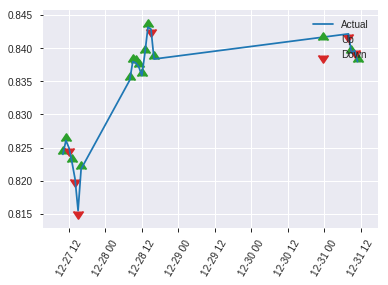


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1998017861113081
RMSE: 0.4469919307004413
LogLoss: 0.5929902415301852
Mean Per-Class Error: 0.2723199739328772
AUC: 0.7682469859889214
pr_auc: 0.696222410514522
Gini: 0.5364939719778428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37954452690257956: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   50   0.4032   (50.0/124.0)
1      14   85   0.1414   (14.0/99.0)
Total  88   135  0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379545     0.726496  134
max f2                       0.0536437    0.82483   191
max f0point5                 0.495498     0.668524  64
max accuracy                 0.384118     0.713004  132
max precision                0.782424     0.888889  8
max recall                   0.0201405    1         211
max specificity              0.870963     0.991935  0
max absolute_mcc             0.379545     0.462887  134
max min_per_class_accuracy   0.437538     0.701613  106
max mean_per_class_accuracy  0.379545     0.72768   134

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 37.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.862401           1.50168   1.50168            0.666667         0.867464   0.666667                    0.867464            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.828297           2.25253   1.80202            1                0.848545   0.8                         0.859897            0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.79104            2.25253   1.93074            1                0.810754   0.857143                    0.845856            0.020202        0.0606061                  125.253   93.0736
    4        0.0403587                   0.782056           2.25253   2.00224            1                0.783075   0.888889                    0.831904            0.020202        0.0808081                  125.253   100.224
    5        0.0538117                   0.753744           1.50168   1.8771             0.666667         0.771009   0.833333                    0.816681            0.020202        0.10101                    50.1684   87.7104
    6        0.103139                    0.624453           2.04775   1.95872            0.909091         0.687217   0.869565                    0.754763            0.10101         0.20202                    104.775   95.8718
    7        0.152466                    0.571144           1.6382    1.85502            0.727273         0.587817   0.823529                    0.700751            0.0808081       0.282828                   63.82     85.5021
    8        0.201794                    0.534947           1.02388   1.65185            0.454545         0.552755   0.733333                    0.664574            0.0505051       0.333333                   2.38751   65.1852
    9        0.300448                    0.492959           1.6382    1.64737            0.727273         0.511078   0.731343                    0.614173            0.161616        0.494949                   63.82     64.7369
    10       0.399103                    0.464387           1.02388   1.49325            0.454545         0.480531   0.662921                    0.581138            0.10101         0.59596                    2.38751   49.3247
    11       0.502242                    0.433569           1.17523   1.42794            0.521739         0.448917   0.633929                    0.553985            0.121212        0.717172                   17.5231   42.794
    12       0.600897                    0.380251           1.33104   1.41203            0.590909         0.406919   0.626866                    0.52984             0.131313        0.848485                   33.1038   41.2031
    13       0.699552                    0.230604           0.40955   1.27066            0.181818         0.309305   0.564103                    0.498739            0.040404        0.888889                   -59.045   27.0655
    14       0.798206                    0.0993553          0.614325  1.18954            0.272727         0.164247   0.52809                     0.457397            0.0606061       0.949495                   -38.5675  18.9536
    15       0.896861                    0.0364728          0.307163  1.09247            0.136364         0.0646456  0.485                       0.414194            0.030303        0.979798                   -69.2837  9.24747
    16       1                           0.00245058         0.195872  1                  0.0869565        0.0204048  0.443946                    0

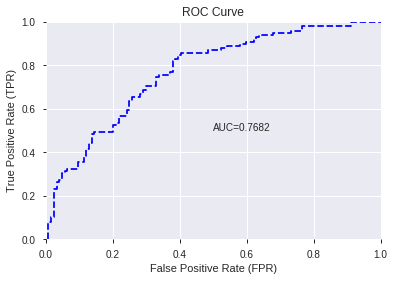

This function is available for GLM models only


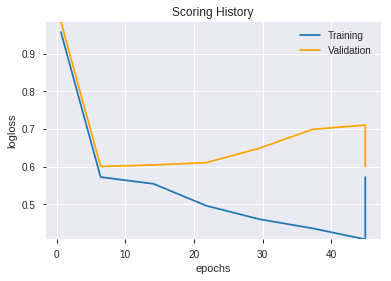

--2019-08-27 16:26:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


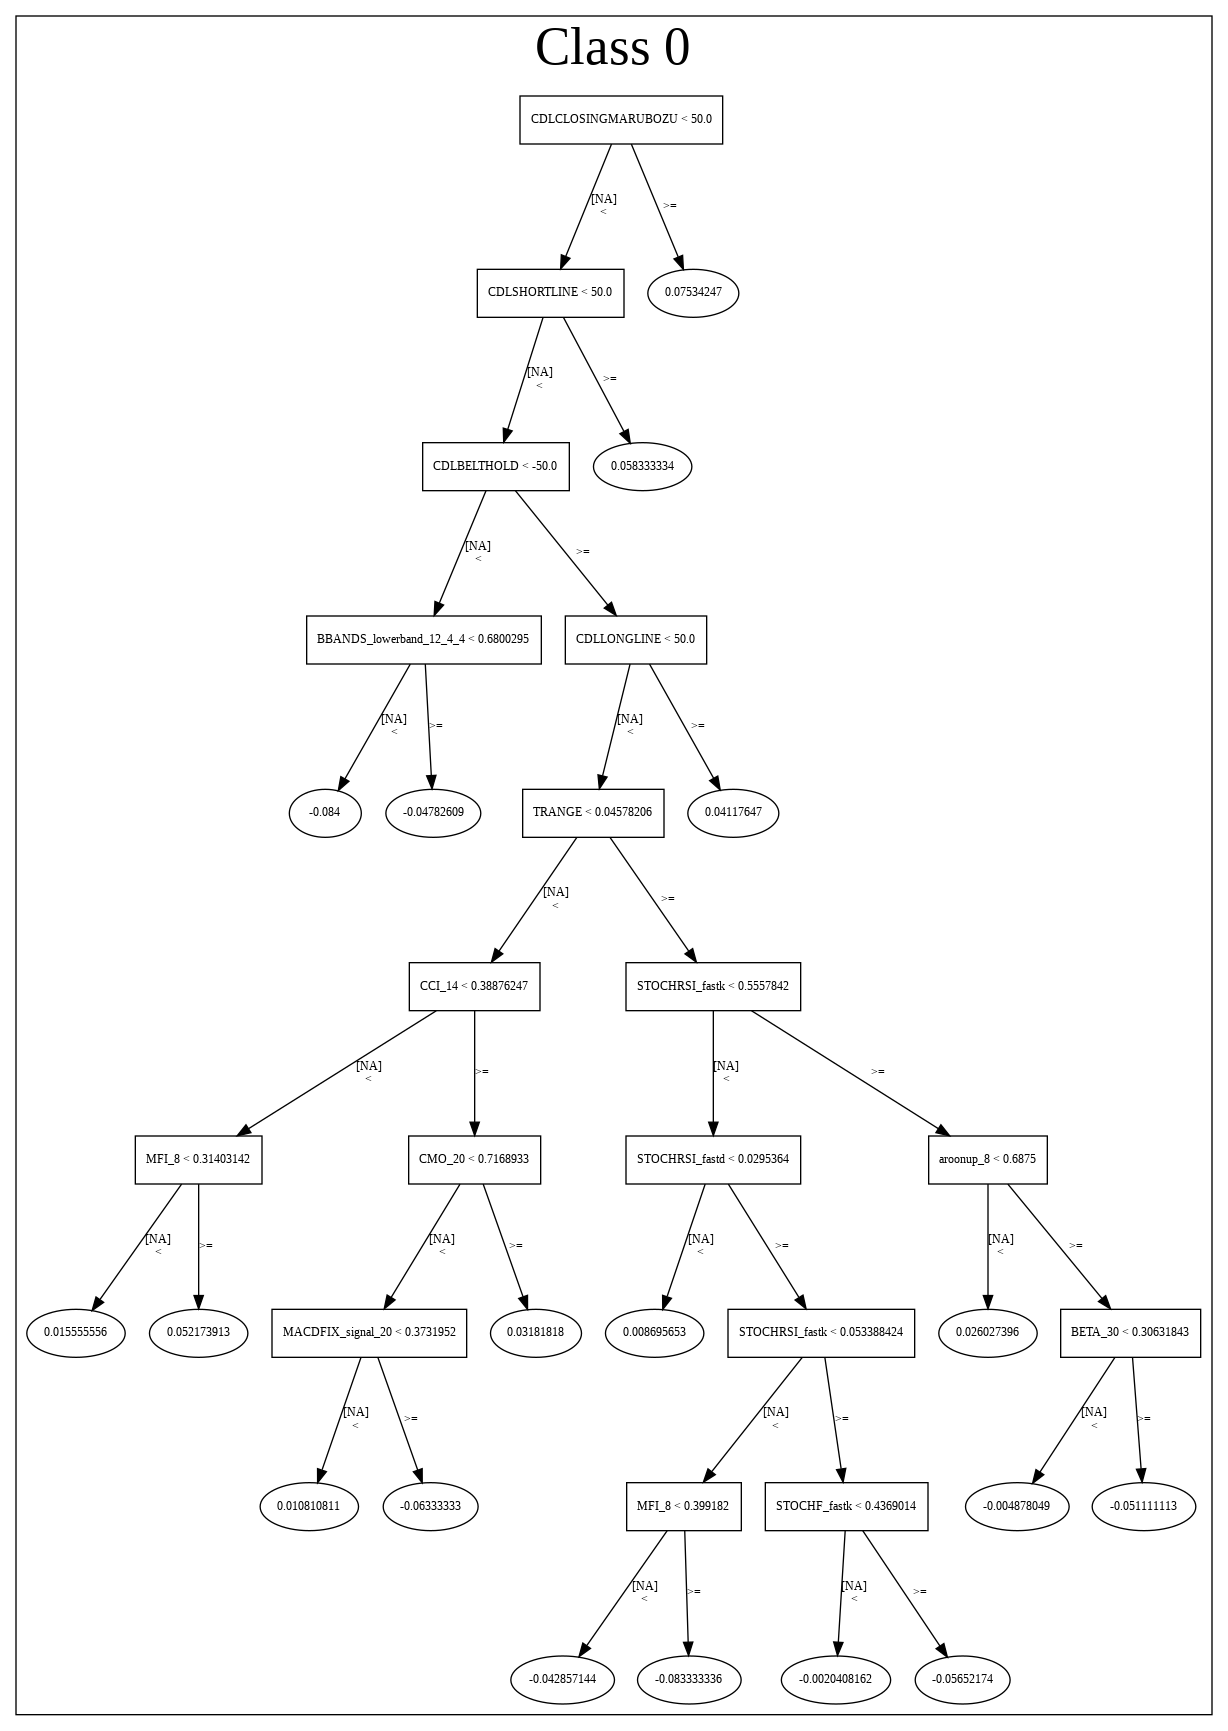

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_161907_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_161907_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'SUB',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'ULTOSC',
 'MFI_14',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLHIGHWAVE',
 'CCI_8',
 'OBV',
 'Volume',
 'HT_TRENDMODE',
 'WILLR_8',
 'SAREXT',
 'weekday_name',
 'BETA_30',
 'CORREL_8',
 'day',
 'dayofweek',
 'DX_12',
 'aroondown_12',
 'aroonup_30',
 'weekday',
 'STOCHRSI_fastd',
 'aroonup_24',
 'DX_8',
 'STOCHRSI_fastk',
 'aroonup_12',
 'STOCH_slowd',
 'MFI_30',
 'STOCHF_fastd',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'STOCH_slowk',
 'CDLLADDERBOTTOM',
 'MFI_12',
 'aroondown_14',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'AD',
 'CDL3BLACKCROWS',
 'CDLEVENINGSTAR',
 'CDLUNIQUE3RIVER',
 'CDLSTALLEDPATTERN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_162657_model_1  0.76564  0.584976              0.286453  0.445851  0.198783

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.446101           1.000000    0.123059
1    CDLCLOSINGMARUBOZU             0.233127           0.522588    0.064309
2                  hour             0.158212           0.354656    0.043644
3                ULTOSC             0.146962           0.329437    0.040540
4          STOCHF_fastk             0.141011           0.316096    0.038899
5                   OBV             0.137879           0.309077    0.038035
6                Volume             0.136445           0.305861    0.037639
7               WILLR_8             0.133900           0.300157    0.036937
8                   SUB             0.129479           0.290247    0.035718
9           CDLLONGLINE             0.127236           0.285217    0.035099
10               MFI_14             0.122019           0.273524    0.033660
11               TRANGE             0.117007           0.262289    0.032277
12                CCI_8             0.101789           0.228175    0.028079
13              BETA_30             0.095713           0.214555    0.026403
14          CDLHIGHWAVE             0.086161           0.193143    0.023768
15                  DIV             0.081632           0.182989    0.022518
16       STOCHRSI_fastk             0.077754           0.174296    0.021449
17                DX_12             0.076815           0.172192    0.021190
18         STOCHF_fastd             0.076336           0.171119    0.021058
19          STOCH_slowk             0.075680           0.169649    0.020877
20      CDLLADDERBOTTOM             0.072348           0.162179    0.019958
21         HT_TRENDMODE             0.063116           0.141484    0.017411
22          STOCH_slowd             0.058235           0.130542    0.016064
23   CDLIDENTICAL3CROWS             0.052187           0.116985    0.014396
24       CDLRICKSHAWMAN             0.050824           0.113931    0.014020
25         CDLSHORTLINE             0.049835           0.111712    0.013747
26         aroondown_12             0.048431           0.108566    0.013360
27               MFI_12             0.042758           0.095848    0.011795
28          CDLPIERCING             0.041985           0.094116    0.011582
29  CDLGAPSIDESIDEWHITE             0.039045           0.087524    0.010771
30               SAREXT             0.036673           0.082208    0.010116
31         aroondown_14             0.035876           0.080421    0.009897
32    CDLSTALLEDPATTERN             0.035233           0.078979    0.009719
33      CDLUNIQUE3RIVER             0.035113           0.078710    0.009686
34         weekday_name             0.028224           0.063268    0.007786
35           aroonup_30             0.027996           0.062758    0.007723
36             CORREL_8             0.027439           0.061508    0.007569
37   CDLEVENINGDOJISTAR             0.025381           0.056896    0.007002
38       STOCHRSI_fastd             0.021372           0.047907    0.005895
39                 DX_8             0.020605           0.046190    0.005684
40           aroonup_24             0.018516           0.041506    0.005108
41            dayofweek             0.016659           0.037343    0.004595
42              weekday             0.016565           0.037134    0.004570
43               MFI_30             0.014182           0.031790    0.003912
44          aroondown_8             0.011295           0.025319    0.003116
45                  day             0.010150           0.022753    0.002800
46       CDL3BLACKCROWS             0.010107           0.022656    0.002788
47       CDLEVENINGSTAR             0.009380           0.021026    0.002587
48                   AD             0.003445           0.007722    0.000950
49           aroonup_12             0.000856           0.001919    0.000236

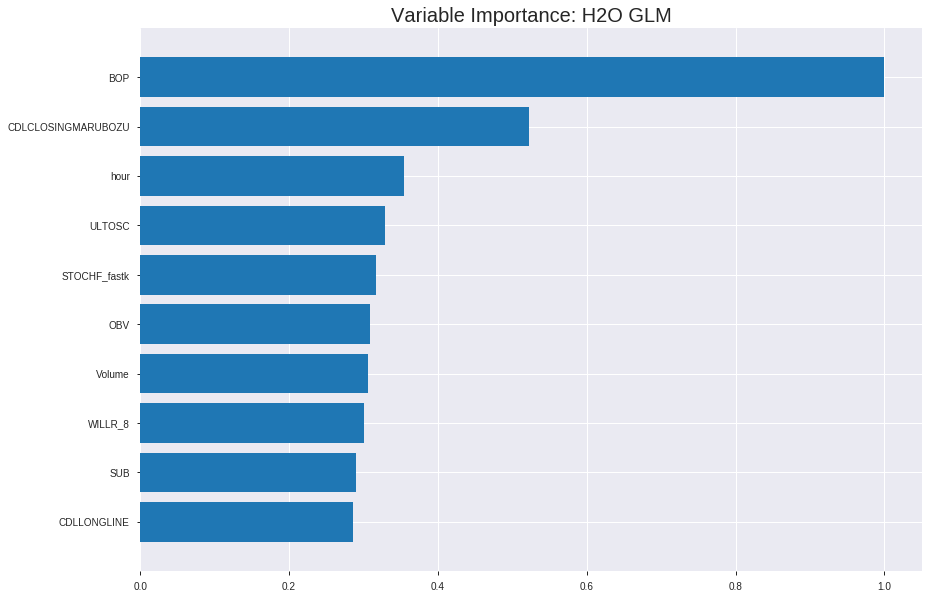

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_162657_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19237553431030505
RMSE: 0.4386063546168763
LogLoss: 0.565638343713596
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2154.759827525797
Residual deviance: 1760.2665256367106
AIC: 1862.2665256367106
AUC: 0.7780177833959866
pr_auc: 0.752231487496342
Gini: 0.5560355667919732
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42315921404918927: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      467  341  0.422    (341.0/808.0)
1      123  625  0.1644   (123.0/748.0)
Total  590  966  0.2982   (464.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423159     0.729288  236
max f2                       0.250033     0.8461    318
max f0point5                 0.578635     0.689891  148
max accuracy                 0.440606     0.707584  227
max precision                0.948309     1         0
max recall                   0.0428665    1         396
max specificity              0.948309     1         0
max absolute_mcc             0.440606     0.430206  227
max min_per_class_accuracy   0.497697     0.68984   196
max mean_per_class_accuracy  0.440606     0.711491  227

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.881961           2.08021   2.08021            1                0.904224  1                           0.904224            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.862119           1.69017   1.88519            0.8125           0.871485  0.90625                     0.887854            0.0173797       0.0387701                  69.0174   88.5194
    3        0.0302057                   0.845023           1.94153   1.90317            0.933333         0.855693  0.914894                    0.87759             0.0187166       0.0574866                  94.1533   90.3174
    4        0.0404884                   0.824256           1.9502    1.91512            0.9375           0.83324   0.920635                    0.866327            0.0200535       0.0775401                  95.0201   91.5118
    5        0.0501285                   0.808393           2.08021   1.94687            1                0.818822  0.935897                    0.857191            0.0200535       0.0975936                  108.021   94.6867
    6        0.100257                    0.748989           1.76018   1.85352            0.846154         0.775998  0.891026                    0.816595            0.0882353       0.185829                   76.0181   85.3524
    7        0.150386                    0.703688           1.60016   1.76907            0.769231         0.722711  0.850427                    0.7853              0.0802139       0.266043                   60.0165   76.9071
    8        0.200514                    0.660376           1.33347   1.66017            0.641026         0.682561  0.798077                    0.759615            0.0668449       0.332888                   33.347    66.0171
    9        0.300129                    0.605277           1.4226    1.58132            0.683871         0.633146  0.760171                    0.717639            0.141711        0.474599                   42.2598   58.1319
    10       0.400386                    0.552654           1.20012   1.48587            0.576923         0.577569  0.714286                    0.682565            0.120321        0.59492                    20.0123   48.5867
    11       0.5                         0.493177           1.04682   1.3984             0.503226         0.522284  0.672237                    0.650633            0.104278        0.699198                   4.68173   39.8396
    12       0.600257                    0.436556           1.20012   1.36528            0.576923         0.465082  0.656317                    0.619641            0.120321        0.819519                   20.0123   36.528
    13       0.699871                    0.361855           0.671037  1.26647            0.322581         0.398965  0.608815                    0.588232            0.0668449       0.886364                   -32.8963  26.6466
    14       0.800129                    0.291109           0.666735  1.19132            0.320513         0.327816  0.572691                    0.555601            0.0668449       0.953209                   -33.3265  19.1319
    15       0.899743                    0.182104           0.348939  1.09806            0.167742         0.240725  0.527857                    0.52074             0.0347594       0.987968                   -65.1061  9.80558
    16       1                           0.0262858          0.120012  1                  0.0576923        0.121563  0.48072                     0.48072           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20429352458918734
RMSE: 0.4519884120076391
LogLoss: 0.5950907602836327
Null degrees of freedom: 443
Residual degrees of freedom: 393
Null deviance: 612.6260558984648
Residual deviance: 528.4405951318658
AIC: 630.4405951318658
AUC: 0.7426930571223465
pr_auc: 0.6860321013459355
Gini: 0.4853861142446929
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4394499986088758: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      152  93   0.3796   (93.0/245.0)
1      41   158  0.206    (41.0/199.0)
Total  193  251  0.3018   (134.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43945      0.702222  223
max f2                       0.302461     0.821678  309
max f0point5                 0.43945      0.656692  223
max accuracy                 0.43945      0.698198  223
max precision                0.913422     1         0
max recall                   0.0690253    1         394
max specificity              0.913422     1         0
max absolute_mcc             0.43945      0.41571   223
max min_per_class_accuracy   0.501909     0.663317  183
max mean_per_class_accuracy  0.43945      0.707189  223

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 47.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.885703           2.23116   2.23116            1                0.901266  1                           0.901266            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.869298           1.67337   1.98325            0.75             0.879304  0.888889                    0.891505            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.840681           1.78492   1.91242            0.8              0.86013   0.857143                    0.8803              0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.808774           2.23116   1.98325            1                0.820293  0.888889                    0.866965            0.0201005       0.080402                   123.116   98.325
    5        0.0518018                   0.791486           1.78492   1.94014            0.8              0.800092  0.869565                    0.852427            0.0201005       0.100503                   78.4925   94.0135
    6        0.101351                    0.72663            1.82549   1.88409            0.818182         0.752322  0.844444                    0.803487            0.0904523       0.190955                   82.5491   88.4087
    7        0.150901                    0.68743            1.31841   1.69834            0.590909         0.705757  0.761194                    0.771396            0.0653266       0.256281                   31.841    69.8342
    8        0.20045                     0.658944           1.21699   1.57936            0.545455         0.670547  0.707865                    0.746467            0.0603015       0.316583                   21.6994   57.9357
    9        0.29955                     0.597413           1.21699   1.45948            0.545455         0.628378  0.654135                    0.7074              0.120603        0.437186                   21.6994   45.9478
    10       0.400901                    0.542346           1.33869   1.42894            0.6              0.567497  0.640449                    0.672031            0.135678        0.572864                   33.8693   42.8942
    11       0.5                         0.483613           1.11558   1.36683            0.5              0.512998  0.612613                    0.640511            0.110553        0.683417                   11.5578   36.6834
    12       0.599099                    0.414605           1.2677    1.35044            0.568182         0.452983  0.605263                    0.609492            0.125628        0.809045                   26.7702   35.0436
    13       0.70045                     0.355385           0.7933    1.26982            0.355556         0.384031  0.569132                    0.576869            0.080402        0.889447                   -20.67    26.9822
    14       0.79955                     0.284811           0.557789  1.18157            0.25             0.321785  0.529577                    0.545253            0.0552764       0.944724                   -44.2211  18.157
    15       0.898649                    0.201641           0.304249  1.08482            0.136364         0.245028  0.486216                    0.512145            0.0301508       0.974874                   -69.5751  8.48226
    16       1                           0.0307419          0.247906  1                  0.111111         0.129293  0.448198                    0.473343            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:26:58  0.000 sec   2            20        51            1.3697            1.3654
    2019-08-27 16:26:58  0.018 sec   4            12        51            1.36156           1.35773
    2019-08-27 16:26:58  0.035 sec   6            7.7       51            1.34981           1.34677
    2019-08-27 16:26:58  0.056 sec   8            4.8       51            1.33363           1.3319
    2019-08-27 16:26:58  0.081 sec   10           3         51            1.3126            1.31299
    2019-08-27 16:26:58  0.105 sec   12           1.9       51            1.28708           1.2907
    2019-08-27 16:26:58  0.123 sec   14           1.2       51            1.25852           1.26674
    2019-08-27 16:26:58  0.154 sec   16           0.71      51            1.22918           1.24346
    2019-08-27 16:26:58  0.174 sec   18           0.44      51            1.20158           1.22329
    2019-08-27 16:26:58  0.188 sec   20           0.28      51            1.1776            1.20779
    2019-08-27 16:26:58  0.202 sec   22           0.17      51            1.15806           1.19749
    2019-08-27 16:26:58  0.215 sec   24           0.11      51            1.14284           1.19191
    2019-08-27 16:26:58  0.232 sec   26           0.066     51            1.13128           1.19018
    2019-08-27 16:26:58  0.245 sec   28           0.041     51            1.12265           1.19126
    2019-08-27 16:26:58  0.262 sec   30           0.025     51            1.11631           1.19411
    2019-08-27 16:26:58  0.283 sec   32           0.016     51            1.11169           1.19784
    2019-08-27 16:26:58  0.298 sec   34           0.0098    51            1.10836           1.20181
    2019-08-27 16:26:58  0.316 sec   36           0.0061    51            1.10597           1.20569

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.7124463519313305)

('auc', 0.7656402737047898)

('logloss', 0.5849757017666886)

('mean_per_class_error', 0.27847018572825033)

('rmse', 0.44585112313160746)

('mse', 0.1987832239977158)

glm prediction progress: |████████████████████████████████████████████████| 100%


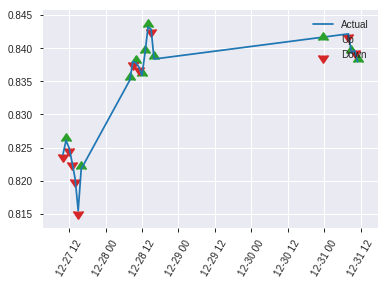


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1987832239977158
RMSE: 0.44585112313160746
LogLoss: 0.5849757017666886
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 307.54649216112034
Residual deviance: 260.8991629879431
AIC: 362.8991629879431
AUC: 0.7656402737047898
pr_auc: 0.6844605751611212
Gini: 0.5312805474095796
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4073490724927064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   51   0.4113   (51.0/124.0)
1      16   83   0.1616   (16.0/99.0)
Total  89   134  0.3004   (67.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407349     0.712446  133
max f2                       0.271024     0.824561  173
max f0point5                 0.554057     0.689223  74
max accuracy                 0.466267     0.717489  109
max precision                0.913677     1         0
max recall                   0.0812239    1         220
max specificity              0.913677     1         0
max absolute_mcc             0.45218      0.440377  113
max min_per_class_accuracy   0.470376     0.701613  106
max mean_per_class_accuracy  0.45218      0.72153   113

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 45.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.886672           2.25253   2.25253            1                0.904572  1                           0.904572            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.845691           1.12626   1.80202            0.5              0.849338  0.8                         0.882478            0.010101        0.040404                   12.6263   80.202
    3        0.0313901                   0.801578           1.12626   1.60895            0.5              0.823952  0.714286                    0.865757            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.792261           2.25253   1.75196            1                0.797101  0.777778                    0.8505              0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.787236           1.50168   1.68939            0.666667         0.790542  0.75                        0.83551             0.020202        0.0909091                  50.1684   68.9394
    6        0.103139                    0.704452           1.84298   1.76285            0.818182         0.730405  0.782609                    0.785243            0.0909091       0.181818                   84.2975   76.2846
    7        0.152466                    0.650129           1.6382    1.72252            0.727273         0.677427  0.764706                    0.750361            0.0808081       0.262626                   63.82     72.2519
    8        0.201794                    0.617949           1.02388   1.55174            0.454545         0.636654  0.688889                    0.722566            0.0505051       0.313131                   2.38751   55.174
    9        0.300448                    0.573516           1.94536   1.68099            0.863636         0.592383  0.746269                    0.679819            0.191919        0.505051                   94.5363   68.0989
    10       0.399103                    0.520389           1.12626   1.54387            0.5              0.545274  0.685393                    0.646561            0.111111        0.616162                   12.6263   54.3866
    11       0.502242                    0.464533           1.17523   1.46816            0.521739         0.491382  0.651786                    0.614694            0.121212        0.737374                   17.5231   46.8164
    12       0.600897                    0.406812           1.02388   1.39522            0.454545         0.429733  0.619403                    0.584327            0.10101         0.838384                   2.38751   39.5221
    13       0.699552                    0.338927           0.511938  1.27066            0.227273         0.380409  0.564103                    0.555569            0.0505051       0.888889                   -48.8062  27.0655
    14       0.798206                    0.25054            0.614325  1.18954            0.272727         0.301799  0.52809                     0.524205            0.0606061       0.949495                   -38.5675  18.9536
    15       0.896861                    0.16767            0.102388  1.06995            0.0454545        0.220233  0.475                       0.490768            0.010101        0.959596                   -89.7612  6.99495
    16       1                           0.00876944         0.391744  1                  0.173913         0.115868  0.443946                    0.452101           

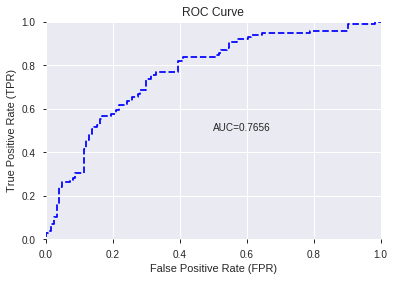

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


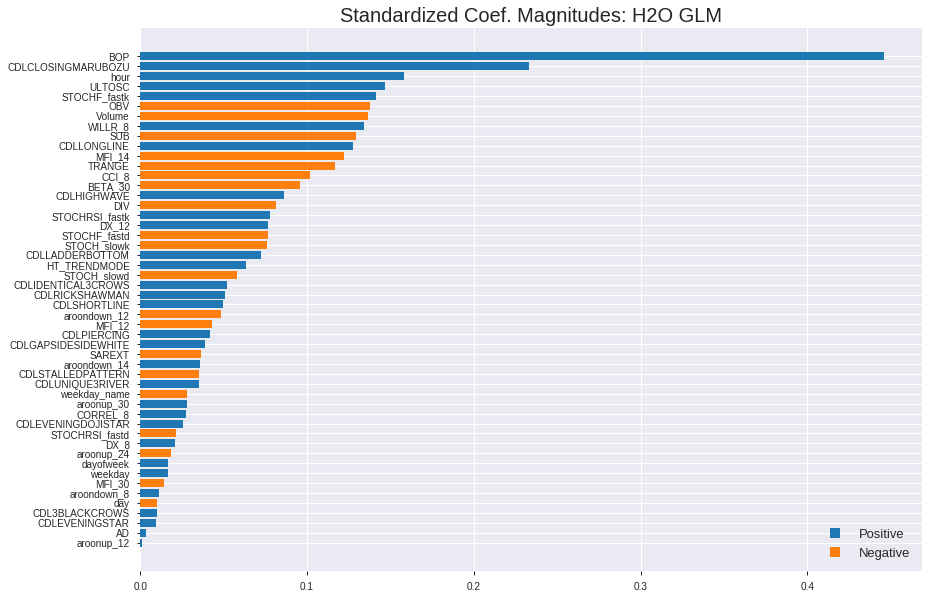

'log_likelihood'
--2019-08-27 16:27:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


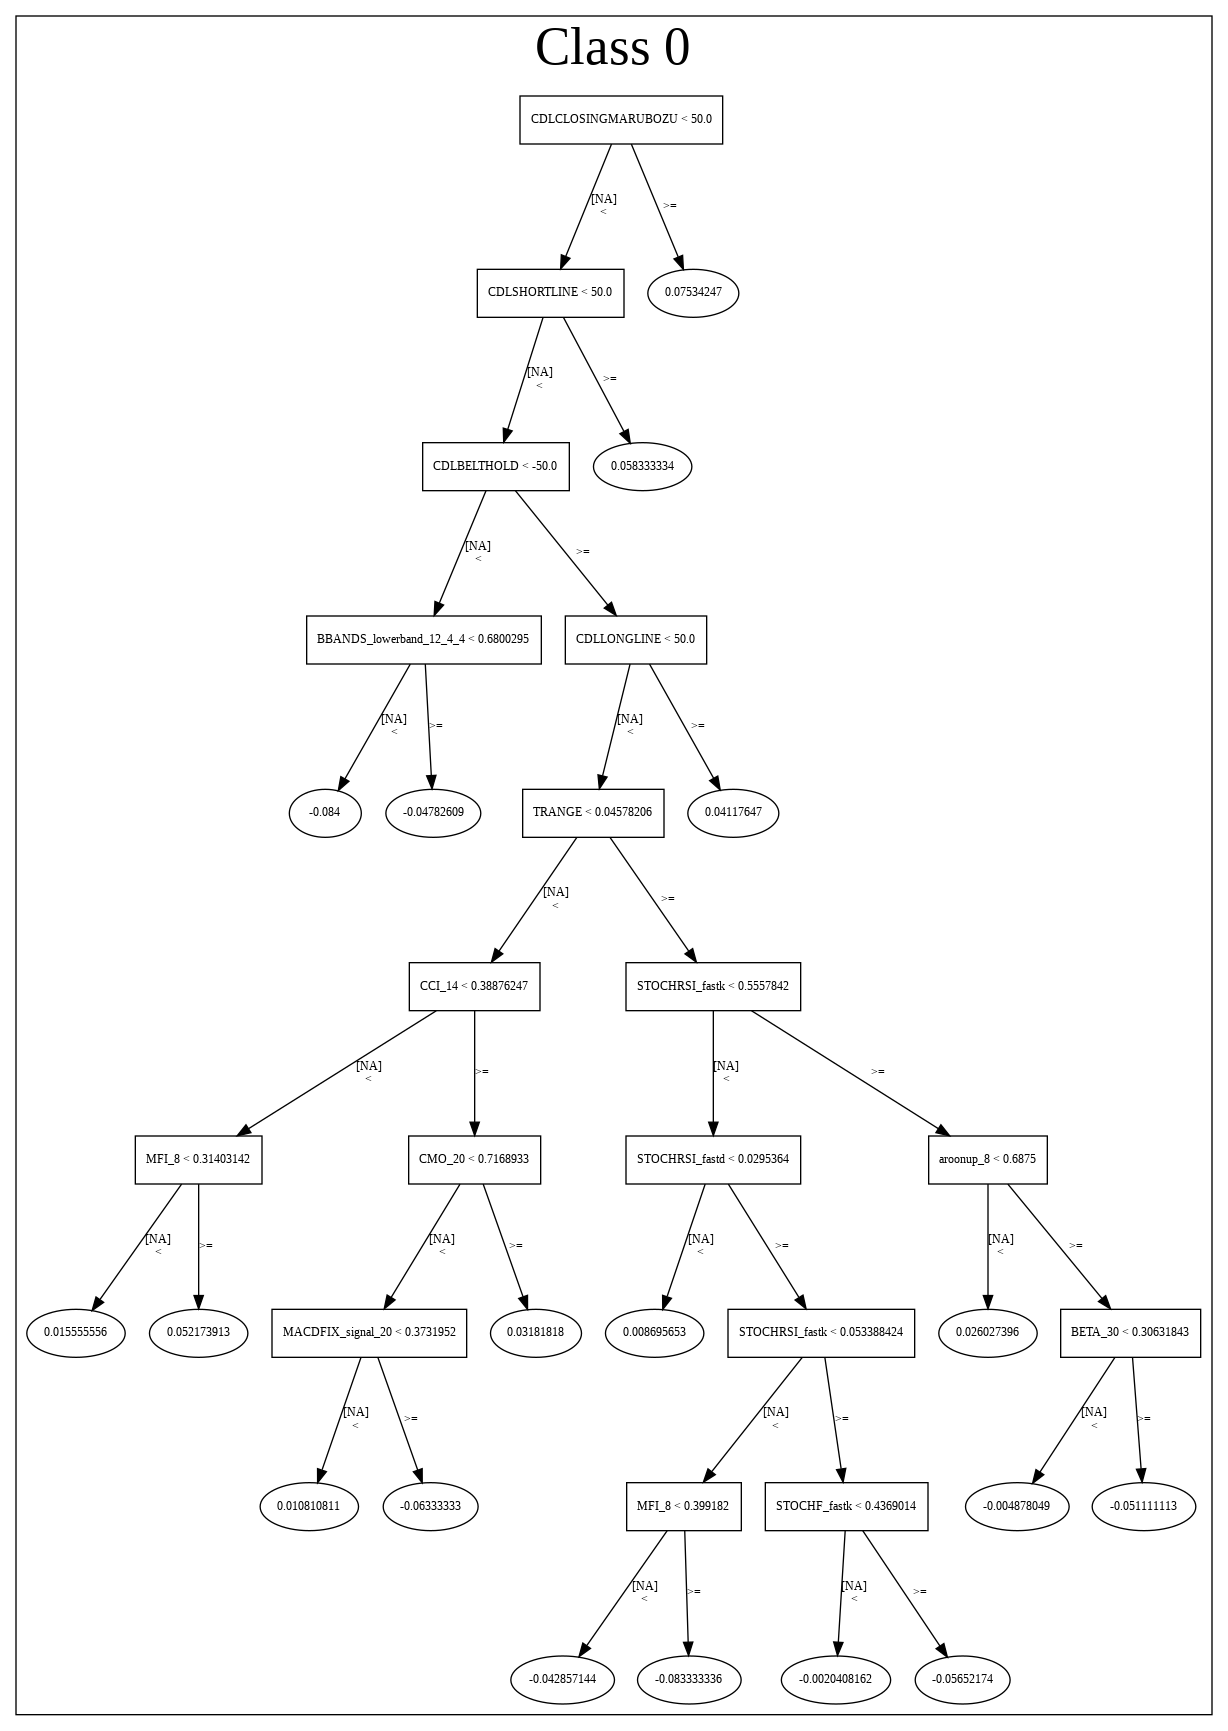

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_162657_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_162657_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'ULTOSC',
 'STOCHF_fastk',
 'OBV',
 'Volume',
 'WILLR_8',
 'SUB',
 'CDLLONGLINE',
 'MFI_14',
 'TRANGE',
 'CCI_8',
 'BETA_30',
 'CDLHIGHWAVE',
 'DIV',
 'STOCHRSI_fastk',
 'DX_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLLADDERBOTTOM',
 'HT_TRENDMODE',
 'STOCH_slowd',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'aroondown_12',
 'MFI_12',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'SAREXT',
 'aroondown_14',
 'CDLSTALLEDPATTERN',
 'CDLUNIQUE3RIVER',
 'weekday_name',
 'aroonup_30',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastd',
 'DX_8',
 'aroonup_24',
 'dayofweek',
 'weekday',
 'MFI_30',
 'aroondown_8',
 'day',
 'CDL3BLACKCROWS',
 'CDLEVENINGSTAR',
 'AD',
 'aroonup_12']

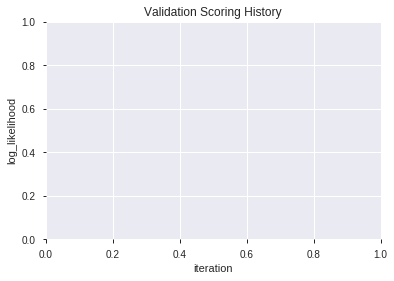

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_162715_model_4  0.781240  0.560085              0.254154  0.435478  0.189641
1               XGBoost_2_AutoML_20190827_162715  0.769632  0.568890              0.247149  0.438936  0.192664
2  XGBoost_grid_1_AutoML_20190827_162715_model_6  0.766129  0.565388              0.255173  0.438757  0.192508
3               XGBoost_1_AutoML_20190827_162715  0.763115  0.570047              0.256150  0.441428  0.194859
4  XGBoost_grid_1_AutoML_20190827_162715_model_3  0.762219  0.573769              0.268288  0.442780  0.196054
5  XGBoost_grid_1_AutoML_20190827_162715_model_2  0.758635  0.587448              0.260223  0.448676  0.201311
6  XGBoost_grid_1_AutoML_20190827_162715_model_7  0.758553  0.577975              0.260182  0.445063  0.198081
7               XGBoost_3_AutoML_20190827_162715  0.757250  0.572920              0.255213  0.442843  0.196110
8  XGBoost_grid_1_AutoML_20190827_162715_model_1  0.745031  0.575886              0.289427  0.445531  0.198497
9  XGBoost_grid_1_AutoML_20190827_162715_model_5  0.736070  0.605595              0.308610  0.456843  0.208706

variable  relative_importance  scaled_importance  percentage
0              BOP          2025.784912           1.000000    0.430862
1              DIV           347.190033           0.171385    0.073844
2           TRANGE           316.381989           0.156177    0.067291
3             hour           201.312042           0.099375    0.042817
4            CCI_8           141.003479           0.069604    0.029990
5              OBV           124.670517           0.061542    0.026516
6           MFI_12           119.067848           0.058776    0.025324
7           Volume           106.982132           0.052810    0.022754
8          BETA_30           104.284821           0.051479    0.022180
9           MFI_14            98.433273           0.048590    0.020936
10          ULTOSC            90.828270           0.044836    0.019318
11             SUB            90.471161           0.044660    0.019242
12    STOCHF_fastk            90.366539           0.044608    0.019220
13           DX_12            82.189468           0.040572    0.017481
14         WILLR_8            72.025467           0.035554    0.015319
15  STOCHRSI_fastd            69.832977           0.034472    0.014853
16     STOCH_slowd            64.724266           0.031950    0.013766
17      aroonup_30            60.730423           0.029979    0.012917
18            DX_8            59.414108           0.029329    0.012637
19     STOCH_slowk            49.038719           0.024207    0.010430
20        CORREL_8            45.270714           0.022347    0.009629
21              AD            39.969254           0.019730    0.008501
22  STOCHRSI_fastk            36.157669           0.017849    0.007690
23          SAREXT            34.608341           0.017084    0.007361
24      aroonup_12            31.496977           0.015548    0.006699
25             day            29.311165           0.014469    0.006234
26          MFI_30            26.303879           0.012985    0.005595
27    weekday_name            24.144022           0.011918    0.005135
28       dayofweek            23.991123           0.011843    0.005103
29    HT_TRENDMODE            23.490681           0.011596    0.004996
30    aroondown_14            22.613626           0.011163    0.004810
31     aroondown_8            21.945757           0.010833    0.004668
32      aroonup_24            17.735184           0.008755    0.003772
33     CDLLONGLINE             9.927845           0.004901    0.002112

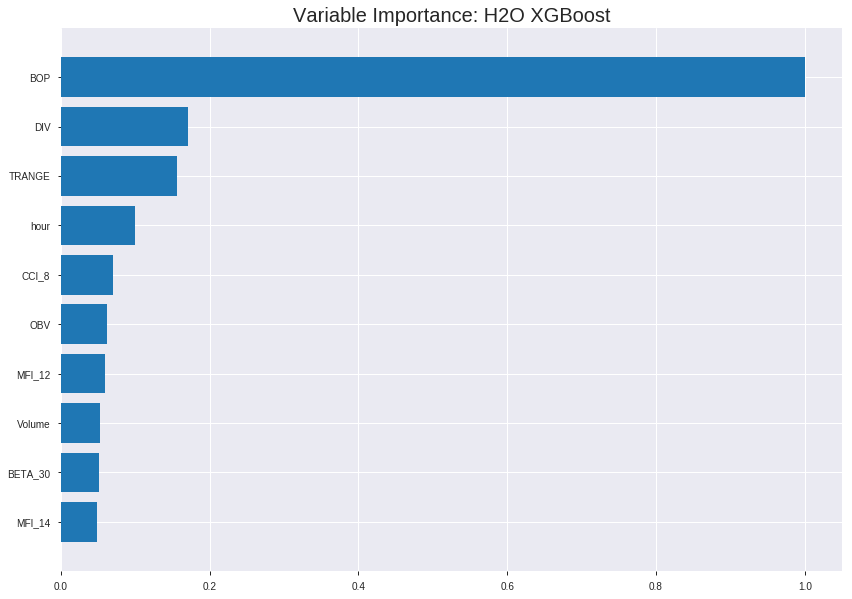

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_162715_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1738817971622329
RMSE: 0.4169913634144392
LogLoss: 0.5246630896191686
Mean Per-Class Error: 0.2523991369725208
AUC: 0.830799624080055
pr_auc: 0.8106010452607723
Gini: 0.6615992481601101
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3922236959139506: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      441  367   0.4542   (367.0/808.0)
1      68   680   0.0909   (68.0/748.0)
Total  509  1047  0.2796   (435.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392224     0.75766   252
max f2                       0.273132     0.85867   306
max f0point5                 0.598705     0.755     136
max accuracy                 0.528592     0.747429  179
max precision                0.850265     1         0
max recall                   0.131041     1         376
max specificity              0.850265     1         0
max absolute_mcc             0.501661     0.494966  192
max min_per_class_accuracy   0.517337     0.74505   185
max mean_per_class_accuracy  0.501661     0.747601  192

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.812115           1.9502     1.9502             0.9375           0.83111   0.9375                      0.83111             0.0200535       0.0200535                  95.0201   95.0201
    2        0.0205656                   0.799965           2.08021    2.01521            1                0.804199  0.96875                     0.817655            0.0213904       0.0414439                  108.021   101.521
    3        0.0302057                   0.789244           2.08021    2.03595            1                0.79308   0.978723                    0.809812            0.0200535       0.0614973                  108.021   103.595
    4        0.0404884                   0.780775           1.9502     2.01418            0.9375           0.785151  0.968254                    0.803549            0.0200535       0.0815508                  95.0201   101.418
    5        0.0501285                   0.768203           2.08021    2.02688            1                0.773558  0.974359                    0.797781            0.0200535       0.101604                   108.021   102.688
    6        0.100257                    0.747241           1.86686    1.94687            0.897436         0.758232  0.935897                    0.778007            0.0935829       0.195187                   86.6859   94.6867
    7        0.150386                    0.718148           1.60016    1.8313             0.769231         0.732526  0.880342                    0.762846            0.0802139       0.275401                   60.0165   83.1299
    8        0.200514                    0.691982           1.78685    1.82019            0.858974         0.706651  0.875                       0.748797            0.0895722       0.364973                   78.685    82.0187
    9        0.300129                    0.630738           1.54338    1.72831            0.741935         0.66227   0.830835                    0.720079            0.153743        0.518717                   54.3385   72.8315
    10       0.400386                    0.574186           1.22679    1.60273            0.589744         0.602867  0.770465                    0.690729            0.122995        0.641711                   22.6793   60.2733
    11       0.5                         0.510313           1.12734    1.50802            0.541935         0.542194  0.724936                    0.661136            0.112299        0.754011                   12.7342   50.8021
    12       0.600257                    0.444221           0.866756   1.40091            0.416667         0.476057  0.673448                    0.630224            0.0868984       0.840909                   -13.3244  40.0915
    13       0.699871                    0.36119            0.818665   1.31804            0.393548         0.406991  0.633609                    0.59845             0.0815508       0.92246                    -18.1335  31.8042
    14       0.800129                    0.252126           0.466715   1.21137            0.224359         0.311893  0.582329                    0.562544            0.0467914       0.969251                   -53.3285  21.137
    15       0.899743                    0.155753           0.254994   1.10549            0.122581         0.196145  0.531429                    0.521979            0.0254011       0.994652                   -74.5006  10.5485
    16       1                           0.0769123          0.0533388  1                  0.025641         0.12518   0.48072                     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20314479949701933
RMSE: 0.4507158744675179
LogLoss: 0.5910089384124473
Mean Per-Class Error: 0.30301507537688444
AUC: 0.7442108501692134
pr_auc: 0.678993341971444
Gini: 0.4884217003384268
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3966448903083801: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  115  0.4694   (115.0/245.0)
1      30   169  0.1508   (30.0/199.0)
Total  160  284  0.3266   (145.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396645     0.699793  254
max f2                       0.142879     0.820957  373
max f0point5                 0.529378     0.658561  176
max accuracy                 0.529378     0.693694  176
max precision                0.826686     1         0
max recall                   0.142879     1         373
max specificity              0.826686     1         0
max absolute_mcc             0.440591     0.396528  229
max min_per_class_accuracy   0.50839      0.681633  192
max mean_per_class_accuracy  0.440591     0.696985  229

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 46.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.795732           1.78492   1.78492            0.8              0.814698  0.8                         0.814698            0.0201005       0.0201005                  78.4925   78.4925
    2        0.0202703                   0.786914           2.23116   1.98325            1                0.791951  0.888889                    0.804588            0.0201005       0.040201                   123.116   98.325
    3        0.0315315                   0.778509           1.78492   1.91242            0.8              0.7841    0.857143                    0.797271            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.769896           1.67337   1.8593             0.75             0.775934  0.833333                    0.79253             0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.758239           1.33869   1.74612            0.6              0.763231  0.782609                    0.78616             0.0150754       0.0904523                  33.8693   74.6122
    6        0.101351                    0.726942           1.92691   1.83451            0.863636         0.742259  0.822222                    0.764697            0.0954774       0.18593                    92.6907   83.4506
    7        0.150901                    0.688008           1.41983   1.69834            0.636364         0.708852  0.761194                    0.74636             0.0703518       0.256281                   41.9826   69.8342
    8        0.20045                     0.666419           1.31841   1.60443            0.590909         0.676958  0.719101                    0.729204            0.0653266       0.321608                   31.841    60.4427
    9        0.29955                     0.620173           1.21699   1.47625            0.545455         0.642529  0.661654                    0.70053             0.120603        0.442211                   21.6994   47.6253
    10       0.400901                    0.554687           1.48744   1.47908            0.666667         0.584311  0.662921                    0.671149            0.150754        0.592965                   48.7437   47.9081
    11       0.5                         0.494537           1.06487   1.39698            0.477273         0.526907  0.626126                    0.64256             0.105528        0.698492                   6.48698   39.6985
    12       0.599099                    0.424953           1.06487   1.34205            0.477273         0.459133  0.601504                    0.612219            0.105528        0.80402                    6.48698   34.2049
    13       0.70045                     0.318154           0.694137  1.2483             0.311111         0.378604  0.559486                    0.578416            0.0703518       0.874372                   -30.5863  24.8299
    14       0.79955                     0.203414           0.557789  1.16271            0.25             0.253394  0.521127                    0.538132            0.0552764       0.929648                   -44.2211  16.2715
    15       0.898649                    0.160833           0.456373  1.08482            0.204545         0.183203  0.486216                    0.498992            0.0452261       0.974874                   -54.3627  8.48226
    16       1                           0.0960377          0.247906  1                  0.111111         0.134384  0.448198                    0.462038          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:27:24  4.041 sec   0                  0.5              0.693147            0.5             0                  1                0.51928                          0.5                0.693147              0.5               0                    1                  0.551802
    2019-08-27 16:27:24  4.153 sec   5                  0.477967         0.64975             0.782479        0.744092           1.82019          0.327121                         0.481202           0.655988              0.734971          0.652326             1.78492            0.369369
    2019-08-27 16:27:24  4.218 sec   10                 0.462807         0.620057            0.788747        0.758226           1.9502           0.318766                         0.469909           0.633568              0.735678          0.666958             1.78492            0.364865
    2019-08-27 16:27:24  4.283 sec   15                 0.452665         0.599818            0.79717         0.77008            1.9502           0.30527                          0.463743           0.620783              0.730776          0.664673             1.78492            0.369369
    2019-08-27 16:27:25  4.360 sec   20                 0.445208         0.584415            0.799045        0.77243            1.9502           0.298843                         0.458805           0.610265              0.737083          0.675296             2.23116            0.337838
    2019-08-27 16:27:25  4.429 sec   25                 0.439898         0.573047            0.802169        0.777421           1.9502           0.296915                         0.456625           0.604983              0.736478          0.674443             2.23116            0.333333
    2019-08-27 16:27:25  4.499 sec   30                 0.435625         0.563898            0.805086        0.78089            1.9502           0.298843                         0.454902           0.600784              0.737083          0.678004             2.23116            0.362613
    2019-08-27 16:27:25  4.572 sec   35                 0.431381         0.554912            0.810275        0.787684           2.08021          0.287275                         0.45373            0.597971              0.73694           0.672618             2.23116            0.333333
    2019-08-27 16:27:25  4.647 sec   40                 0.427861         0.547387            0.81473         0.794058           2.08021          0.298843                         0.453137           0.59649               0.737596          0.671939             2.23116            0.342342
    2019-08-27 16:27:25  4.723 sec   45                 0.424882         0.540848            0.81789         0.796418           1.9502           0.296915                         0.452258           0.594425              0.740057          0.675346             2.23116            0.34009
    2019-08-27 16:27:25  4.798 sec   50                 0.421883         0.534701            0.823176        0.802764           1.9502           0.291774                         0.45228            0.594154              0.738745          0.67151              2.23116            0.333333
    2019-08-27 16:27:25  4.879 sec   55                 0.419315         0.529281            0.826969        0.805437           1.9502           0.287918                         0.451218           0.59204               0.74177           0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2025.784912109375      1.0                    0.43086234350756253
DIV           347.1900329589844      0.1713854372611889     0.07384353114142418
TRANGE        316.3819885253906      0.15617748292732309    0.06729099629717876
hour          201.31204223632812     0.09937483541957538    0.04281687447455658
CCI_8         141.00347900390625     0.06960436824316385    0.02998990121961294
---           ---                    ---                    ---
HT_TRENDMODE  23.490680694580078     0.011595841470711766   0.004996211431013051
aroondown_14  22.61362648010254      0.01116289609273267    0.004809671570846212
aroondown_8   21.945756912231445     0.01083321174970157    0.004667623002190081
aroonup_24    17.735183715820312     0.008754721989390927   0.003772080033106165
CDLLONGLINE   9.927845001220703      0.0049007399264728475  0.0021115442896411708


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.7435897435897436)

('auc', 0.78123981753014)

('logloss', 0.5600849506251333)

('mean_per_class_error', 0.25317693059628543)

('rmse', 0.4354783580629675)

('mse', 0.1896414003412181)

xgboost prediction progress: |████████████████████████████████████████████| 100%


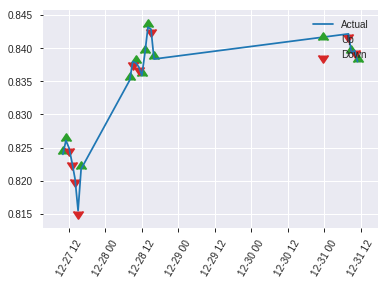


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1896414003412181
RMSE: 0.4354783580629675
LogLoss: 0.5600849506251333
Mean Per-Class Error: 0.25317693059628543
AUC: 0.78123981753014
pr_auc: 0.6776899264700924
Gini: 0.5624796350602801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42870622873306274: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   48   0.3871   (48.0/124.0)
1      12   87   0.1212   (12.0/99.0)
Total  88   135  0.2691   (60.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428706     0.74359   134
max f2                       0.201629     0.846154  187
max f0point5                 0.514948     0.688337  105
max accuracy                 0.47723      0.735426  127
max precision                0.732058     0.833333  17
max recall                   0.201629     1         187
max specificity              0.822759     0.991935  0
max absolute_mcc             0.428706     0.499819  134
max min_per_class_accuracy   0.514948     0.725806  105
max mean_per_class_accuracy  0.47723      0.746823  127

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 46.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.781559           1.50168   1.50168            0.666667         0.808753  0.666667                    0.808753            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.767745           1.12626   1.35152            0.5              0.771558  0.6                         0.793875            0.010101        0.030303                   12.6263   35.1515
    3        0.0313901                   0.764513           2.25253   1.60895            1                0.76658   0.714286                    0.786076            0.020202        0.0505051                  125.253   60.8947
    4        0.0403587                   0.76269            1.12626   1.50168            0.5              0.763742  0.666667                    0.781113            0.010101        0.0606061                  12.6263   50.1684
    5        0.0538117                   0.757791           2.25253   1.68939            1                0.761007  0.75                        0.776087            0.030303        0.0909091                  125.253   68.9394
    6        0.103139                    0.712535           1.6382    1.66491            0.727273         0.730849  0.73913                     0.754451            0.0808081       0.171717                   63.82     66.491
    7        0.152466                    0.673247           1.84298   1.72252            0.818182         0.689113  0.764706                    0.733312            0.0909091       0.262626                   84.2975   72.2519
    8        0.201794                    0.655792           1.6382    1.70191            0.727273         0.664617  0.755556                    0.71652             0.0808081       0.343434                   63.82     70.1908
    9        0.300448                    0.600623           1.12626   1.51289            0.5              0.6279    0.671642                    0.687421            0.111111        0.454545                   12.6263   51.289
    10       0.399103                    0.548856           1.43343   1.49325            0.636364         0.58002   0.662921                    0.660872            0.141414        0.59596                    43.3425   49.3247
    11       0.502242                    0.512347           1.46904   1.48828            0.652174         0.525512  0.660714                    0.633075            0.151515        0.747475                   46.9038   48.8276
    12       0.600897                    0.446701           1.22865   1.44565            0.545455         0.486003  0.641791                    0.608929            0.121212        0.868687                   22.865    44.5651
    13       0.699552                    0.345072           0.511938  1.31397            0.227273         0.380314  0.583333                    0.576688            0.0505051       0.919192                   -48.8062  31.3973
    14       0.798206                    0.223142           0.40955   1.20219            0.181818         0.27401   0.533708                    0.539279            0.040404        0.959596                   -59.045   20.219
    15       0.896861                    0.170379           0.40955   1.115              0.181818         0.19682   0.495                       0.501608            0.040404        1                          -59.045   11.5
    16       1                           0.0997965          0         1                  0                0.137617  0.443946                    0.464067            0  

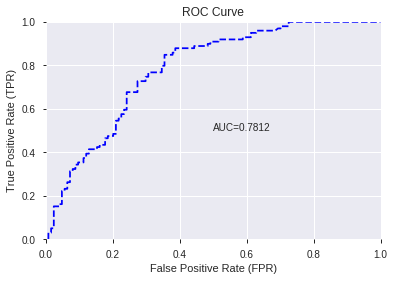

This function is available for GLM models only


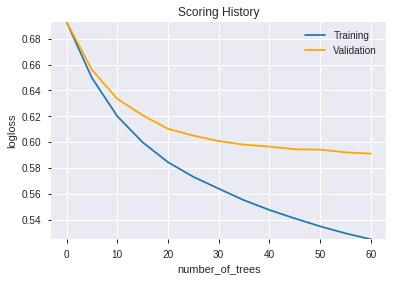

--2019-08-27 16:27:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

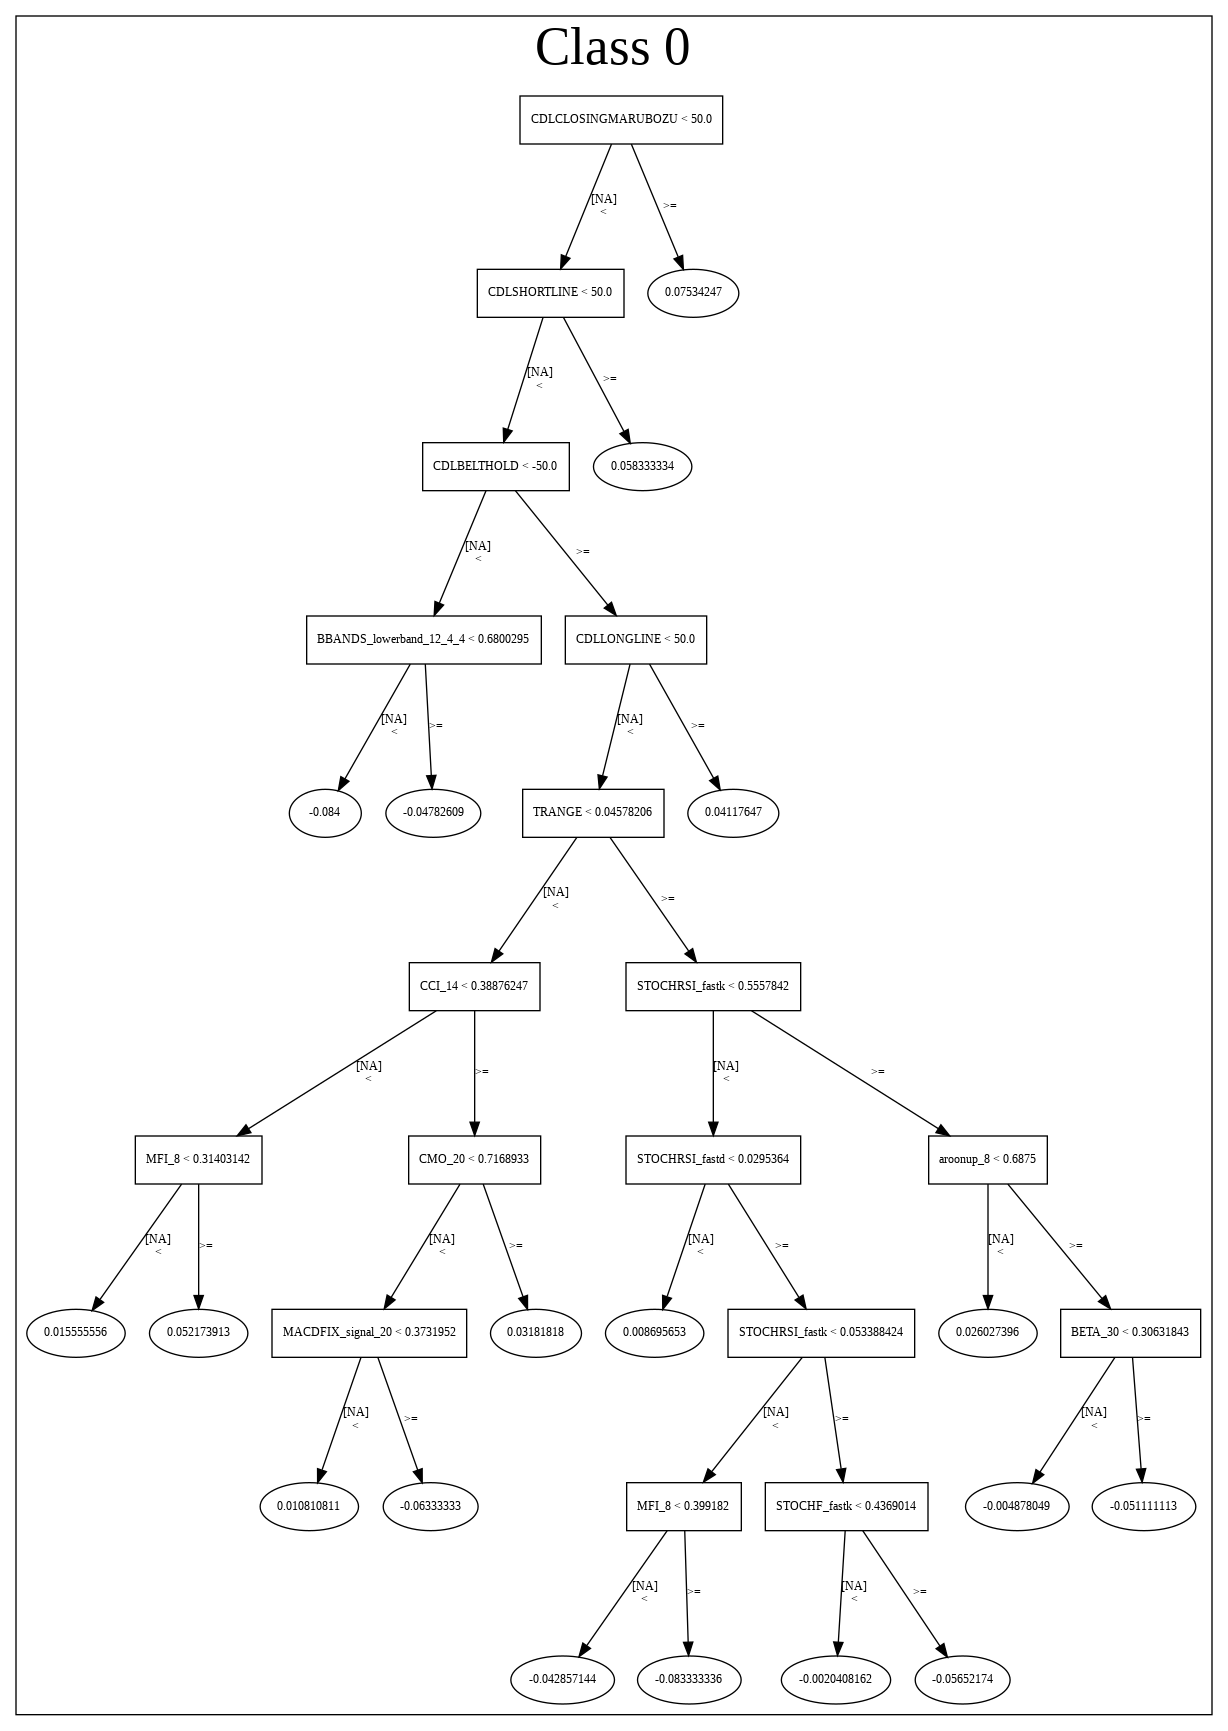

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_162715_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_162715_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'TRANGE',
 'hour',
 'CCI_8',
 'OBV',
 'MFI_12',
 'Volume',
 'BETA_30',
 'MFI_14',
 'ULTOSC',
 'SUB',
 'STOCHF_fastk',
 'DX_12',
 'WILLR_8',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'aroonup_30',
 'DX_8',
 'STOCH_slowk',
 'CORREL_8',
 'AD',
 'STOCHRSI_fastk',
 'SAREXT',
 'aroonup_12',
 'day',
 'MFI_30',
 'weekday_name',
 'dayofweek',
 'HT_TRENDMODE',
 'aroondown_14',
 'aroondown_8',
 'aroonup_24',
 'CDLLONGLINE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12 13] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


26

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_162751_model_5  0.794721  0.561336              0.258309  0.434702  0.188966
1               DeepLearning_1_AutoML_20190827_162751  0.789834  0.567234              0.264296  0.435757  0.189884
2  DeepLearning_grid_1_AutoML_20190827_162751_model_8  0.786820  0.579501              0.285435  0.444034  0.197166
3  DeepLearning_grid_1_AutoML_20190827_162751_model_4  0.783236  0.574389              0.295495  0.436868  0.190854
4  DeepLearning_grid_1_AutoML_20190827_162751_model_6  0.780955  0.573533              0.296514  0.441800  0.195187
5  DeepLearning_grid_1_AutoML_20190827_162751_model_9  0.771180  0.587757              0.270324  0.444754  0.197807
6  DeepLearning_grid_1_AutoML_20190827_162751_model_7  0.759286  0.644834              0.311584  0.455808  0.207761
7  DeepLearning_grid_1_AutoML_20190827_162751_model_3  0.740551  0.691168              0.325717  0.457751  0.209536
8  DeepLearning_grid_1_AutoML_20190827_162751_model_2  0.721978  0.672839              0.322744  0.470715  0.221572
9  DeepLearning_grid_1_AutoML_20190827_162751_model_1  0.692571  0.815924              0.397239  0.505877  0.255911

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.074358
1   CDLCLOSINGMARUBOZU             0.694043           0.694043    0.051607
2                  DIV             0.611261           0.611261    0.045452
3                  SUB             0.599820           0.599820    0.044601
4               TRANGE             0.599030           0.599030    0.044542
5          CDLLONGLINE             0.577229           0.577229    0.042921
6                 hour             0.573018           0.573018    0.042608
7         CDLSHORTLINE             0.551405           0.551405    0.041001
8       STOCHRSI_fastk             0.527197           0.527197    0.039201
9         STOCHF_fastk             0.509310           0.509310    0.037871
10               CCI_8             0.493665           0.493665    0.036708
11             WILLR_8             0.491155           0.491155    0.036521
12              ULTOSC             0.473789           0.473789    0.035230
13         CDLMARUBOZU             0.465096           0.465096    0.034583
14            WILLR_12             0.461937           0.461937    0.034349
15        CDLENGULFING             0.456789           0.456789    0.033966
16         CDLBELTHOLD             0.455703           0.455703    0.033885
17            WILLR_20             0.450656           0.450656    0.033510
18              CMO_12             0.449679           0.449679    0.033437
19            WILLR_24             0.439519           0.439519    0.032682
20            WILLR_14             0.437964           0.437964    0.032566
21               RSI_8             0.437304           0.437304    0.032517
22              CMO_14             0.432948           0.432948    0.032193
23              RSI_14             0.426842           0.426842    0.031739
24               CMO_8             0.422123           0.422123    0.031388
25              RSI_12             0.411042           0.411042    0.030564

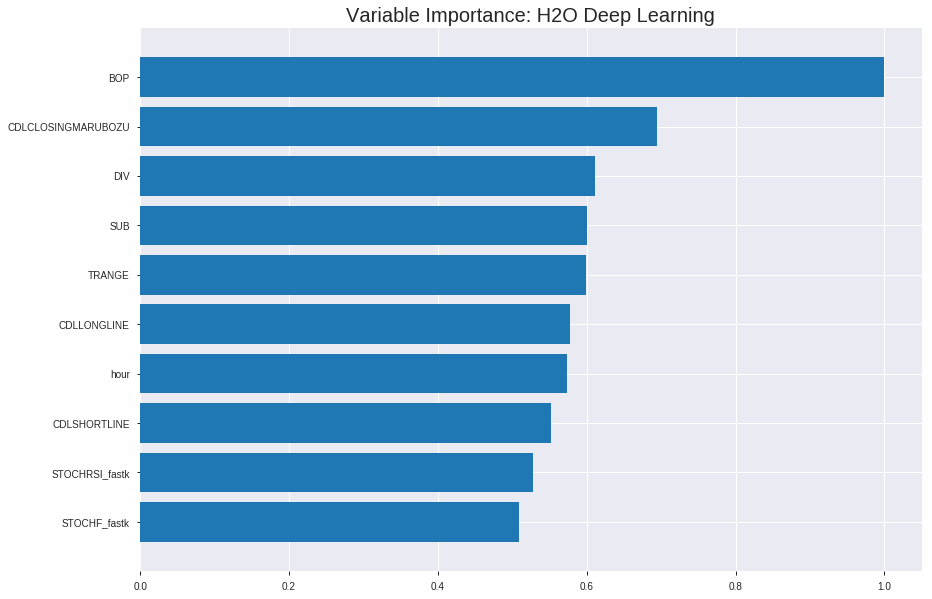

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_162751_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19617284607614627
RMSE: 0.4429140391499758
LogLoss: 0.5710084809190158
Mean Per-Class Error: 0.30635159104145715
AUC: 0.7664646979403822
pr_auc: 0.7433076135706733
Gini: 0.5329293958807644
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3346493841954444: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      369  439   0.5433   (439.0/808.0)
1      73   675   0.0976   (73.0/748.0)
Total  442  1114  0.329    (512.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334649     0.725027  264
max f2                       0.096816     0.845167  354
max f0point5                 0.506837     0.673712  165
max accuracy                 0.464422     0.688946  198
max precision                0.960176     1         0
max recall                   0.015647     1         395
max specificity              0.960176     1         0
max absolute_mcc             0.391451     0.405791  239
max min_per_class_accuracy   0.475335     0.683168  190
max mean_per_class_accuracy  0.39678      0.693648  236

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 43.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.902101           2.08021   2.08021            1                0.915966   1                           0.915966            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.886238           1.9502    2.01521            0.9375           0.893776   0.96875                     0.904871            0.0200535       0.0414439                  95.0201   101.521
    3        0.0302057                   0.868244           1.94153   1.99169            0.933333         0.879063   0.957447                    0.896635            0.0187166       0.0601604                  94.1533   99.1694
    4        0.0404884                   0.848109           1.56016   1.8821             0.75             0.860171   0.904762                    0.887374            0.0160428       0.0762032                  56.016    88.2098
    5        0.0501285                   0.830757           1.94153   1.89353            0.933333         0.838085   0.910256                    0.877895            0.0187166       0.0949198                  94.1533   89.3528
    6        0.100257                    0.716681           1.76018   1.82685            0.846154         0.764017   0.878205                    0.820956            0.0882353       0.183155                   76.0181   82.6855
    7        0.150386                    0.660882           1.5735    1.7424             0.75641          0.689449   0.837607                    0.77712             0.078877        0.262032                   57.3495   74.2401
    8        0.200514                    0.61219            1.46682   1.67351            0.705128         0.637785   0.804487                    0.742287            0.0735294       0.335561                   46.6817   67.3505
    9        0.300129                    0.527156           1.20787   1.51896            0.580645         0.563873   0.730193                    0.68307             0.120321        0.455882                   20.7866   51.8957
    10       0.400386                    0.495116           1.22679   1.4458             0.589744         0.511049   0.695024                    0.639996            0.122995        0.578877                   22.6793   44.5799
    11       0.5                         0.470355           1.11392   1.37968            0.535484         0.485254   0.663239                    0.609167            0.110963        0.68984                    11.3921   37.9679
    12       0.600257                    0.42973            1.05344   1.32519            0.50641          0.452257   0.637045                    0.582959            0.105615        0.795455                   5.34417   32.519
    13       0.699871                    0.352787           0.926031  1.26838            0.445161         0.393762   0.609734                    0.55603             0.092246        0.887701                   -7.39693  26.8377
    14       0.800129                    0.20167            0.613396  1.18631            0.294872         0.288579   0.570281                    0.522518            0.0614973       0.949198                   -38.6604  18.6307
    15       0.899743                    0.079629           0.389201  1.09806            0.187097         0.13344    0.527857                    0.479442            0.0387701       0.987968                   -61.0799  9.80558
    16       1                           0.00508034         0.120012  1                  0.0576923        0.0404172  0.48072                     



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2022098943803827
RMSE: 0.44967754489231804
LogLoss: 0.59511113623355
Mean Per-Class Error: 0.3003589375448672
AUC: 0.7538508870885038
pr_auc: 0.6728141496214987
Gini: 0.5077017741770076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2896768175289241: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      110  135  0.551    (135.0/245.0)
1      18   181  0.0905   (18.0/199.0)
Total  128  316  0.3446   (153.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289677     0.702913  286
max f2                       0.111312     0.821215  339
max f0point5                 0.475676     0.66271   185
max accuracy                 0.475676     0.698198  185
max precision                0.804499     0.851852  25
max recall                   0.0148641    1         396
max specificity              0.930058     0.995918  0
max absolute_mcc             0.465287     0.39717   197
max min_per_class_accuracy   0.471326     0.693467  191
max mean_per_class_accuracy  0.465287     0.699641  197

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 41.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.910579           1.33869   1.33869            0.6              0.92331    0.6                         0.92331             0.0150754       0.0150754                  33.8693   33.8693
    2        0.0202703                   0.901864           1.67337   1.48744            0.75             0.905991   0.666667                    0.915612            0.0150754       0.0301508                  67.3367   48.7437
    3        0.0315315                   0.890161           2.23116   1.75305            1                0.894443   0.785714                    0.908052            0.0251256       0.0552764                  123.116   75.3051
    4        0.0405405                   0.868509           1.67337   1.73534            0.75             0.878725   0.777778                    0.901535            0.0150754       0.0703518                  67.3367   73.5343
    5        0.0518018                   0.849485           2.23116   1.84313            1                0.861431   0.826087                    0.892816            0.0251256       0.0954774                  123.116   84.3129
    6        0.101351                    0.694041           1.41983   1.63618            0.636364         0.763623   0.733333                    0.829655            0.0703518       0.165829                   41.9826   63.6181
    7        0.150901                    0.648167           1.62266   1.63174            0.727273         0.668915   0.731343                    0.776875            0.080402        0.246231                   62.2659   63.1741
    8        0.20045                     0.602296           1.92691   1.7047             0.863636         0.626332   0.764045                    0.739662            0.0954774       0.341709                   92.6907   70.4703
    9        0.29955                     0.522423           1.11558   1.5098             0.5              0.562169   0.676692                    0.680942            0.110553        0.452261                   11.5578   50.9805
    10       0.400901                    0.489517           1.38827   1.47908            0.622222         0.501376   0.662921                    0.635546            0.140704        0.592965                   38.8275   47.9081
    11       0.5                         0.464038           1.2677    1.43719            0.568182         0.47788    0.644144                    0.604297            0.125628        0.718593                   26.7702   43.7186
    12       0.599099                    0.405487           0.912746  1.35044            0.409091         0.437661   0.605263                    0.576733            0.0904523       0.809045                   -8.72545  35.0436
    13       0.70045                     0.302722           0.7933    1.26982            0.355556         0.363156   0.569132                    0.54583             0.080402        0.889447                   -20.67    26.9822
    14       0.79955                     0.153373           0.557789  1.18157            0.25             0.222254   0.529577                    0.505725            0.0552764       0.944724                   -44.2211  18.157
    15       0.898649                    0.0613977          0.25354   1.07923            0.113636         0.104251   0.483709                    0.461452            0.0251256       0.969849                   -74.646   7.92307
    16       1                           0.00701189         0.297487  1                  0.133333         0.0351211  0.448198                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:30:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:30:57  1 min 26.804 sec  1265 obs/sec      1         1             1556       0.449518         0.587853            0.19053        0.755967        0.719029           1.82019          0.336761                         0.451057           0.595331              0.177359         0.754097          0.677353             1.78492            0.349099
    2019-08-27 16:31:02  1 min 32.180 sec  2530 obs/sec      10        10            15560      0.442914         0.571008            0.21414        0.766465        0.743308           2.08021          0.329049                         0.449678           0.595111              0.182384         0.753851          0.672814             1.33869            0.344595
    2019-08-27 16:31:07  1 min 37.360 sec  2901 obs/sec      20        20            31120      0.439036         0.562248            0.227842       0.782062        0.759876           1.9502           0.316838                         0.455722           0.618445              0.160258         0.750056          0.6672               1.78492            0.344595
    2019-08-27 16:31:13  1 min 43.358 sec  3155 obs/sec      33        33            51348      0.431702         0.545433            0.253422       0.789118        0.771213           2.08021          0.29563                          0.452467           0.611154              0.172209         0.748826          0.665354             1.78492            0.322072
    2019-08-27 16:31:19  1 min 48.715 sec  3013 obs/sec      41        41            63796      0.43171          0.544826            0.253394       0.791024        0.775283           2.08021          0.300129                         0.453539           0.610547              0.168283         0.749831          0.665438             1.78492            0.34009
    2019-08-27 16:31:24  1 min 53.724 sec  3145 obs/sec      52        52            80912      0.425194         0.529281            0.275763       0.800446        0.783365           2.08021          0.300129                         0.455912           0.621037              0.159556         0.744847          0.662897             1.78492            0.333333
    2019-08-27 16:31:24  1 min 54.193 sec  3142 obs/sec      52        52            80912      0.442914         0.571008            0.21414        0.766465        0.743308           2.08021          0.329049                         0.449678           0.595111              0.182384         0.753851          0.672814             1.33869            0.344595

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.07435760682452128
CDLCLOSINGMARUBOZU  0.6940428614616394     0.6940428614616394   0.051607366211930274
DIV                 0.6112610101699829     0.6112610101699829   0.045451905861379295
SUB                 0.5998197793960571     0.5998197793960571   0.04460116332190311
TRANGE              0.5990296602249146     0.5990296602249146   0.04454241195123077
---                 ---                    ---                  ---
RSI_8               0.43730437755584717    0.43730437755584717  0.03251690696893969
CMO_14              0.43294817209243774    0.43294817209243774  0.03219298995584466
RSI_14              0.4268418848514557     0.4268418848514557   0.031738941050022125
CMO_8               0.422122985124588      0.422122985124588    0.03138805495948736
RSI_12              0.41104239225387573    0.41104239225387573  0.030564128591424343


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7533632286995515)

('F1', 0.7211538461538463)

('auc', 0.7947214076246334)

('logloss', 0.5613355433185152)

('mean_per_class_error', 0.25028510915607693)

('rmse', 0.43470187687427464)

('mse', 0.188965721758017)

deeplearning prediction progress: |███████████████████████████████████████| 100%


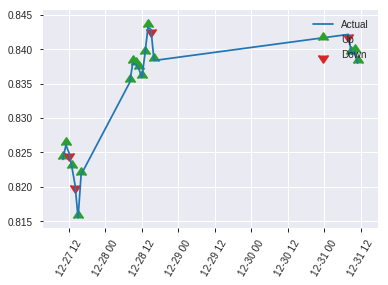


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.188965721758017
RMSE: 0.43470187687427464
LogLoss: 0.5613355433185152
Mean Per-Class Error: 0.25028510915607693
AUC: 0.7947214076246334
pr_auc: 0.7284846632108037
Gini: 0.5894428152492668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48305348018055183: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   34   0.2742   (34.0/124.0)
1      24   75   0.2424   (24.0/99.0)
Total  114  109  0.2601   (58.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483053     0.721154  108
max f2                       0.148574     0.82038   182
max f0point5                 0.490071     0.723014  97
max accuracy                 0.490071     0.753363  97
max precision                0.908265     1         0
max recall                   0.045466     1         213
max specificity              0.908265     1         0
max absolute_mcc             0.490071     0.49996   97
max min_per_class_accuracy   0.485327     0.737374  103
max mean_per_class_accuracy  0.490071     0.749715  97

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 43.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.897429           2.25253   2.25253            1                0.901593   1                           0.901593            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.885681           0         1.35152            0                0.892366   0.6                         0.897902            0               0.030303                   -100      35.1515
    3        0.0313901                   0.871657           2.25253   1.60895            1                0.881035   0.714286                    0.893083            0.020202        0.0505051                  125.253   60.8947
    4        0.0403587                   0.846846           2.25253   1.75196            1                0.864008   0.777778                    0.886622            0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.806535           2.25253   1.8771             1                0.8309     0.833333                    0.872691            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.735495           2.25253   2.05665            1                0.76312    0.913043                    0.820288            0.111111        0.212121                   125.253   105.665
    7        0.152466                    0.649384           1.6382    1.92127            0.727273         0.684468   0.852941                    0.776346            0.0808081       0.292929                   63.82     92.1272
    8        0.201794                    0.624048           1.02388   1.70191            0.454545         0.636091   0.755556                    0.742061            0.0505051       0.343434                   2.38751   70.1908
    9        0.300448                    0.529305           1.6382    1.68099            0.727273         0.564039   0.746269                    0.683606            0.161616        0.505051                   63.82     68.0989
    10       0.399103                    0.503423           1.43343   1.61979            0.636364         0.514697   0.719101                    0.641854            0.141414        0.646465                   43.3425   61.9793
    11       0.502242                    0.474688           1.07729   1.50839            0.478261         0.488857   0.669643                    0.610435            0.111111        0.757576                   7.72947   50.8387
    12       0.600897                    0.439356           0.8191    1.39522            0.363636         0.456729   0.619403                    0.585199            0.0808081       0.838384                   -18.09    39.5221
    13       0.699552                    0.333208           0.716713  1.29953            0.318182         0.39654    0.576923                    0.558594            0.0707071       0.909091                   -28.3287  29.9534
    14       0.798206                    0.174639           0.307163  1.17688            0.136364         0.25726    0.522472                    0.52135             0.030303        0.939394                   -69.2837  17.6881
    15       0.896861                    0.0765419          0.40955   1.09247            0.181818         0.124938   0.485                       0.477745            0.040404        0.979798                   -59.045   9.24747
    16       1                           0.01118            0.195872  1                  0.0869565        0.0469551  0.443946                   

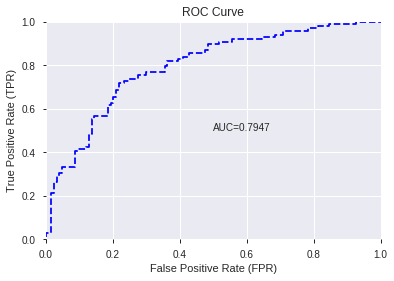

This function is available for GLM models only


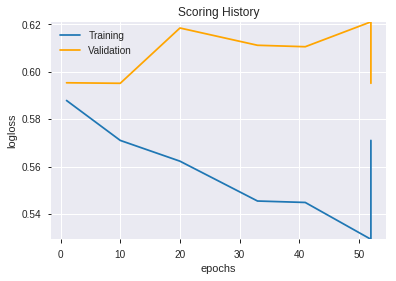

--2019-08-27 16:35:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


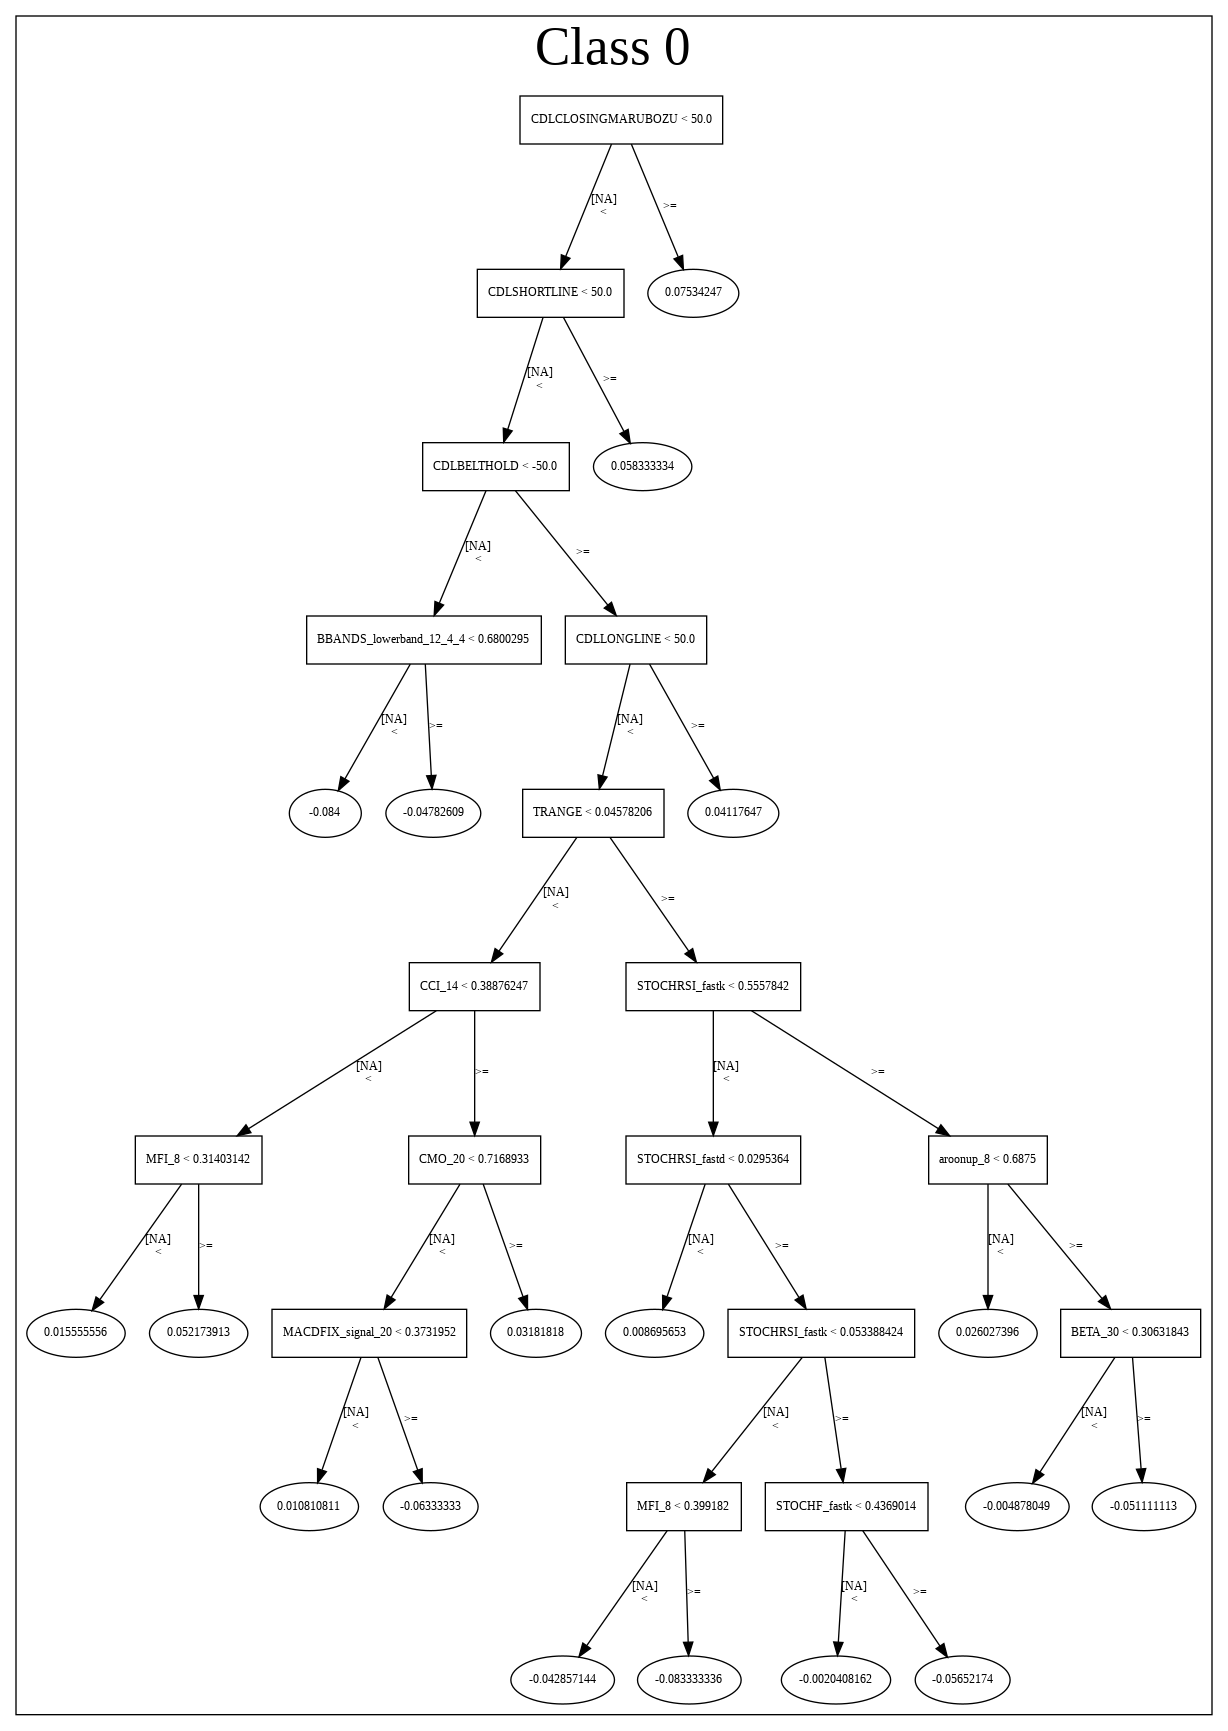

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_162751_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_162751_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'TRANGE',
 'CDLLONGLINE',
 'hour',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'CCI_8',
 'WILLR_8',
 'ULTOSC',
 'CDLMARUBOZU',
 'WILLR_12',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'WILLR_20',
 'CMO_12',
 'WILLR_24',
 'WILLR_14',
 'RSI_8',
 'CMO_14',
 'RSI_14',
 'CMO_8',
 'RSI_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_163541_model_1  0.801238  0.556656              0.261241  0.430112  0.184996

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.826807           1.000000    0.242212
1                  SUB             0.350938           0.424450    0.102807
2   CDLCLOSINGMARUBOZU             0.348485           0.421484    0.102088
3                CCI_8             0.294318           0.355970    0.086220
4              WILLR_8             0.208630           0.252333    0.061118
5                 hour             0.188820           0.228373    0.055315
6          CDLBELTHOLD             0.137349           0.166119    0.040236
7          CDLMARUBOZU             0.113778           0.137611    0.033331
8          CDLLONGLINE             0.112413           0.135961    0.032931
9               TRANGE             0.111667           0.135058    0.032713
10            WILLR_14             0.098577           0.119226    0.028878
11               RSI_8             0.087959           0.106383    0.025767
12               CMO_8             0.083160           0.100580    0.024362
13              ULTOSC             0.076679           0.092741    0.022463
14        STOCHF_fastk             0.064175           0.077618    0.018800
15              CMO_14             0.053088           0.064208    0.015552
16              RSI_14             0.050507           0.061087    0.014796
17            WILLR_24             0.045422           0.054937    0.013306
18                 DIV             0.040801           0.049347    0.011952
19            WILLR_20             0.031890           0.038570    0.009342
20        CDLENGULFING             0.031848           0.038519    0.009330
21        CDLSHORTLINE             0.026677           0.032266    0.007815
22      STOCHRSI_fastk             0.015431           0.018664    0.004521
23            WILLR_12             0.007265           0.008787    0.002128
24              RSI_12             0.006710           0.008115    0.001966
25              CMO_12             0.000177           0.000214    0.000052

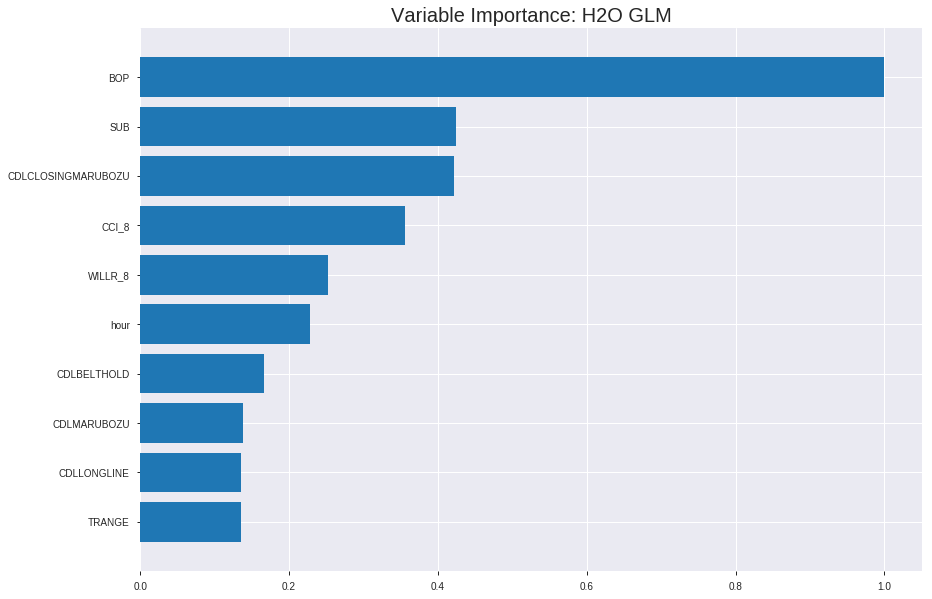

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_163541_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.196065012503967
RMSE: 0.44279229047485347
LogLoss: 0.5731627632534447
Null degrees of freedom: 1555
Residual degrees of freedom: 1529
Null deviance: 2154.759827525797
Residual deviance: 1783.68251924472
AIC: 1837.68251924472
AUC: 0.7652866389580135
pr_auc: 0.7340597748043407
Gini: 0.530573277916027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34224598600047673: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      385  423   0.5235   (423.0/808.0)
1      79   669   0.1056   (79.0/748.0)
Total  464  1092  0.3226   (502.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342246     0.727174  267
max f2                       0.170576     0.841732  341
max f0point5                 0.533707     0.681689  176
max accuracy                 0.423217     0.69473   228
max precision                0.937698     1         0
max recall                   0.0178707    1         399
max specificity              0.937698     1         0
max absolute_mcc             0.384486     0.409451  246
max min_per_class_accuracy   0.507629     0.684492  189
max mean_per_class_accuracy  0.410728     0.699165  234

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.911056           1.9502    1.9502             0.9375           0.922484   0.9375                      0.922484            0.0200535       0.0200535                  95.0201   95.0201
    2        0.0205656                   0.892069           1.82019   1.88519            0.875            0.901103   0.90625                     0.911794            0.0187166       0.0387701                  82.0187   88.5194
    3        0.0302057                   0.873367           2.08021   1.94743            1                0.883735   0.93617                     0.902839            0.0200535       0.0588235                  108.021   94.7434
    4        0.0404884                   0.85855            1.82019   1.91512            0.875            0.864299   0.920635                    0.893051            0.0187166       0.0775401                  82.0187   91.5118
    5        0.0501285                   0.844777           1.94153   1.9202             0.933333         0.851311   0.923077                    0.885024            0.0187166       0.0962567                  94.1533   92.0197
    6        0.100257                    0.774567           1.62683   1.77352            0.782051         0.805603   0.852564                    0.845314            0.0815508       0.177807                   62.6834   77.3516
    7        0.150386                    0.725456           1.49349   1.68017            0.717949         0.749909   0.807692                    0.813512            0.0748663       0.252674                   49.3487   68.0173
    8        0.200514                    0.685475           1.46682   1.62683            0.705128         0.704013   0.782051                    0.786137            0.0735294       0.326203                   46.6817   62.6834
    9        0.300129                    0.626971           1.32865   1.52787            0.63871          0.655981   0.734475                    0.742938            0.132353        0.458556                   32.8653   52.7866
    10       0.400386                    0.560947           1.29347   1.46917            0.621795         0.593985   0.70626                     0.70564             0.129679        0.588235                   29.3466   46.9172
    11       0.5                         0.499569           1.04682   1.38503            0.503226         0.53101    0.66581                     0.670848            0.104278        0.692513                   4.68173   38.5027
    12       0.600257                    0.418516           1.13345   1.34301            0.544872         0.460355   0.64561                     0.635691            0.113636        0.80615                    13.345    34.3007
    13       0.699871                    0.344262           0.872348  1.27602            0.419355         0.378243   0.613407                    0.599048            0.0868984       0.893048                   -12.7652  27.6017
    14       0.800129                    0.265487           0.520053  1.18129            0.25             0.306066   0.567871                    0.562337            0.052139        0.945187                   -47.9947  18.1294
    15       0.899743                    0.150961           0.402622  1.09508            0.193548         0.210297   0.526429                    0.523361            0.040107        0.985294                   -59.7378  9.5084
    16       1                           0.0171109          0.146682  1                  0.0705128        0.0980419  0.48072                     



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19849283279787097
RMSE: 0.44552534473121835
LogLoss: 0.5878479013084208
Null degrees of freedom: 443
Residual degrees of freedom: 417
Null deviance: 612.6260558984648
Residual deviance: 522.0089363618777
AIC: 576.0089363618777
AUC: 0.7574197518203262
pr_auc: 0.6986827332087937
Gini: 0.5148395036406523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3602725593558566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      144  101  0.4122   (101.0/245.0)
1      33   166  0.1658   (33.0/199.0)
Total  177  267  0.3018   (134.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360273     0.712446  240
max f2                       0.233435     0.820175  310
max f0point5                 0.503707     0.660888  162
max accuracy                 0.371766     0.70045   235
max precision                0.954496     1         0
max recall                   0.0196968    1         397
max specificity              0.954496     1         0
max absolute_mcc             0.371766     0.428857  235
max min_per_class_accuracy   0.457686     0.673367  188
max mean_per_class_accuracy  0.371766     0.71206   235

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 43.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.88325            1.78492   1.78492            0.8              0.9301    0.8                         0.9301              0.0201005       0.0201005                  78.4925   78.4925
    2        0.0202703                   0.857559           2.23116   1.98325            1                0.873543  0.888889                    0.904963            0.0201005       0.040201                   123.116   98.325
    3        0.0315315                   0.827424           2.23116   2.07179            1                0.841625  0.928571                    0.882343            0.0251256       0.0653266                  123.116   107.179
    4        0.0405405                   0.806407           2.23116   2.1072             1                0.820213  0.944444                    0.868536            0.0201005       0.0854271                  123.116   110.72
    5        0.0518018                   0.789581           1.78492   2.03714            0.8              0.798297  0.913043                    0.853267            0.0201005       0.105528                   78.4925   103.714
    6        0.101351                    0.707813           1.62266   1.83451            0.727273         0.751477  0.822222                    0.803503            0.080402        0.18593                    62.2659   83.4506
    7        0.150901                    0.672519           1.72407   1.79824            0.772727         0.690949  0.80597                     0.766545            0.0854271       0.271357                   72.4075   79.8245
    8        0.20045                     0.631821           1.31841   1.67963            0.590909         0.654029  0.752809                    0.738732            0.0653266       0.336683                   31.841    67.9634
    9        0.29955                     0.5716             1.16629   1.5098             0.522727         0.60058   0.676692                    0.693028            0.115578        0.452261                   16.6286   50.9805
    10       0.400901                    0.510175           1.43786   1.49162            0.644444         0.542669  0.668539                    0.655016            0.145729        0.59799                    43.7856   49.1615
    11       0.5                         0.442928           1.01416   1.39698            0.454545         0.476057  0.626126                    0.619547            0.100503        0.698492                   1.41617   39.6985
    12       0.599099                    0.360847           1.31841   1.38399            0.590909         0.406058  0.620301                    0.584233            0.130653        0.829146                   31.841    38.3988
    13       0.70045                     0.28363            0.644556  1.277              0.288889         0.3193    0.572347                    0.545898            0.0653266       0.894472                   -35.5444  27.6996
    14       0.79955                     0.216353           0.456373  1.17528            0.204545         0.250316  0.526761                    0.509263            0.0452261       0.939698                   -54.3627  17.5285
    15       0.898649                    0.127093           0.354957  1.08482            0.159091         0.178009  0.486216                    0.472734            0.0351759       0.974874                   -64.5043  8.48226
    16       1                           0.00679656         0.247906  1                  0.111111         0.071897  0.448198                    0.432108           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:35:42  0.000 sec   2            .2E2      27            1.3666137386159496  1.3619642526713835
     2019-08-27 16:35:42  0.012 sec   4            .12E2     27            1.3575299869474995  1.353146460708382
     2019-08-27 16:35:42  0.033 sec   6            .77E1     27            1.3451496808581787  1.3412301082730134
     2019-08-27 16:35:42  0.043 sec   8            .48E1     27            1.329194237218182   1.3260812982186179
     2019-08-27 16:35:42  0.051 sec   10           .3E1      27            1.3098000265077616  1.308021097416121
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:35:42  0.197 sec   38           .38E-2    27            1.145393180191427   1.1757017683678421
     2019-08-27 16:35:42  0.209 sec   40           .24E-2    27            1.1446893551193233  1.1761751473911435
     2019-08-27 16:35:42  0.216 sec   41           .15E-2    27            1.1441674811762512  1.1769412531231456
     2019-08-27 16:35:42  0.224 sec   42           .91E-3    27            1.1437779066363696  1.1779278085899707
     2019-08-27 16:35:42  0.233 sec   43           .56E-3    27            1.1435301144640149  1.1789234949009024


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.7336244541484717)

('auc', 0.8012381883349625)

('logloss', 0.5566561897701615)

('mean_per_class_error', 0.2603046594982079)

('rmse', 0.4301120299629024)

('mse', 0.18499635831880862)

glm prediction progress: |████████████████████████████████████████████████| 100%


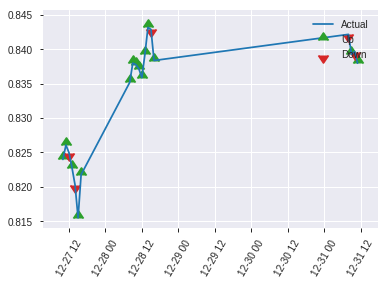


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18499635831880862
RMSE: 0.4301120299629024
LogLoss: 0.5566561897701615
Null degrees of freedom: 222
Residual degrees of freedom: 196
Null deviance: 307.54649216112034
Residual deviance: 248.26866063749208
AIC: 302.2686606374921
AUC: 0.8012381883349625
pr_auc: 0.7362527781069305
Gini: 0.602476376669925
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216977167933375: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   46   0.371    (46.0/124.0)
1      15   84   0.1515   (15.0/99.0)
Total  93   130  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421698     0.733624  129
max f2                       0.366254     0.821033  145
max f0point5                 0.561659     0.722348  85
max accuracy                 0.561659     0.744395  85
max precision                0.945776     1         0
max recall                   0.0404485    1         221
max specificity              0.945776     1         0
max absolute_mcc             0.421698     0.481176  129
max min_per_class_accuracy   0.524496     0.725806  105
max mean_per_class_accuracy  0.493877     0.739695  113

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.910243           2.25253   2.25253            1                0.924798   1                           0.924798            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.904079           1.12626   1.80202            0.5              0.906104   0.8                         0.917321            0.010101        0.040404                   12.6263   80.202
    3        0.0313901                   0.872136           1.12626   1.60895            0.5              0.888839   0.714286                    0.909183            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.833469           2.25253   1.75196            1                0.866691   0.777778                    0.89974             0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.819654           2.25253   1.8771             1                0.825511   0.833333                    0.881183            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.741964           1.84298   1.86078            0.818182         0.772411   0.826087                    0.829162            0.0909091       0.191919                   84.2975   86.0782
    7        0.152466                    0.711099           2.04775   1.92127            0.909091         0.729576   0.852941                    0.796943            0.10101         0.292929                   104.775   92.1272
    8        0.201794                    0.673828           2.04775   1.95219            0.909091         0.689935   0.866667                    0.770785            0.10101         0.393939                   104.775   95.2189
    9        0.300448                    0.618789           1.33104   1.74823            0.590909         0.63916    0.776119                    0.727565            0.131313        0.525253                   33.1038   74.8229
    10       0.399103                    0.552803           1.33104   1.6451             0.590909         0.591601   0.730337                    0.693956            0.131313        0.656566                   33.1038   64.5103
    11       0.502242                    0.511449           1.07729   1.5285             0.478261         0.534726   0.678571                    0.661257            0.111111        0.767677                   7.72947   52.8499
    12       0.600897                    0.406941           0.8191    1.41203            0.363636         0.449428   0.626866                    0.626479            0.0808081       0.848485                   -18.09    41.2031
    13       0.699552                    0.331587           0.511938  1.28509            0.227273         0.366754   0.570513                    0.589851            0.0505051       0.89899                    -48.8062  28.5095
    14       0.798206                    0.253335           0.511938  1.18954            0.227273         0.293385   0.52809                     0.553209            0.0505051       0.949495                   -48.8062  18.9536
    15       0.896861                    0.14102            0.204775  1.08121            0.0909091        0.208293   0.48                        0.515268            0.020202        0.969697                   -79.5225  8.12121
    16       1                           0.00233959         0.293808  1                  0.130435         0.0851821  0.443946                    

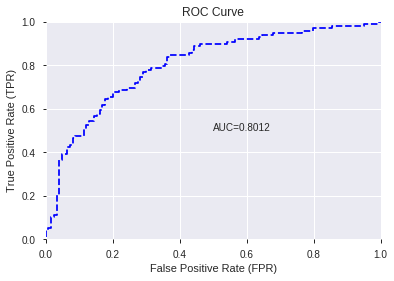

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


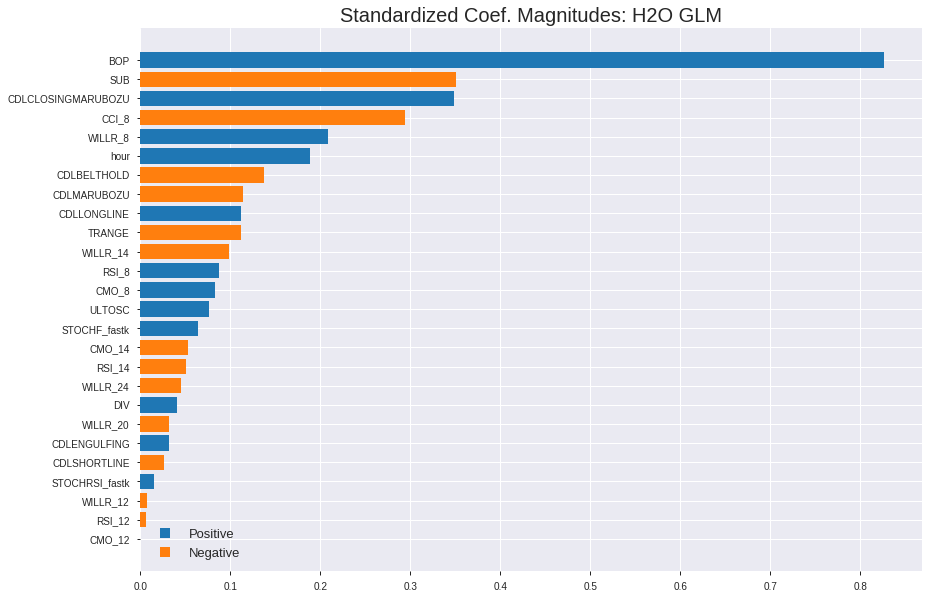

'log_likelihood'
--2019-08-27 16:35:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


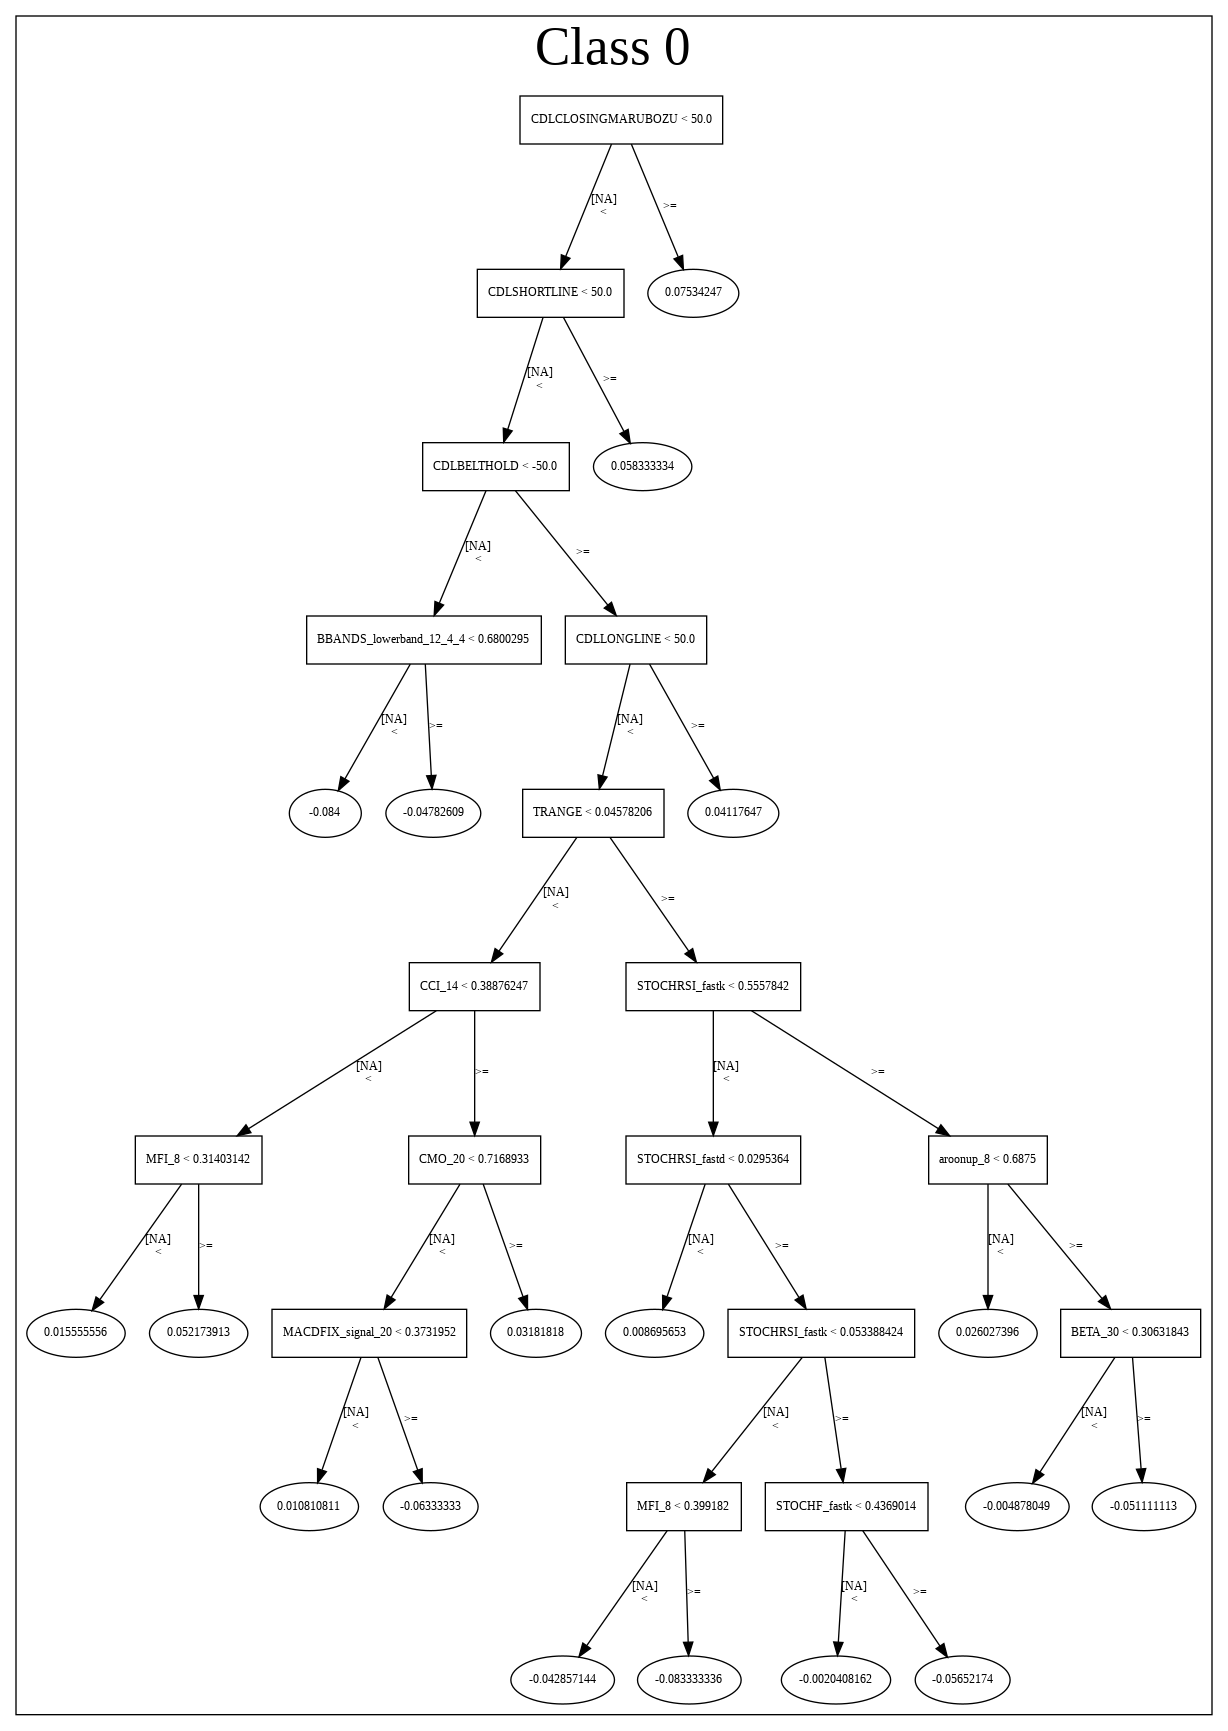

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_163541_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_163541_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'WILLR_8',
 'hour',
 'CDLBELTHOLD',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'TRANGE',
 'WILLR_14',
 'RSI_8',
 'CMO_8',
 'ULTOSC',
 'STOCHF_fastk',
 'CMO_14',
 'RSI_14',
 'WILLR_24',
 'DIV',
 'WILLR_20',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'WILLR_12',
 'RSI_12',
 'CMO_12']

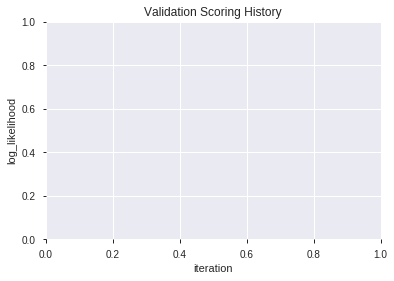

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_163600  0.790323  0.554414              0.270365  0.433237  0.187694
1  XGBoost_grid_1_AutoML_20190827_163600_model_6  0.784132  0.555330              0.259246  0.434267  0.188588
2  XGBoost_grid_1_AutoML_20190827_163600_model_2  0.781443  0.555242              0.295455  0.434301  0.188617
3               XGBoost_2_AutoML_20190827_163600  0.779000  0.561212              0.277330  0.436601  0.190620
4  XGBoost_grid_1_AutoML_20190827_163600_model_3  0.774031  0.561466              0.276393  0.437900  0.191757
5  XGBoost_grid_1_AutoML_20190827_163600_model_4  0.773379  0.563133              0.271261  0.437935  0.191787
6  XGBoost_grid_1_AutoML_20190827_163600_model_7  0.773297  0.562992              0.287471  0.438655  0.192419
7               XGBoost_1_AutoML_20190827_163600  0.772483  0.563622              0.303519  0.438211  0.192029
8  XGBoost_grid_1_AutoML_20190827_163600_model_5  0.767921  0.568866              0.323640  0.441429  0.194859
9  XGBoost_grid_1_AutoML_20190827_163600_model_1  0.765396  0.567574              0.300505  0.441120  0.194587

variable  relative_importance  scaled_importance  percentage
0                  BOP          2167.546875           1.000000    0.313606
1                  DIV           599.551025           0.276603    0.086745
2               TRANGE           456.948914           0.210814    0.066113
3         STOCHF_fastk           375.270630           0.173131    0.054295
4                 hour           358.287506           0.165296    0.051838
5                CCI_8           317.076965           0.146284    0.045876
6       STOCHRSI_fastk           291.287201           0.134386    0.042144
7               ULTOSC           285.857544           0.131881    0.041359
8   CDLCLOSINGMARUBOZU           252.596954           0.116536    0.036546
9             WILLR_12           224.595581           0.103617    0.032495
10                 SUB           189.123398           0.087252    0.027363
11              CMO_14           166.792084           0.076950    0.024132
12              CMO_12           153.047394           0.070609    0.022143
13             WILLR_8           149.988052           0.069197    0.021701
14               CMO_8           148.650406           0.068580    0.021507
15            WILLR_20           121.041000           0.055842    0.017513
16            WILLR_24           118.234680           0.054548    0.017107
17            WILLR_14           118.098732           0.054485    0.017087
18              RSI_12            74.013367           0.034146    0.010708
19         CDLBELTHOLD            73.062622           0.033708    0.010571
20         CDLLONGLINE            72.069824           0.033249    0.010427
21        CDLSHORTLINE            68.229675           0.031478    0.009872
22               RSI_8            66.600197           0.030726    0.009636
23              RSI_14            61.623322           0.028430    0.008916
24        CDLENGULFING             2.084717           0.000962    0.000302

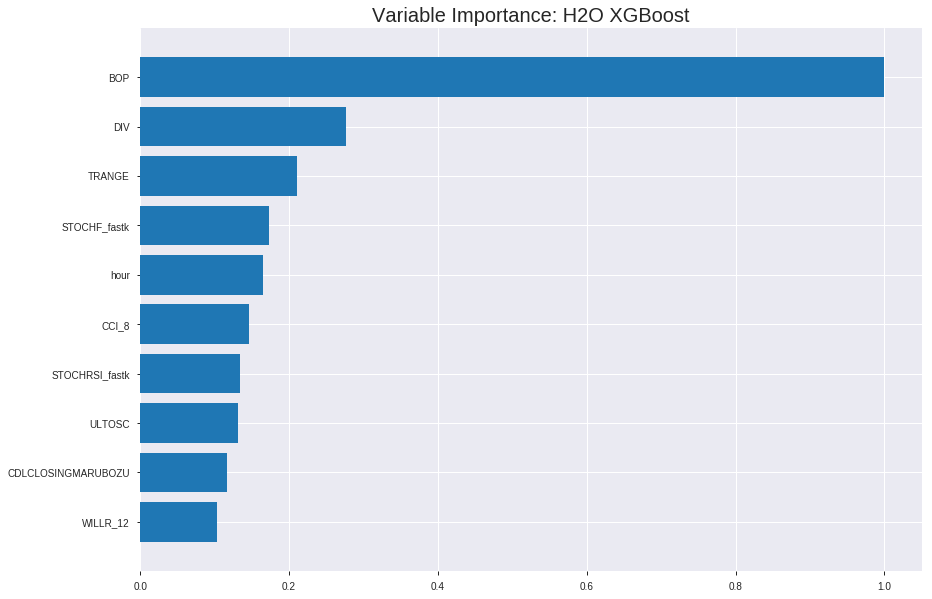

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_163600


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14669215578925657
RMSE: 0.3830041198071589
LogLoss: 0.46030514641342724
Mean Per-Class Error: 0.17903187377561292
AUC: 0.9010612458304653
pr_auc: 0.8997818777127368
Gini: 0.8021224916609306
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4962310120463371: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      627  181  0.224    (181.0/808.0)
1      113  635  0.1511   (113.0/748.0)
Total  740  816  0.1889   (294.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496231     0.81202   199
max f2                       0.326963     0.871938  280
max f0point5                 0.590563     0.83938   147
max accuracy                 0.543307     0.822622  174
max precision                0.939497     1         0
max recall                   0.155938     1         354
max specificity              0.939497     1         0
max absolute_mcc             0.543307     0.645414  174
max min_per_class_accuracy   0.517759     0.811881  187
max mean_per_class_accuracy  0.543307     0.820968  174

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.908525           2.08021   2.08021            1                0.92285   1                           0.92285             0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.887999           2.08021   2.08021            1                0.899597  1                           0.911223            0.0213904       0.0427807                  108.021   108.021
    3        0.0302057                   0.863593           2.08021   2.08021            1                0.876322  1                           0.900085            0.0200535       0.0628342                  108.021   108.021
    4        0.0404884                   0.84655            2.08021   2.08021            1                0.853376  1                           0.888222            0.0213904       0.0842246                  108.021   108.021
    5        0.0501285                   0.831318           2.08021   2.08021            1                0.840053  1                           0.878959            0.0200535       0.104278                   108.021   108.021
    6        0.100257                    0.775696           2.02688   2.05354            0.974359         0.802678  0.987179                    0.840818            0.101604        0.205882                   102.688   105.354
    7        0.150386                    0.72621            2.02688   2.04465            0.974359         0.750233  0.982906                    0.810623            0.101604        0.307487                   102.688   104.465
    8        0.200514                    0.69116            1.9202    2.01354            0.923077         0.708683  0.967949                    0.785138            0.0962567       0.403743                   92.0197   101.354
    9        0.300129                    0.629142           1.71785   1.9154             0.825806         0.658495  0.920771                    0.743105            0.171123        0.574866                   71.7854   91.54
    10       0.400386                    0.571473           1.44015   1.7964             0.692308         0.60046   0.863563                    0.707386            0.144385        0.719251                   44.0148   79.6397
    11       0.5                         0.513127           1.04682   1.64706            0.503226         0.539755  0.791774                    0.673989            0.104278        0.823529                   4.68173   64.7059
    12       0.600257                    0.450321           0.826752  1.51005            0.397436         0.479925  0.72591                     0.641576            0.0828877       0.906417                   -17.3248  51.0048
    13       0.699871                    0.356547           0.442884  1.35816            0.212903         0.40705   0.652893                    0.608195            0.0441176       0.950535                   -55.7116  35.8156
    14       0.800129                    0.227394           0.320033  1.22808            0.153846         0.295693  0.590361                    0.569038            0.0320856       0.98262                    -67.9967  22.8078
    15       0.899743                    0.135554           0.17447   1.11143            0.083871         0.176546  0.534286                    0.525584            0.0173797       1                          -82.553   11.1429
    16       1                           0.0576304          0         1                  0                0.100908  0.48072                     0.483007           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2001973733311328
RMSE: 0.4474342111764955
LogLoss: 0.5853418676196128
Mean Per-Class Error: 0.30003076607527435
AUC: 0.7511537278227874
pr_auc: 0.6926849871132543
Gini: 0.5023074556455749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31374868750572205: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  124  0.5061   (124.0/245.0)
1      25   174  0.1256   (25.0/199.0)
Total  146  298  0.3356   (149.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313749     0.700201  269
max f2                       0.104772     0.816832  374
max f0point5                 0.408253     0.647773  235
max accuracy                 0.408253     0.689189  235
max precision                0.915199     1         0
max recall                   0.0799504    1         388
max specificity              0.915199     1         0
max absolute_mcc             0.408253     0.403429  235
max min_per_class_accuracy   0.49669      0.683417  191
max mean_per_class_accuracy  0.408253     0.699969  235

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 43.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.874461           1.78492   1.78492            0.8              0.893066   0.8                         0.893066            0.0201005       0.0201005                  78.4925   78.4925
    2        0.0202703                   0.849095           2.23116   1.98325            1                0.868775   0.888889                    0.88227             0.0201005       0.040201                   123.116   98.325
    3        0.0315315                   0.812742           1.78492   1.91242            0.8              0.826855   0.857143                    0.862479            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.784185           1.67337   1.8593             0.75             0.791505   0.833333                    0.846707            0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.773039           1.78492   1.84313            0.8              0.777096   0.826087                    0.831574            0.0201005       0.0954774                  78.4925   84.3129
    6        0.101351                    0.707981           1.82549   1.83451            0.818182         0.738995   0.822222                    0.786313            0.0904523       0.18593                    82.5491   83.4506
    7        0.150901                    0.670926           1.82549   1.83155            0.818182         0.692262   0.820896                    0.755431            0.0904523       0.276382                   82.5491   83.1546
    8        0.20045                     0.634427           1.41983   1.72977            0.636364         0.647944   0.775281                    0.728861            0.0703518       0.346734                   41.9826   72.9772
    9        0.29955                     0.588586           1.11558   1.52658            0.5              0.609715   0.684211                    0.689444            0.110553        0.457286                   11.5578   52.658
    10       0.400901                    0.533886           1.23953   1.45401            0.555556         0.558059   0.651685                    0.656229            0.125628        0.582915                   23.9531   45.4012
    11       0.5                         0.480236           1.21699   1.40704            0.545455         0.508964   0.630631                    0.627041            0.120603        0.703518                   21.6994   40.7035
    12       0.599099                    0.399876           1.11558   1.35882            0.5              0.435711   0.609023                    0.595393            0.110553        0.81407                    11.5578   35.8824
    13       0.70045                     0.284483           0.644556  1.25547            0.288889         0.340735   0.562701                    0.558545            0.0653266       0.879397                   -35.5444  25.5474
    14       0.79955                     0.18688            0.456373  1.15643            0.204545         0.232876   0.51831                     0.51818             0.0452261       0.924623                   -54.3627  15.643
    15       0.898649                    0.128746           0.557789  1.09041            0.25             0.15812    0.488722                    0.478475            0.0552764       0.979899                   -44.2211  9.04145
    16       1                           0.0642828          0.198325  1                  0.0888889        0.0982132  0.448198                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:36:03  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.51928                          0.5                0.693147              0.5               0                    1                  0.551802
    2019-08-27 16:36:04  0.106 sec   5                  0.474791         0.643663            0.825489        0.814296           2.08021          0.284062                         0.481733           0.657049              0.741985          0.680589             2.23116            0.346847
    2019-08-27 16:36:04  0.169 sec   10                 0.455519         0.606288            0.838131        0.830468           2.08021          0.257712                         0.468612           0.631084              0.746836          0.69752              2.23116            0.326577
    2019-08-27 16:36:04  0.229 sec   15                 0.44138          0.578546            0.847096        0.841749           2.08021          0.26671                          0.461267           0.616022              0.745882          0.699632             2.23116            0.324324
    2019-08-27 16:36:04  0.292 sec   20                 0.429496         0.554894            0.855327        0.851645           2.08021          0.248715                         0.457012           0.606835              0.742221          0.690842             1.78492            0.31982
    2019-08-27 16:36:04  0.354 sec   25                 0.420289         0.536258            0.863262        0.859888           2.08021          0.222365                         0.453608           0.599205              0.74377           0.696688             1.78492            0.328829
    2019-08-27 16:36:04  0.416 sec   30                 0.412809         0.520658            0.868739        0.865693           2.08021          0.237147                         0.451421           0.594204              0.745124          0.695881             1.78492            0.324324
    2019-08-27 16:36:04  0.481 sec   35                 0.406588         0.507731            0.873897        0.870748           2.08021          0.242288                         0.450752           0.592307              0.744508          0.693226             1.78492            0.328829
    2019-08-27 16:36:04  0.549 sec   40                 0.40109          0.496239            0.879333        0.872842           2.08021          0.209512                         0.449228           0.589105              0.747328          0.695384             1.78492            0.322072
    2019-08-27 16:36:04  0.617 sec   45                 0.395833         0.485727            0.88615         0.884146           2.08021          0.206298                         0.448363           0.587133              0.748528          0.695106             1.78492            0.322072
    2019-08-27 16:36:04  0.680 sec   50                 0.391248         0.47678             0.89181         0.890167           2.08021          0.213368                         0.448051           0.586346              0.749656          0.693444             1.78492            0.324324
    2019-08-27 16:36:04  0.741 sec   55                 0.387771         0.469587            0.895545        0.894003           2.08021          0.207584                         0.447866           0.585989              0.749892          0.

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2167.546875            1.0                    0.3136064305080751
DIV           599.551025390625       0.2766034877057157     0.08674463244547373
TRANGE        456.94891357421875     0.21081385544394224    0.06611258070742006
STOCHF_fastk  375.2706298828125      0.1731314945070392     0.054295150000880976
hour          358.2875061035156      0.16529631272842282    0.05183798661090718
---           ---                    ---                    ---
CDLLONGLINE   72.06982421875         0.033249488188692576   0.010427253307076282
CDLSHORTLINE  68.22967529296875      0.031477831496939945   0.009871650375889994
RSI_8         66.6001968383789       0.030726069921038688   0.009635893111478475
RSI_14        61.623321533203125     0.02842998333459484    0.00891582559296635
CDLENGULFING  2.084716796875         0.0009617862575059651  0.00030162235512816606


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7219730941704036)

('F1', 0.7181818181818181)

('auc', 0.7903225806451613)

('logloss', 0.5544141988582545)

('mean_per_class_error', 0.2703649397197785)

('rmse', 0.43323711757126054)

('mse', 0.18769440004145424)

xgboost prediction progress: |████████████████████████████████████████████| 100%


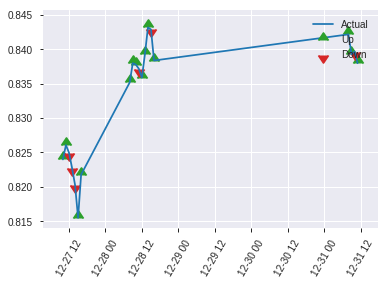


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18769440004145424
RMSE: 0.43323711757126054
LogLoss: 0.5544141988582545
Mean Per-Class Error: 0.2703649397197785
AUC: 0.7903225806451613
pr_auc: 0.7194727095307103
Gini: 0.5806451612903225
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4748607575893402: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   42   0.3387   (42.0/124.0)
1      20   79   0.202    (20.0/99.0)
Total  102  121  0.278    (62.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474861     0.718182  120
max f2                       0.179863     0.830479  187
max f0point5                 0.587992     0.704961  70
max accuracy                 0.587992     0.721973  70
max precision                0.931198     1         0
max recall                   0.116668     1         207
max specificity              0.931198     1         0
max absolute_mcc             0.474861     0.45804   120
max min_per_class_accuracy   0.495995     0.709677  106
max mean_per_class_accuracy  0.474861     0.729635  120

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 45.49 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.895651           2.25253    2.25253            1                0.92273   1                           0.92273             0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.821521           2.25253    2.25253            1                0.832811  1                           0.886762            0.020202        0.0505051                  125.253   125.253
    3        0.0313901                   0.786888           0          1.60895            0                0.799672  0.714286                    0.861879            0               0.0505051                  -100      60.8947
    4        0.0403587                   0.778231           2.25253    1.75196            1                0.784783  0.777778                    0.844747            0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.763135           1.50168    1.68939            0.666667         0.77252   0.75                        0.82669             0.020202        0.0909091                  50.1684   68.9394
    6        0.103139                    0.711183           2.25253    1.95872            1                0.731505  0.869565                    0.781167            0.111111        0.20202                    125.253   95.8718
    7        0.152466                    0.661037           1.6382     1.85502            0.727273         0.683621  0.823529                    0.749608            0.0808081       0.282828                   63.82     85.5021
    8        0.201794                    0.640968           1.43343    1.75196            0.636364         0.648319  0.777778                    0.724848            0.0707071       0.353535                   43.3425   75.1964
    9        0.300448                    0.596395           1.53581    1.68099            0.681818         0.621413  0.746269                    0.690884            0.151515        0.505051                   53.5813   68.0989
    10       0.399103                    0.537278           1.02388    1.51856            0.454545         0.566241  0.674157                    0.660074            0.10101         0.606061                   2.38751   51.8556
    11       0.502242                    0.488056           1.27317    1.46816            0.565217         0.509563  0.651786                    0.629165            0.131313        0.737374                   27.3166   46.8164
    12       0.600897                    0.426871           0.921488   1.37841            0.409091         0.463331  0.61194                     0.601939            0.0909091       0.828283                   -7.85124  37.8411
    13       0.699552                    0.319136           0.8191     1.29953            0.363636         0.384684  0.576923                    0.5713              0.0808081       0.909091                   -18.09    29.9534
    14       0.798206                    0.21236            0.307163   1.17688            0.136364         0.270004  0.522472                    0.534061            0.030303        0.939394                   -69.2837  17.6881
    15       0.896861                    0.14168            0.511938   1.10374            0.227273         0.177973  0.49                        0.494892            0.0505051       0.989899                   -48.8062  10.3737
    16       1                           0.065957           0.0979359  1                  0.0434783        0.106852  0.443946                   

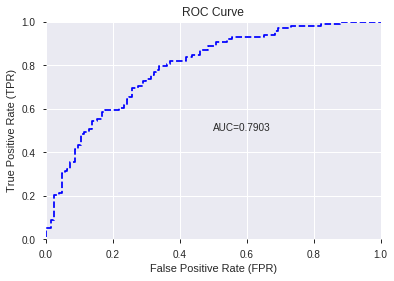

This function is available for GLM models only


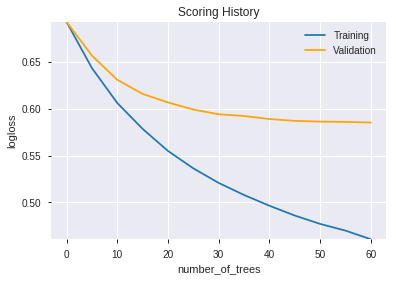

--2019-08-27 16:36:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

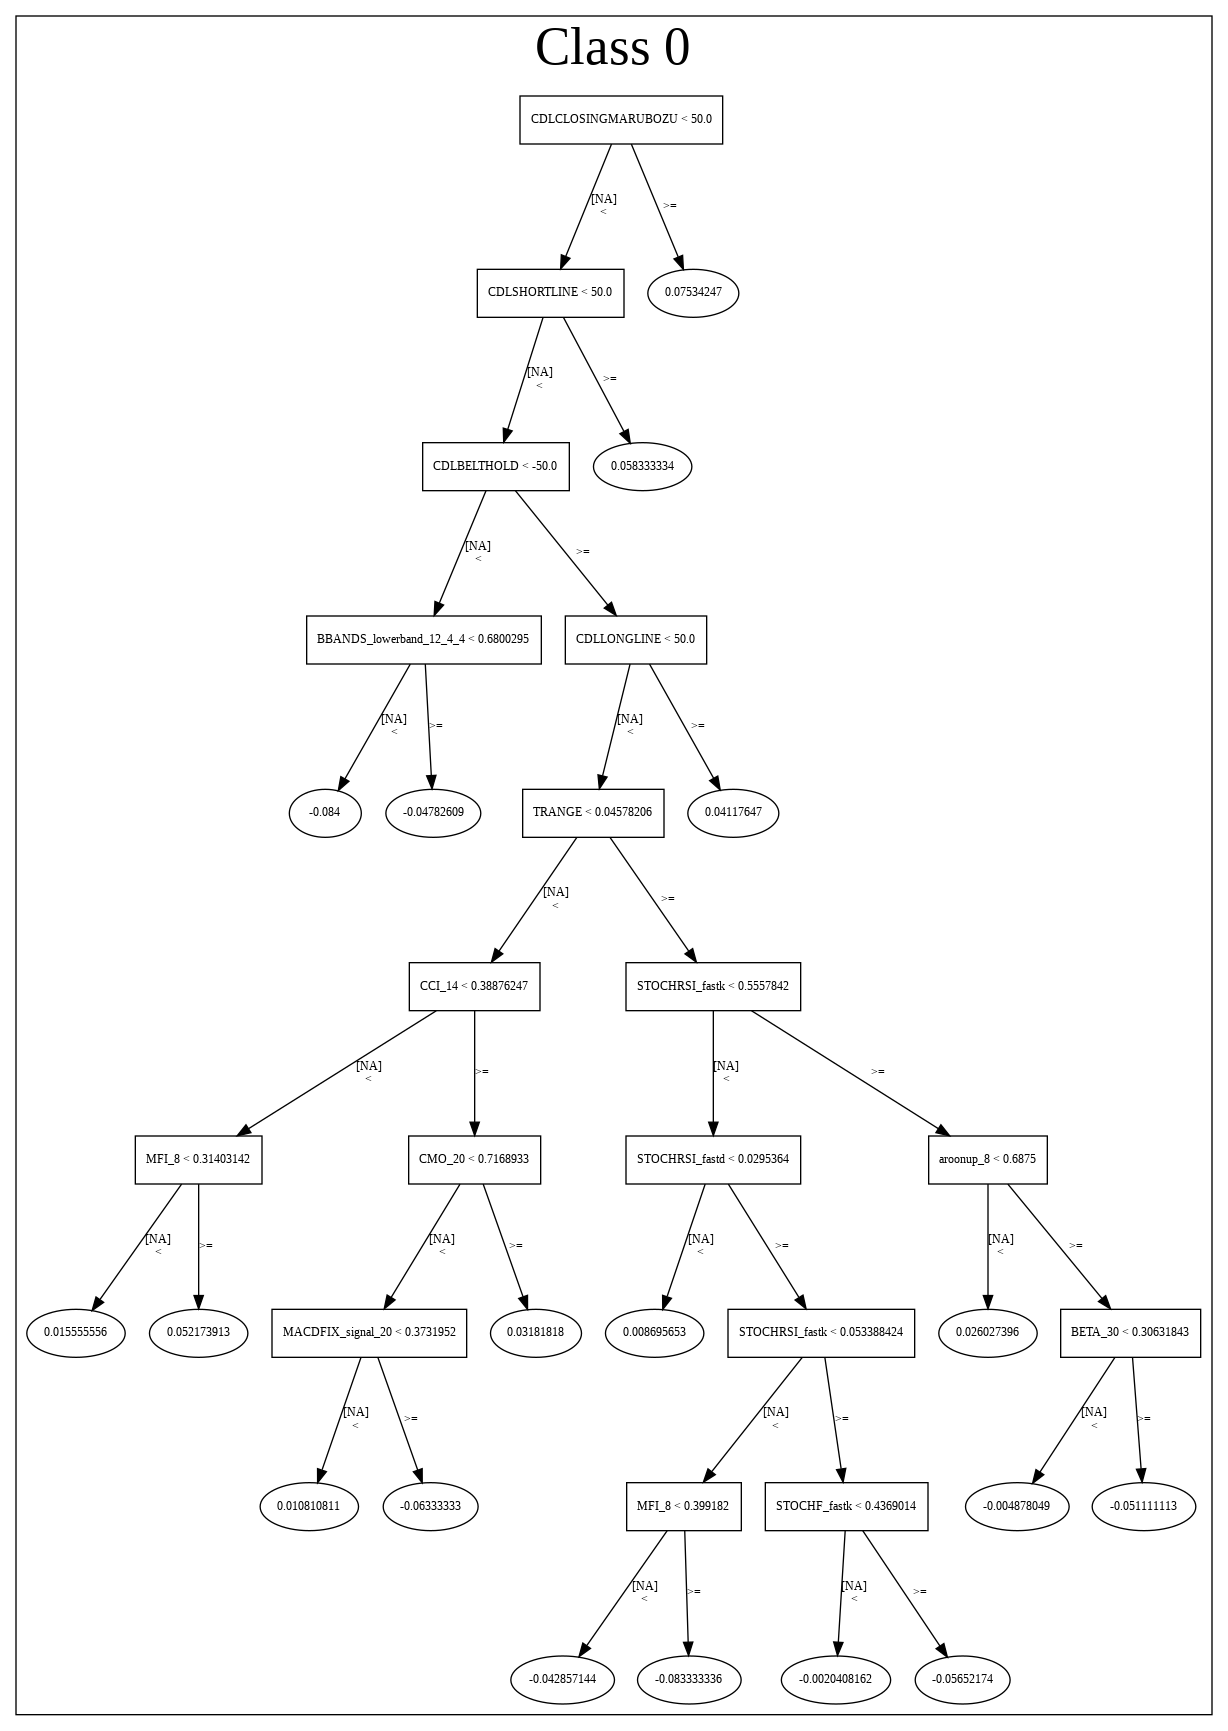

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_163600',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_163600',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_863b',
   'type

['BOP',
 'DIV',
 'TRANGE',
 'STOCHF_fastk',
 'hour',
 'CCI_8',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'SUB',
 'CMO_14',
 'CMO_12',
 'WILLR_8',
 'CMO_8',
 'WILLR_20',
 'WILLR_24',
 'WILLR_14',
 'RSI_12',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'RSI_8',
 'RSI_14',
 'CDLENGULFING']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

216

['BBANDS_upperband_14_7_2',
 'BBANDS_middleband_14_7_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_middleband_14_7_5',
 'BBANDS_lowerband_14_7_5',
 'DEMA_20',
 'KAMA_20',
 'MIDPOINT_20',
 'MIDPRICE_20',
 'SMA_20',
 'WMA_20',
 'MAVP_20_0',
 'BBANDS_upperband_20_0_4',
 'BBANDS_middleband_20_0_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_middleband_20_0_5',
 'MA_20_1',
 'MAVP_20_1',
 'BBANDS_middleband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_1_3',
 'BBANDS_middleband_20_1_4',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_upperband_20_1_5',
 'MA_20_2',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_middleband_20_2_4',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_upperband_20_3_4',
 'BBANDS_lowerband_20_3_4',
 'MA_20_5',
 'BBANDS_upperband_20_5_2',
 'BBANDS_middleband_20_5_2',
 'BBAND

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_163812_model_9  0.767025  0.596995              0.248208  0.451248  0.203624
1  DeepLearning_grid_1_AutoML_20190827_163812_model_8  0.761241  0.592443              0.289467  0.449719  0.202248
2  DeepLearning_grid_1_AutoML_20190827_163812_model_3  0.752851  0.645532              0.298550  0.455405  0.207394
3  DeepLearning_grid_1_AutoML_20190827_163812_model_6  0.746497  0.611713              0.299650  0.455574  0.207548
4  DeepLearning_grid_1_AutoML_20190827_163812_model_7  0.728983  0.774114              0.318793  0.495864  0.245881
5  DeepLearning_grid_1_AutoML_20190827_163812_model_5  0.705442  0.620064              0.339850  0.463796  0.215107
6  DeepLearning_grid_1_AutoML_20190827_163812_model_1  0.696888  1.250482              0.418377  0.530275  0.281191
7  DeepLearning_grid_1_AutoML_20190827_163812_model_2  0.686543  0.841645              0.349951  0.537058  0.288431
8               DeepLearning_1_AutoML_20190827_163812  0.674813  0.773853              0.376140  0.502447  0.252453
9  DeepLearning_grid_1_AutoML_20190827_163812_model_4  0.671962  0.962476              0.377077  0.533377  0.284491

variable  relative_importance  scaled_importance  percentage
0                     TRANGE             1.000000           1.000000    0.018493
1         CDLCLOSINGMARUBOZU             0.828178           0.828178    0.015316
2                        BOP             0.800117           0.800117    0.014797
3                CDLLONGLINE             0.721602           0.721602    0.013345
4               CDLENGULFING             0.432484           0.432484    0.007998
..                       ...                  ...                ...         ...
211  BBANDS_lowerband_14_7_4             0.200663           0.200663    0.003711
212                  KAMA_20             0.200421           0.200421    0.003706
213  BBANDS_upperband_30_2_4             0.198851           0.198851    0.003677
214                 TYPPRICE             0.198689           0.198689    0.003674
215       CDLSEPARATINGLINES             0.192113           0.192113    0.003553

[216 rows x 4 columns]

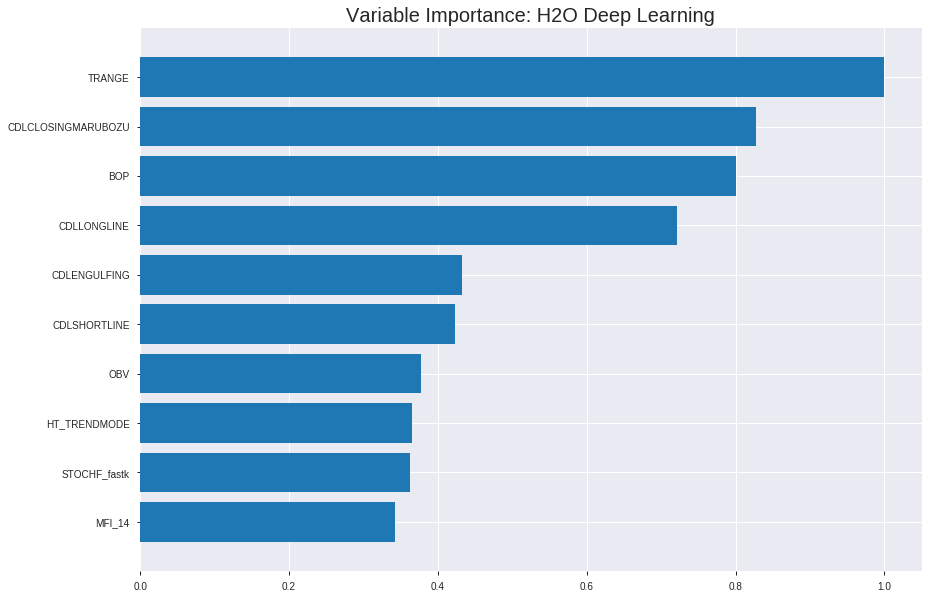

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_163812_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1894027922990114
RMSE: 0.43520431098394624
LogLoss: 0.5608641978235155
Mean Per-Class Error: 0.27336593953513
AUC: 0.8015682082914173
pr_auc: 0.7805101663050168
Gini: 0.6031364165828346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4197058485501226: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      432  376   0.4653   (376.0/808.0)
1      81   667   0.1083   (81.0/748.0)
Total  513  1043  0.2937   (457.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.419706     0.744835  226
max f2                       0.221287     0.844336  317
max f0point5                 0.513145     0.721789  159
max accuracy                 0.4892       0.725578  180
max precision                0.853915     1         0
max recall                   0.0433659    1         395
max specificity              0.853915     1         0
max absolute_mcc             0.474984     0.455879  190
max min_per_class_accuracy   0.499194     0.720588  173
max mean_per_class_accuracy  0.4892       0.726634  180

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 45.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.781057           2.08021   2.08021            1                0.801728  1                           0.801728            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.768426           1.9502    2.01521            0.9375           0.774708  0.96875                     0.788218            0.0200535       0.0414439                  95.0201   101.521
    3        0.0302057                   0.755578           1.80285   1.94743            0.866667         0.761463  0.93617                     0.779679            0.0173797       0.0588235                  80.2852   94.7434
    4        0.0404884                   0.744956           2.08021   1.98116            1                0.74913   0.952381                    0.771921            0.0213904       0.0802139                  108.021   98.1156
    5        0.0501285                   0.730611           1.80285   1.94687            0.866667         0.737065  0.935897                    0.765218            0.0173797       0.0975936                  80.2852   94.6867
    6        0.100257                    0.691644           1.84019   1.89353            0.884615         0.710725  0.910256                    0.737971            0.092246        0.18984                    84.0189   89.3528
    7        0.150386                    0.654513           1.62683   1.80463            0.782051         0.670981  0.867521                    0.715641            0.0815508       0.27139                    62.6834   80.463
    8        0.200514                    0.616512           1.5735    1.74685            0.75641          0.634844  0.839744                    0.695442            0.078877        0.350267                   57.3495   74.6846
    9        0.300129                    0.556876           1.39576   1.63032            0.670968         0.58227   0.783726                    0.657879            0.139037        0.489305                   39.5756   63.0318
    10       0.400386                    0.517604           1.32014   1.55265            0.634615         0.537274  0.746388                    0.62768             0.132353        0.621658                   32.0136   55.2648
    11       0.5                         0.495652           1.06024   1.45455            0.509677         0.5055    0.699229                    0.603338            0.105615        0.727273                   6.02381   45.4545
    12       0.600257                    0.459512           0.960099  1.37196            0.461538         0.477825  0.659529                    0.582374            0.0962567       0.823529                   -3.99013  37.1961
    13       0.699871                    0.388561           0.845506  1.29703            0.406452         0.43042   0.623508                    0.560746            0.0842246       0.907754                   -15.4494  29.703
    14       0.800129                    0.287485           0.413376  1.18631            0.198718         0.336302  0.570281                    0.532623            0.0414439       0.949198                   -58.6624  18.6307
    15       0.899743                    0.164267           0.36236   1.09508            0.174194         0.225328  0.526429                    0.498601            0.0360963       0.985294                   -63.764   9.5084
    16       1                           0.00502251         0.146682  1                  0.0705128        0.106462  0.48072                     0.459286            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20494208743467643
RMSE: 0.45270529865981957
LogLoss: 0.5974388281104343
Mean Per-Class Error: 0.3039585683519639
AUC: 0.7420572249000104
pr_auc: 0.6901224346128283
Gini: 0.4841144498000207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4508516138457038: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      142  103  0.4204   (103.0/245.0)
1      39   160  0.196    (39.0/199.0)
Total  181  263  0.3198   (142.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450852     0.692641  230
max f2                       0.16794      0.812974  349
max f0point5                 0.611825     0.66561   100
max accuracy                 0.611825     0.686937  100
max precision                0.878516     1         0
max recall                   0.0475678    1         396
max specificity              0.878516     1         0
max absolute_mcc             0.462414     0.393583  220
max min_per_class_accuracy   0.50376      0.673367  188
max mean_per_class_accuracy  0.462414     0.696041  220

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 46.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.815359           2.23116   2.23116            1                0.844548   1                           0.844548            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.790673           1.67337   1.98325            0.75             0.799939   0.888889                    0.824722            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.772677           1.78492   1.91242            0.8              0.781945   0.857143                    0.809444            0.0201005       0.0603015                  78.4925   91.2419
    4        0.0405405                   0.768289           1.67337   1.8593             0.75             0.770866   0.833333                    0.800872            0.0150754       0.0753769                  67.3367   85.9296
    5        0.0518018                   0.760959           1.78492   1.84313            0.8              0.764384   0.826087                    0.79294             0.0201005       0.0954774                  78.4925   84.3129
    6        0.101351                    0.714191           1.72407   1.78492            0.772727         0.734397   0.8                         0.764319            0.0854271       0.180905                   72.4075   78.4925
    7        0.150901                    0.669449           1.82549   1.79824            0.818182         0.693559   0.80597                     0.741084            0.0904523       0.271357                   82.5491   79.8245
    8        0.20045                     0.639074           1.72407   1.77991            0.772727         0.655691   0.797753                    0.719976            0.0854271       0.356784                   72.4075   77.9911
    9        0.29955                     0.583223           0.912746  1.49303            0.409091         0.609125   0.669173                    0.683303            0.0904523       0.447236                   -8.72545  49.3029
    10       0.400901                    0.528414           1.18995   1.41641            0.533333         0.552639   0.634831                    0.65027             0.120603        0.567839                   18.995    41.6408
    11       0.5                         0.493233           1.21699   1.37688            0.545455         0.510904   0.617117                    0.622648            0.120603        0.688442                   21.6994   37.6884
    12       0.599099                    0.443348           1.16629   1.34205            0.522727         0.470044   0.601504                    0.597405            0.115578        0.80402                    16.6286   34.2049
    13       0.70045                     0.368948           0.594975  1.23395            0.266667         0.413659   0.553055                    0.570818            0.0603015       0.864322                   -40.5025  23.3951
    14       0.79955                     0.253584           0.608497  1.15643            0.272727         0.30842    0.51831                     0.538296            0.0603015       0.924623                   -39.1503  15.643
    15       0.898649                    0.155453           0.456373  1.07923            0.204545         0.199028   0.483709                    0.500883            0.0452261       0.969849                   -54.3627  7.92307
    16       1                           0.0287636          0.297487  1                  0.133333         0.0978021  0.448198                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:47:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:47:40  2 min 59.014 sec  414 obs/sec       0.531491  1             827        0.602604         1.47421             -0.454688      0.665145        0.634668           1.69017          0.444087                         0.582455           1.40318               -0.371741        0.654066          0.609577             1.78492            0.434685
    2019-08-27 16:47:52  3 min 11.584 sec  632 obs/sec       5.44152   10            8467       0.466818         0.622814            0.127026       0.736696        0.707016           1.9502           0.355398                         0.471322           0.638428              0.101782         0.729146          0.678347             1.78492            0.344595
    2019-08-27 16:48:05  3 min 24.021 sec  722 obs/sec       11.4479   21            17813      0.445441         0.579195            0.205147       0.760116        0.735255           1.9502           0.325193                         0.466288           0.625788              0.120867         0.720439          0.660798             2.23116            0.380631
    2019-08-27 16:48:16  3 min 35.623 sec  774 obs/sec       17.4704   32            27184      0.438941         0.566351            0.228174       0.77597         0.744487           1.9502           0.313625                         0.461276           0.617865              0.139663         0.737535          0.67806              2.23116            0.337838
    2019-08-27 16:48:28  3 min 48.003 sec  824 obs/sec       24.5238   45            38159      0.434967         0.559095            0.242086       0.790606        0.767218           1.9502           0.316195                         0.453829           0.599739              0.167218         0.738683          0.684596             2.23116            0.310811
    2019-08-27 16:48:41  4 min  0.027 sec  861 obs/sec       31.6613   58            49265      0.435204         0.560864            0.241261       0.801568        0.78051            2.08021          0.293702                         0.452705           0.597439              0.171337         0.742057          0.690122             2.23116            0.31982
    2019-08-27 16:48:53  4 min 12.121 sec  897 obs/sec       39.2879   72            61132      0.429391         0.547146            0.261395       0.806197        0.785222           2.08021          0.284062                         0.459166           0.612417              0.147515         0.729433          0.667679             2.23116            0.346847
    2019-08-27 16:49:05  4 min 24.076 sec  927 obs/sec       47.0174   86            73159      0.421509         0.531385            0.288264       0.811648        0.790574           2.08021          0.275064                         0.471519           0.659241              0.10103          0.731771          0.675227             2.23116            0.34009
    2019-08-27 16:49:06  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
TRANGE                   1.0                    1.0                  0.018493318262856367
CDLCLOSINGMARUBOZU       0.8281776905059814     0.8281776905059814   0.015315753608724475
BOP                      0.800117015838623      0.800117015838623    0.014796818621430544
CDLLONGLINE              0.721602201461792      0.721602201461792    0.013344819170810717
CDLENGULFING             0.4324841797351837     0.4324841797351837   0.007998067579493128
---                      ---                    ---                  ---
BBANDS_lowerband_14_7_4  0.20066313445568085    0.20066313445568085  0.0037109272091112454
KAMA_20                  0.20042075216770172    0.20042075216770172  0.003706444756318368
BBANDS_upperband_30_2_4  0.19885075092315674    0.19885075092315674  0.003677410223629917
TYPPRICE                 0.19868913292884827    0.19868913292884827  0.003674421370624166
CDLSEPARATINGLINES       0.1921132653951645     0.1921132653951645   0.0035528117594693675


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.7333333333333334)

('auc', 0.7670250896057348)

('logloss', 0.5969947452779383)

('mean_per_class_error', 0.24820788530465943)

('rmse', 0.4512476096976646)

('mse', 0.20362440525785586)

deeplearning prediction progress: |███████████████████████████████████████| 100%


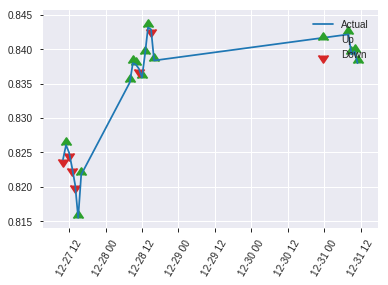


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20362440525785586
RMSE: 0.4512476096976646
LogLoss: 0.5969947452779383
Mean Per-Class Error: 0.24820788530465943
AUC: 0.7670250896057348
pr_auc: 0.684621610572586
Gini: 0.5340501792114696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48738250721296145: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   34   0.2742   (34.0/124.0)
1      22   77   0.2222   (22.0/99.0)
Total  112  111  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487383     0.733333  110
max f2                       0.0911241    0.805921  211
max f0point5                 0.487383     0.709024  110
max accuracy                 0.487383     0.748879  110
max precision                0.743546     1         0
max recall                   0.0668551    1         218
max specificity              0.743546     1         0
max absolute_mcc             0.487383     0.500415  110
max min_per_class_accuracy   0.496833     0.737374  104
max mean_per_class_accuracy  0.487383     0.751792  110

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 42.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.736459           1.50168   1.50168            0.666667         0.739005  0.666667                    0.739005            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.729261           2.25253   1.80202            1                0.733161  0.8                         0.736667            0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.71292            2.25253   1.93074            1                0.726428  0.857143                    0.733742            0.020202        0.0606061                  125.253   93.0736
    4        0.0403587                   0.681823           1.12626   1.75196            0.5              0.69467   0.777778                    0.725059            0.010101        0.0707071                  12.6263   75.1964
    5        0.0538117                   0.662329           2.25253   1.8771             1                0.672917  0.833333                    0.712024            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.61379            1.6382    1.76285            0.727273         0.641541  0.782609                    0.678315            0.0808081       0.181818                   63.82     76.2846
    7        0.152466                    0.580747           1.22865   1.59002            0.545455         0.595685  0.705882                    0.651582            0.0606061       0.242424                   22.865    59.0018
    8        0.201794                    0.562111           1.84298   1.65185            0.818182         0.569529  0.733333                    0.631524            0.0909091       0.333333                   84.2975   65.1852
    9        0.300448                    0.526754           1.53581   1.61375            0.681818         0.545486  0.716418                    0.603273            0.151515        0.484848                   53.5813   61.3749
    10       0.399103                    0.50691            1.43343   1.56917            0.636364         0.517527  0.696629                    0.582077            0.141414        0.626263                   43.3425   56.9175
    11       0.502242                    0.4854             1.46904   1.54861            0.652174         0.498875  0.6875                      0.564991            0.151515        0.777778                   46.9038   54.8611
    12       0.600897                    0.444602           0.40955   1.3616             0.181818         0.468657  0.604478                    0.549175            0.040404        0.818182                   -59.045   36.1601
    13       0.699552                    0.375274           0.716713  1.27066            0.318182         0.409628  0.564103                    0.529495            0.0707071       0.888889                   -28.3287  27.0655
    14       0.798206                    0.213196           0.307163  1.15157            0.136364         0.292014  0.511236                    0.500144            0.030303        0.919192                   -69.2837  15.1572
    15       0.896861                    0.139776           0.307163  1.05869            0.136364         0.180057  0.47                        0.464934            0.030303        0.949495                   -69.2837  5.86869
    16       1                           0.0293871          0.489679  1                  0.217391         0.088306  0.443946                    0.426089          

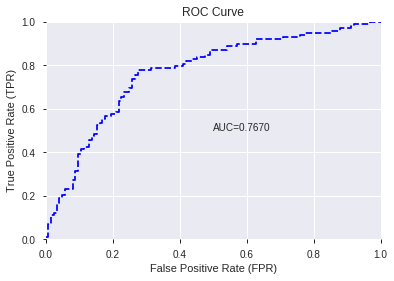

This function is available for GLM models only


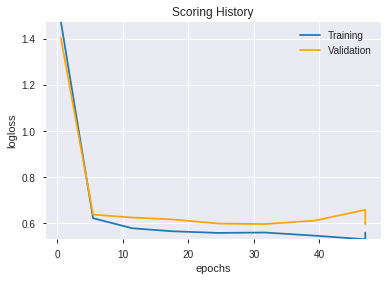

--2019-08-27 16:49:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


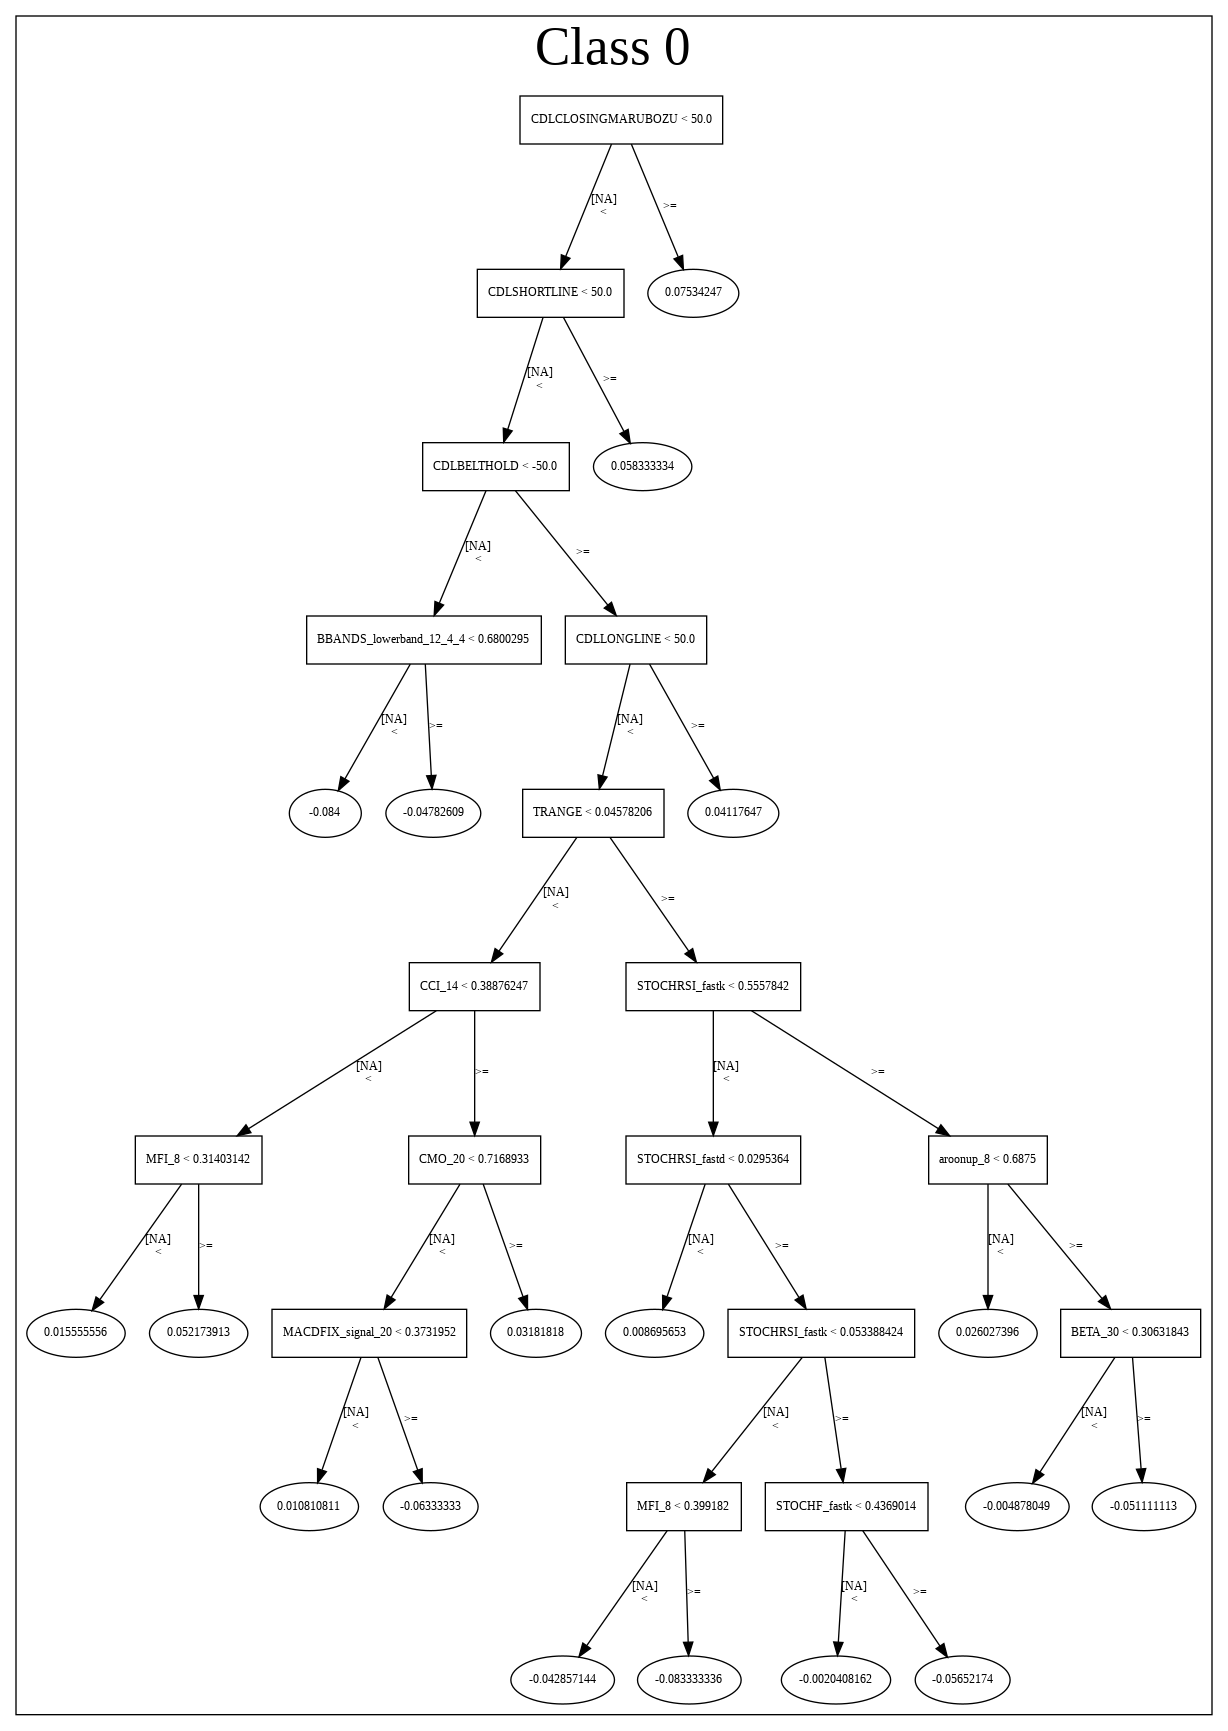

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_163812_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_163812_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLSHORTLINE',
 'OBV',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'MFI_14',
 'STDDEV_8',
 'ADOSC',
 'CDLGRAVESTONEDOJI',
 'CDLBELTHOLD',
 'CDLRICKSHAWMAN',
 'CCI_8',
 'DX_14',
 'CDLIDENTICAL3CROWS',
 'ULTOSC',
 'CDLLADDERBOTTOM',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'STOCHRSI_fastd',
 'ADXR_14',
 'WILLR_8',
 'BETA_20',
 'ADX_24',
 'CORREL_20',
 'CDLGAPSIDESIDEWHITE',
 'STOCHF_fastd',
 'aroondown_8',
 'STOCH_slowk',
 'AD',
 'PLUS_DM_8',
 'BETA_14',
 'CCI_20',
 'HT_PHASOR_quadrature',
 'aroonup_8',
 'STOCH_slowd',
 'DX_24',
 'WILLR_30',
 'CDLHIKKAKE',
 'aroonup_20',
 'aroonup_30',
 'aroonup_24',
 'CORREL_12',
 'ADXR_12',
 'WILLR_20',
 'MFI_30',
 'CCI_30',
 'aroondown_20',
 'AROONOSC_20',
 'BETA_8',
 'AROONOSC_24',
 'ATR_12',
 'aroondown_14',
 'VAR_14',
 'aroondown_30',
 'CCI_14',
 'aroonup_14',
 'MFI_8',
 'PLUS_DM_20',
 'DX_30',
 'ATR_30',
 'MFI_20',
 'ADX_14',
 'CDLDOJISTAR',
 'VAR_12',
 'PPO',
 'MFI_24',
 'RSI_8',
 'C

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_164925_model_1  0.789752  0.564419              0.259205  0.433487  0.187911

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.554394           1.000000  6.484194e-02
1                      TRANGE             0.467806           0.843815  5.471458e-02
2          CDLCLOSINGMARUBOZU             0.249745           0.450482  2.921011e-02
3                      MFI_14             0.200020           0.360790  2.339431e-02
4                      ULTOSC             0.196578           0.354581  2.299170e-02
..                        ...                  ...                ...           ...
211  BBANDS_middleband_24_2_2             0.000359           0.000648  4.203777e-05
212  BBANDS_middleband_20_2_4             0.000314           0.000566  3.670038e-05
213   BBANDS_upperband_14_7_2             0.000242           0.000437  2.831763e-05
214   BBANDS_upperband_24_7_4             0.000178           0.000320  2.076326e-05
215              LINEARREG_20             0.000008           0.000014  8.810117e-07

[216 rows x 4 columns]

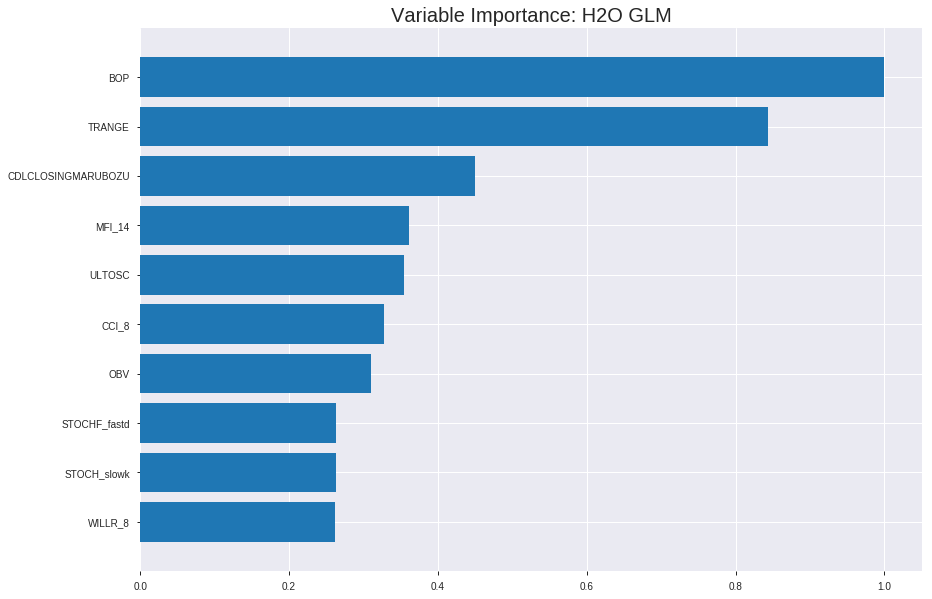

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_164925_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18721385040149438
RMSE: 0.43268215863552123
LogLoss: 0.5538584780702689
Null degrees of freedom: 1555
Residual degrees of freedom: 1339
Null deviance: 2154.759827525797
Residual deviance: 1723.6075837546766
AIC: 2157.607583754677
AUC: 0.7906786083020066
pr_auc: 0.7661477737207897
Gini: 0.5813572166040133
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.368279929071294: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      420  388   0.4802   (388.0/808.0)
1      86   662   0.115    (86.0/748.0)
Total  506  1050  0.3046   (474.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36828      0.736374  249
max f2                       0.167947     0.842838  342
max f0point5                 0.583747     0.709897  147
max accuracy                 0.522634     0.715938  179
max precision                0.950857     1         0
max recall                   0.0251653    1         393
max specificity              0.950857     1         0
max absolute_mcc             0.36828      0.431775  249
max min_per_class_accuracy   0.505191     0.71123   187
max mean_per_class_accuracy  0.515803     0.715217  182

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.897209           2.08021   2.08021            1                0.922736   1                           0.922736            0.0213904       0.0213904                  108.021   108.021
    2        0.0205656                   0.879237           1.82019   1.9502             0.875            0.88693    0.9375                      0.904833            0.0187166       0.040107                   82.0187   95.0201
    3        0.0302057                   0.860206           1.80285   1.90317            0.866667         0.868942   0.914894                    0.893379            0.0173797       0.0574866                  80.2852   90.3174
    4        0.0404884                   0.846348           1.9502    1.91512            0.9375           0.853868   0.920635                    0.883344            0.0200535       0.0775401                  95.0201   91.5118
    5        0.0501285                   0.827356           1.80285   1.89353            0.866667         0.837481   0.910256                    0.874524            0.0173797       0.0949198                  80.2852   89.3528
    6        0.100257                    0.766513           1.78685   1.84019            0.858974         0.795767   0.884615                    0.835146            0.0895722       0.184492                   78.685    84.0189
    7        0.150386                    0.722106           1.6535    1.77796            0.794872         0.743774   0.854701                    0.804688            0.0828877       0.26738                    65.3503   77.7961
    8        0.200514                    0.681266           1.5735    1.72684            0.75641          0.700616   0.830128                    0.77867             0.078877        0.346257                   57.3495   72.6844
    9        0.300129                    0.62443            1.34207   1.59914            0.645161         0.652563   0.768737                    0.736814            0.13369         0.479947                   34.2073   59.9137
    10       0.400386                    0.567973           1.33347   1.53261            0.641026         0.596581   0.736758                    0.7017              0.13369         0.613636                   33.347    53.2613
    11       0.5                         0.497852           1.07366   1.44118            0.516129         0.532041   0.692802                    0.667899            0.106952        0.720588                   7.36588   44.1176
    12       0.600257                    0.427635           0.933429  1.35637            0.448718         0.461739   0.652034                    0.633465            0.0935829       0.814171                   -6.65707  35.6371
    13       0.699871                    0.344694           0.872348  1.28748            0.419355         0.38589    0.618916                    0.598227            0.0868984       0.90107                    -12.7652  28.7479
    14       0.800129                    0.272984           0.480049  1.18631            0.230769         0.309578   0.570281                    0.562059            0.0481283       0.949198                   -51.9951  18.6307
    15       0.899743                    0.159006           0.389201  1.09806            0.187097         0.212548   0.527857                    0.523363            0.0387701       0.987968                   -61.0799  9.80558
    16       1                           0.00142156         0.120012  1                  0.0576923        0.0980225  0.48072                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20220569304728273
RMSE: 0.44967287337272493
LogLoss: 0.5871120902002349
Null degrees of freedom: 443
Residual degrees of freedom: 227
Null deviance: 612.6260558984648
Residual deviance: 521.3555360978086
AIC: 955.3555360978086
AUC: 0.7481489078043277
pr_auc: 0.6946155936923364
Gini: 0.4962978156086555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4092351300170734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  116  0.4735   (116.0/245.0)
1      30   169  0.1508   (30.0/199.0)
Total  159  285  0.3288   (146.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409235     0.698347  253
max f2                       0.216679     0.817717  336
max f0point5                 0.611856     0.656136  135
max accuracy                 0.469939     0.691441  218
max precision                0.966521     1         0
max recall                   0.0926283    1         384
max specificity              0.966521     1         0
max absolute_mcc             0.469939     0.398551  218
max min_per_class_accuracy   0.530165     0.668342  187
max mean_per_class_accuracy  0.469939     0.69918   218

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 48.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.91541            2.23116   2.23116            1                0.937245  1                           0.937245            0.0251256       0.0251256                  123.116   123.116
    2        0.0202703                   0.884601           1.67337   1.98325            0.75             0.896805  0.888889                    0.919272            0.0150754       0.040201                   67.3367   98.325
    3        0.0315315                   0.87082            2.23116   2.07179            1                0.875482  0.928571                    0.903632            0.0251256       0.0653266                  123.116   107.179
    4        0.0405405                   0.848684           2.23116   2.1072             1                0.857196  0.944444                    0.893313            0.0201005       0.0854271                  123.116   110.72
    5        0.0518018                   0.82668            1.78492   2.03714            0.8              0.83571   0.913043                    0.880791            0.0201005       0.105528                   78.4925   103.714
    6        0.101351                    0.77267            1.62266   1.83451            0.727273         0.799108  0.822222                    0.840857            0.080402        0.18593                    62.2659   83.4506
    7        0.150901                    0.711258           1.52124   1.73164            0.681818         0.741846  0.776119                    0.808346            0.0753769       0.261307                   52.1243   73.1643
    8        0.20045                     0.67636            1.11558   1.57936            0.5              0.694849  0.707865                    0.780291            0.0552764       0.316583                   11.5578   57.9357
    9        0.29955                     0.639732           1.47053   1.54336            0.659091         0.656144  0.691729                    0.739219            0.145729        0.462312                   47.0534   54.3356
    10       0.400901                    0.571084           1.09079   1.42894            0.488889         0.608308  0.640449                    0.706124            0.110553        0.572864                   9.07873   42.8942
    11       0.5                         0.521137           1.21699   1.38693            0.545455         0.545374  0.621622                    0.674264            0.120603        0.693467                   21.6994   38.6935
    12       0.599099                    0.442292           1.16629   1.35044            0.522727         0.477424  0.605263                    0.641704            0.115578        0.809045                   16.6286   35.0436
    13       0.70045                     0.364823           0.694137  1.25547            0.311111         0.400575  0.562701                    0.606814            0.0703518       0.879397                   -30.5863  25.5474
    14       0.79955                     0.271419           0.557789  1.169              0.25             0.315157  0.523944                    0.570665            0.0552764       0.934673                   -44.2211  16.9
    15       0.898649                    0.170714           0.405665  1.08482            0.181818         0.221811  0.486216                    0.532195            0.040201        0.974874                   -59.4335  8.48226
    16       1                           0.0135325          0.247906  1                  0.111111         0.102578  0.448198                    0.488652            0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 16:49:26  0.000 sec   2            .2E2      216           1.3675526063969214  1.3633540624433842
     2019-08-27 16:49:26  0.129 sec   4            .15E2     217           1.3622429104873648  1.3584972897197851
     2019-08-27 16:49:26  0.248 sec   6            .11E2     217           1.3555296843459828  1.3524492870006097
     2019-08-27 16:49:26  0.368 sec   8            .77E1     217           1.3471770318527128  1.345027116885046
     2019-08-27 16:49:26  0.492 sec   10           .56E1     217           1.3370051591645875  1.3361028706706466
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 16:49:29  2.829 sec   46           .19E-1    217           1.1018515583682862  1.1750893973293675
     2019-08-27 16:49:29  2.961 sec   48           .13E-1    217           1.0968927377060218  1.1770689420054712
     2019-08-27 16:49:29  3.094 sec   50           .98E-2    217           1.0927569620813378  1.1800652434279197
     2019-08-27 16:49:29  3.232 sec   52           .71E-2    217           1.08925425934368    1.1840245697462621
     2019-08-27 16:49:29  3.367 sec   54           .52E-2    217           1.0862853726872348  1.1888168652514906


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7443946188340808)

('F1', 0.7381974248927038)

('auc', 0.7897523623330075)

('logloss', 0.5644193220448337)

('mean_per_class_error', 0.25521342456826335)

('rmse', 0.4334871026989693)

('mse', 0.18791106820634673)

glm prediction progress: |████████████████████████████████████████████████| 100%


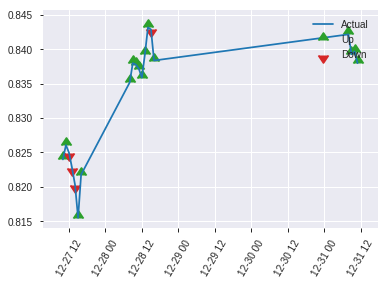


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.18791106820634673
RMSE: 0.4334871026989693
LogLoss: 0.5644193220448337
Null degrees of freedom: 222
Residual degrees of freedom: 6
Null deviance: 307.54649216112034
Residual deviance: 251.73101763199574
AIC: 685.7310176319958
AUC: 0.7897523623330075
pr_auc: 0.690771484726626
Gini: 0.579504724666015
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36691801456674844: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   48   0.3871   (48.0/124.0)
1      13   86   0.1313   (13.0/99.0)
Total  89   134  0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366918     0.738197  133
max f2                       0.26235      0.831874  174
max f0point5                 0.541336     0.714286  95
max accuracy                 0.541336     0.744395  95
max precision                0.942189     1         0
max recall                   0.0751606    1         216
max specificity              0.942189     1         0
max absolute_mcc             0.414877     0.489573  123
max min_per_class_accuracy   0.497996     0.737374  104
max mean_per_class_accuracy  0.414877     0.744787  123

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 46.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.936305           1.50168   1.50168            0.666667         0.940378   0.666667                    0.940378            0.020202        0.020202                   50.1684   50.1684
    2        0.0224215                   0.912669           2.25253   1.80202            1                0.924502   0.8                         0.934027            0.020202        0.040404                   125.253   80.202
    3        0.0313901                   0.888864           1.12626   1.60895            0.5              0.901238   0.714286                    0.924659            0.010101        0.0505051                  12.6263   60.8947
    4        0.0403587                   0.879041           2.25253   1.75196            1                0.883729   0.777778                    0.915563            0.020202        0.0707071                  125.253   75.1964
    5        0.0538117                   0.858365           0.750842  1.50168            0.333333         0.865744   0.666667                    0.903109            0.010101        0.0808081                  -24.9158  50.1684
    6        0.103139                    0.773357           1.84298   1.66491            0.818182         0.8193     0.73913                     0.863026            0.0909091       0.171717                   84.2975   66.491
    7        0.152466                    0.705273           1.6382    1.65627            0.727273         0.734003   0.735294                    0.821283            0.0808081       0.252525                   63.82     65.6269
    8        0.201794                    0.669533           1.84298   1.70191            0.818182         0.687024   0.755556                    0.788465            0.0909091       0.343434                   84.2975   70.1908
    9        0.300448                    0.612707           1.43343   1.61375            0.636364         0.63495    0.716418                    0.738057            0.141414        0.484848                   43.3425   61.3749
    10       0.399103                    0.558885           1.53581   1.59448            0.681818         0.59179    0.707865                    0.701901            0.151515        0.636364                   53.5813   59.4484
    11       0.502242                    0.471251           1.17523   1.50839            0.521739         0.516921   0.669643                    0.663914            0.121212        0.757576                   17.5231   50.8387
    12       0.600897                    0.36627            1.12626   1.44565            0.5              0.415368   0.641791                    0.623108            0.111111        0.868687                   12.6263   44.5651
    13       0.699552                    0.31753            0.307163  1.28509            0.136364         0.339509   0.570513                    0.583113            0.030303        0.89899                    -69.2837  28.5095
    14       0.798206                    0.253088           0.614325  1.20219            0.272727         0.286371   0.533708                    0.546437            0.0606061       0.959596                   -38.5675  20.219
    15       0.896861                    0.149295           0         1.06995            0                0.200996   0.475                       0.508439            0               0.959596                   -100      6.99495
    16       1                           0.0133983          0.391744  1                  0.173913         0.0937427  0.443946                    0.

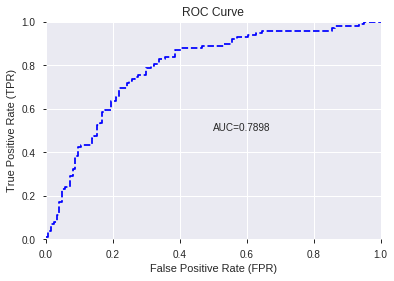

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


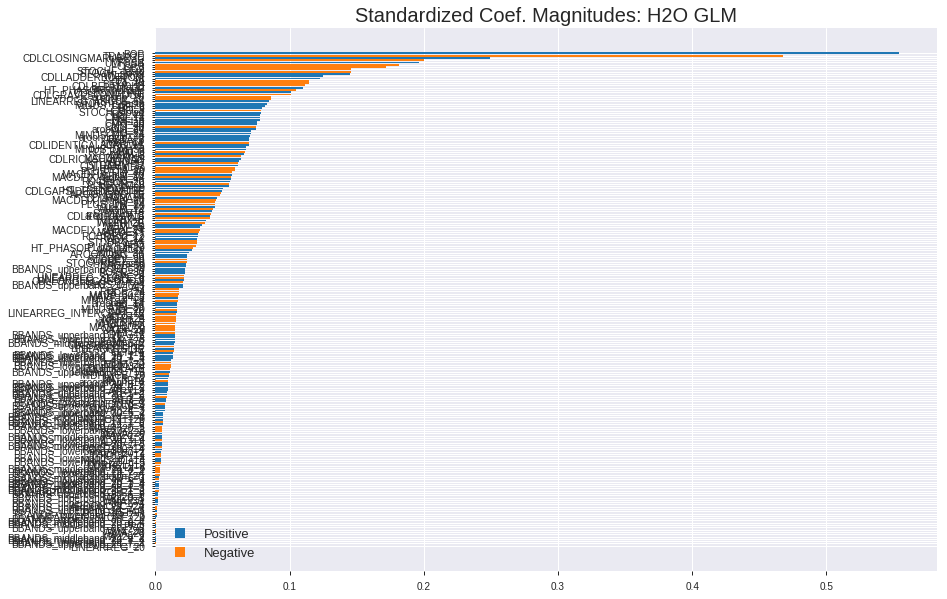

'log_likelihood'
--2019-08-27 16:49:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


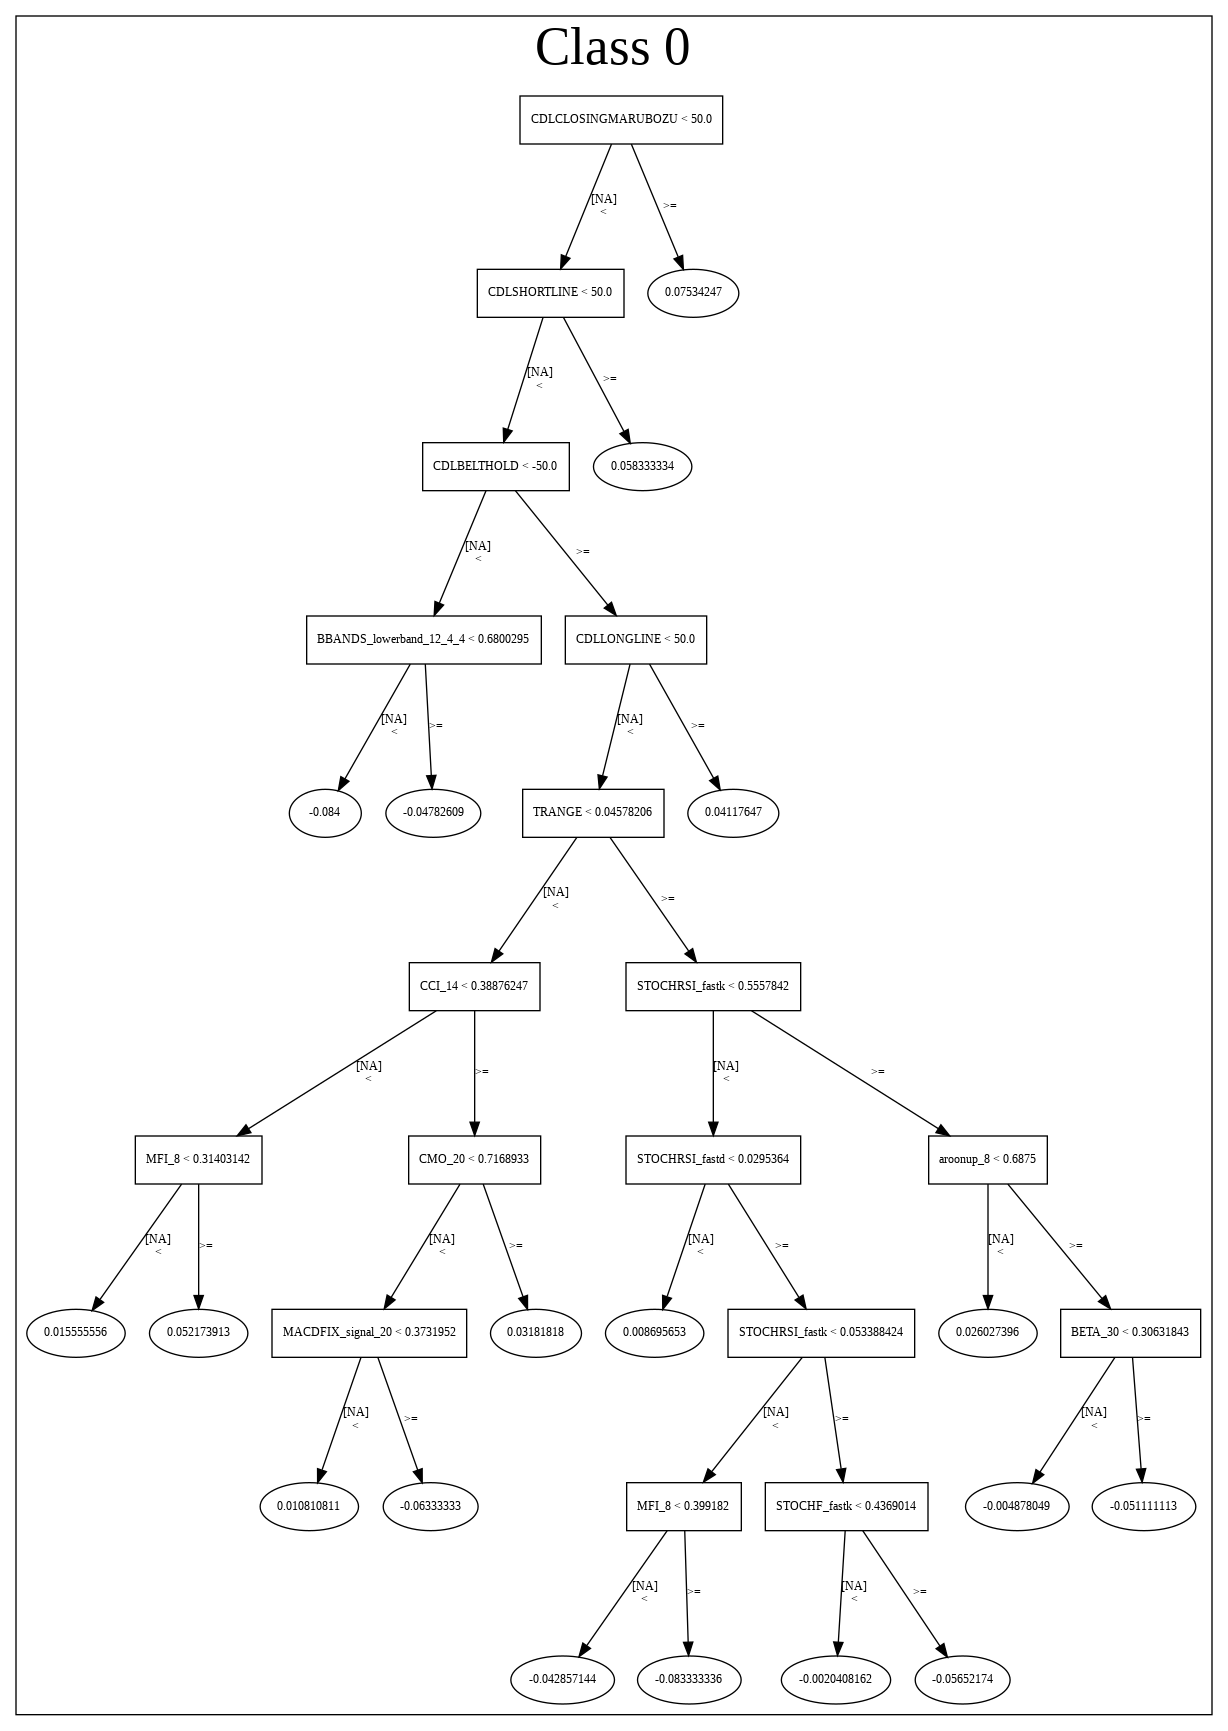

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_164925_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_164925_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'MFI_14',
 'ULTOSC',
 'CCI_8',
 'OBV',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_8',
 'CDLLADDERBOTTOM',
 'DX_14',
 'CCI_20',
 'BETA_14',
 'CDLBELTHOLD',
 'aroonup_30',
 'HT_PHASOR_inphase',
 'CDLLONGLINE',
 'CDLGRAVESTONEDOJI',
 'aroonup_20',
 'LINEARREG_ANGLE_14',
 'STOCHF_fastk',
 'MINUS_DM_20',
 'RSI_8',
 'CMO_8',
 'STOCH_slowd',
 'RSI_24',
 'CMO_14',
 'RSI_14',
 'MFI_8',
 'CMO_30',
 'CMO_20',
 'CCI_30',
 'aroonup_24',
 'CMO_24',
 'MINUS_DM_24',
 'aroondown_30',
 'BETA_8',
 'VAR_14',
 'ADXR_14',
 'CDLIDENTICAL3CROWS',
 'MINUS_DM_30',
 'ROCR100_8',
 'MACD',
 'MOM_8',
 'MACDFIX_14',
 'CDLRICKSHAWMAN',
 'ADOSC',
 'STDDEV_12',
 'CDLHAMMER',
 'BETA_20',
 'PLUS_DM_20',
 'MACDFIX_hist_20',
 'WILLR_30',
 'MACDFIX_signal_14',
 'ROCR100_20',
 'ROCR_20',
 'PLUS_DM_8',
 'ROCP_20',
 'HT_TRENDMODE',
 'CDLGAPSIDESIDEWHITE',
 'AROONOSC_20',
 'MOM_24',
 'CDLHARAMI',
 'MACDFIX_signal_20',
 'PLUS_DM_24',
 'DX_30',
 'WILLR_12',
 'MOM_14',
 'STDDEV_8',
 'aroond

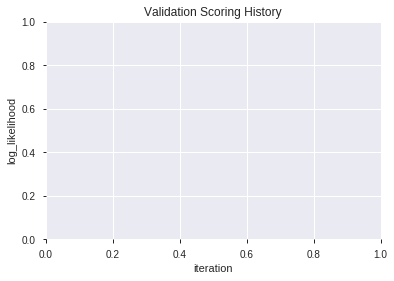

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_164949_model_4  0.795699  0.553479              0.241080  0.430920  0.185692
1  XGBoost_grid_1_AutoML_20190827_164949_model_6  0.788775  0.565639              0.259286  0.437745  0.191621
2  XGBoost_grid_1_AutoML_20190827_164949_model_2  0.787797  0.558092              0.257209  0.434042  0.188392
3  XGBoost_grid_1_AutoML_20190827_164949_model_1  0.785924  0.562923              0.261241  0.435936  0.190040
4  XGBoost_grid_1_AutoML_20190827_164949_model_7  0.781443  0.559695              0.260305  0.435084  0.189298
5               XGBoost_2_AutoML_20190827_164949  0.775823  0.568146              0.275334  0.438616  0.192384
6  XGBoost_grid_1_AutoML_20190827_164949_model_3  0.769306  0.570273              0.258187  0.440584  0.194114
7  XGBoost_grid_1_AutoML_20190827_164949_model_5  0.767432  0.574045              0.281484  0.443719  0.196887
8               XGBoost_3_AutoML_20190827_164949  0.766944  0.569534              0.264255  0.440213  0.193788
9               XGBoost_1_AutoML_20190827_164949  0.760427  0.573215              0.242098  0.442277  0.195609

variable  relative_importance  scaled_importance  percentage
0                        BOP          1984.497803           1.000000    0.398751
1                     TRANGE           757.812744           0.381866    0.152270
2                      ADOSC            79.432556           0.040027    0.015961
3                     MFI_14            74.761169           0.037673    0.015022
4                STOCH_slowd            72.090950           0.036327    0.014485
..                       ...                  ...                ...         ...
97   BBANDS_lowerband_20_2_5             4.925143           0.002482    0.000990
98   BBANDS_upperband_20_6_4             4.724791           0.002381    0.000949
99   BBANDS_lowerband_20_6_3             4.647759           0.002342    0.000934
100  BBANDS_lowerband_30_5_2             4.269275           0.002151    0.000858
101  BBANDS_upperband_14_7_3             3.837282           0.001934    0.000771

[102 rows x 4 columns]

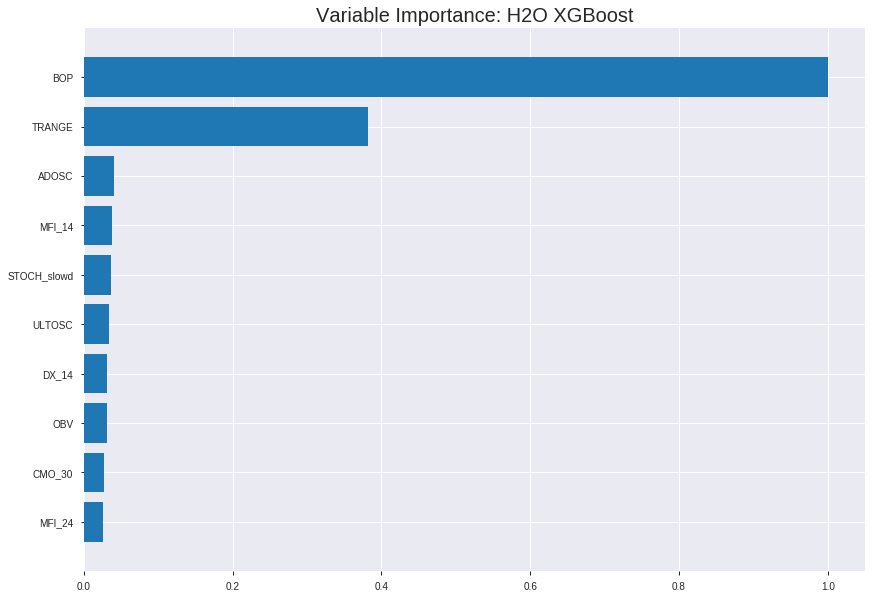

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_164949_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17156955267525487
RMSE: 0.4142095516465728
LogLoss: 0.5207191572909042
Mean Per-Class Error: 0.2354397204426325
AUC: 0.8428515645682215
pr_auc: 0.8228787767227114
Gini: 0.685703129136443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47777096927165985: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      559  249  0.3082   (249.0/808.0)
1      128  620  0.1711   (128.0/748.0)
Total  687  869  0.2423   (377.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477771     0.766852  203
max f2                       0.331881     0.857212  284
max f0point5                 0.594929     0.765272  135
max accuracy                 0.49655      0.762853  195
max precision                0.833082     1         0
max recall                   0.134382     1         375
max specificity              0.833082     1         0
max absolute_mcc             0.49655      0.529958  195
max min_per_class_accuracy   0.517828     0.75495   180
max mean_per_class_accuracy  0.49655      0.76456   195

Gains/Lift Table: Avg response rate: 48.07 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.807296           1.9502     1.9502             0.9375           0.816037  0.9375                      0.816037            0.0200535       0.0200535                  95.0201   95.0201
    2        0.0205656                   0.791058           1.9502     1.9502             0.9375           0.797481  0.9375                      0.806759            0.0200535       0.040107                   95.0201   95.0201
    3        0.0302057                   0.778818           2.08021    1.99169            1                0.784119  0.957447                    0.799533            0.0200535       0.0601604                  108.021   99.1694
    4        0.0404884                   0.769022           1.9502     1.98116            0.9375           0.773675  0.952381                    0.792966            0.0200535       0.0802139                  95.0201   98.1156
    5        0.0501285                   0.761079           1.80285    1.94687            0.866667         0.764349  0.935897                    0.787463            0.0173797       0.0975936                  80.2852   94.6867
    6        0.100257                    0.733016           1.94687    1.94687            0.935897         0.7459    0.935897                    0.766681            0.0975936       0.195187                   94.6867   94.6867
    7        0.150386                    0.706139           1.84019    1.91131            0.884615         0.719921  0.918803                    0.751095            0.092246        0.287433                   84.0189   91.1308
    8        0.200514                    0.683617           1.6535     1.84686            0.794872         0.69496   0.887821                    0.737061            0.0828877       0.370321                   65.3503   84.6857
    9        0.300129                    0.625169           1.61049    1.7684             0.774194         0.654833  0.850107                    0.709769            0.160428        0.530749                   61.0488   76.8405
    10       0.400386                    0.573187           1.24013    1.63612            0.596154         0.600547  0.786517                    0.68242             0.124332        0.65508                    24.0128   63.6123
    11       0.5                         0.511976           1.11392    1.53209            0.535484         0.542936  0.736504                    0.654631            0.110963        0.766043                   11.3921   53.2086
    12       0.600257                    0.445827           0.840086   1.41651            0.403846         0.481638  0.680942                    0.625737            0.0842246       0.850267                   -15.9914  41.6505
    13       0.699871                    0.373776           0.751561   1.32186            0.36129          0.408997  0.635445                    0.594888            0.0748663       0.925134                   -24.8439  32.1862
    14       0.800129                    0.25348            0.426711   1.2097             0.205128         0.320809  0.581526                    0.560545            0.0427807       0.967914                   -57.3289  20.9699
    15       0.899743                    0.162724           0.281835   1.10697            0.135484         0.204556  0.532143                    0.521132            0.0280749       0.995989                   -71.8165  10.6971
    16       1                           0.0819506          0.0400041  1                  0.0192308        0.131586  0.48072                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20511450381101892
RMSE: 0.4528956875606335
LogLoss: 0.5960311415694013
Mean Per-Class Error: 0.3041123987283355
AUC: 0.7388267869962055
pr_auc: 0.6718902490900137
Gini: 0.47765357399241104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4288606494665146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      141  104  0.4245   (104.0/245.0)
1      37   162  0.1859   (37.0/199.0)
Total  178  266  0.3176   (141.0/444.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428861     0.696774  243
max f2                       0.16161      0.820215  371
max f0point5                 0.442594     0.643725  237
max accuracy                 0.442594     0.684685  237
max precision                0.832256     1         0
max recall                   0.137421     1         386
max specificity              0.832256     1         0
max absolute_mcc             0.441448     0.395823  239
max min_per_class_accuracy   0.524394     0.677551  194
max mean_per_class_accuracy  0.441448     0.695888  239

Gains/Lift Table: Avg response rate: 44.82 %, avg score: 46.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112613                   0.79114            1.78492   1.78492            0.8              0.814512  0.8                         0.814512            0.0201005       0.0201005                  78.4925   78.4925
    2        0.0202703                   0.780047           2.23116   1.98325            1                0.788377  0.888889                    0.802897            0.0201005       0.040201                   123.116   98.325
    3        0.0315315                   0.772755           0.892462  1.59368            0.4              0.776933  0.714286                    0.793624            0.0100503       0.0502513                  -10.7538  59.3683
    4        0.0405405                   0.766223           1.67337   1.61139            0.75             0.768358  0.722222                    0.788009            0.0150754       0.0653266                  67.3367   61.139
    5        0.0518018                   0.751631           1.78492   1.64912            0.8              0.760292  0.73913                     0.781984            0.0201005       0.0854271                  78.4925   64.9115
    6        0.101351                    0.730063           2.02832   1.83451            0.909091         0.740019  0.822222                    0.761468            0.100503        0.18593                    102.832   83.4506
    7        0.150901                    0.701097           1.72407   1.79824            0.772727         0.717837  0.80597                     0.747141            0.0854271       0.271357                   72.4075   79.8245
    8        0.20045                     0.667301           1.11558   1.6295             0.5              0.682365  0.730337                    0.731129            0.0552764       0.326633                   11.5578   62.9496
    9        0.29955                     0.606785           1.21699   1.49303            0.545455         0.63862   0.669173                    0.700525            0.120603        0.447236                   21.6994   49.3029
    10       0.400901                    0.560235           1.28911   1.44148            0.577778         0.584179  0.646067                    0.671112            0.130653        0.577889                   28.9112   44.1477
    11       0.5                         0.509721           1.11558   1.37688            0.5              0.537946  0.617117                    0.644718            0.110553        0.688442                   11.5578   37.6884
    12       0.599099                    0.427007           1.2677    1.35882            0.568182         0.469376  0.609023                    0.615714            0.125628        0.81407                    26.7702   35.8824
    13       0.70045                     0.33406            0.594975  1.2483             0.266667         0.381839  0.559486                    0.581874            0.0603015       0.874372                   -40.5025  24.8299
    14       0.79955                     0.233665           0.507081  1.15643            0.227273         0.272781  0.51831                     0.543564            0.0502513       0.924623                   -49.2919  15.643
    15       0.898649                    0.174786           0.304249  1.06246            0.136364         0.202726  0.47619                     0.505978            0.0301508       0.954774                   -69.5751  6.24551
    16       1                           0.106312           0.446231  1                  0.2              0.144075  0.448198                    0.469298            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:50:01  5.369 sec   0                  0.5              0.693147            0.5             0                  1                0.51928                          0.5                0.693147              0.5               0                    1                  0.551802
    2019-08-27 16:50:01  5.673 sec   5                  0.477378         0.648625            0.78835         0.747888           1.9762           0.309769                         0.481813           0.657185              0.723218          0.652925             1.78492            0.349099
    2019-08-27 16:50:01  5.777 sec   10                 0.462124         0.618789            0.794555        0.763633           1.69017          0.292416                         0.4706             0.63487               0.728705          0.657708             2.23116            0.364865
    2019-08-27 16:50:01  5.890 sec   15                 0.452077         0.598773            0.800953        0.777753           2.08021          0.303985                         0.464265           0.62187               0.733104          0.664252             1.78492            0.369369
    2019-08-27 16:50:01  6.012 sec   20                 0.444617         0.583456            0.8061          0.783127           2.08021          0.307198                         0.460654           0.613902              0.731904          0.651641             1.33869            0.34009
    2019-08-27 16:50:01  6.137 sec   25                 0.439244         0.572243            0.809653        0.787845           2.08021          0.300129                         0.457988           0.607941              0.734991          0.660797             2.23116            0.344595
    2019-08-27 16:50:02  6.257 sec   30                 0.433995         0.561209            0.814055        0.791996           2.08021          0.289846                         0.455123           0.60167               0.739473          0.665085             1.78492            0.34009
    2019-08-27 16:50:02  6.373 sec   35                 0.430349         0.55349             0.816864        0.794557           2.08021          0.283419                         0.454329           0.599718              0.738458          0.663097             2.23116            0.335586
    2019-08-27 16:50:02  6.504 sec   40                 0.426992         0.546414            0.821159        0.799129           2.08021          0.291774                         0.453374           0.597488              0.739329          0.668063             2.23116            0.331081
    2019-08-27 16:50:02  6.619 sec   45                 0.423179         0.53849             0.826111        0.804484           2.08021          0.267352                         0.453047           0.596354              0.739186          0.667701             1.78492            0.328829
    2019-08-27 16:50:02  6.734 sec   50                 0.419958         0.532185            0.832767        0.810113           1.9502           0.256427                         0.452908           0.595997              0.738488          0.669388             1.78492            0.333333
    2019-08-27 16:50:02  6.859 sec   55                 0.416871         0.525855            0.837942        0.817134           1.9502           0.248072                         0.452825           0.596001              0.739258          0.6

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      1984.497802734375      1.0                    0.3987512268370447
TRANGE                   757.812744140625       0.38186625507796457    0.15226963770000623
ADOSC                    79.43255615234375      0.04002652763983725    0.015960627002411985
MFI_14                   74.76116943359375      0.037672588667310575   0.01502199094921744
STOCH_slowd              72.09095001220703      0.03632704955020623    0.014485455575514849
---                      ---                    ---                    ---
BBANDS_lowerband_20_2_5  4.925143241882324      0.0024818083623454404  0.0009896241292596812
BBANDS_upperband_20_6_4  4.724790573120117      0.002380849485754019   0.0009493666533587622
BBANDS_lowerband_20_6_3  4.647759437561035      0.002342033047936379   0.0009338885511575343
BBANDS_lowerband_30_5_2  4.269274711608887      0.0021513123903318977  0.0008578384549545794
BBANDS_upperband_14_7_3  3.8372817039489746     0.0019336285979564749  0.0007710367756823391


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7488789237668162)

('F1', 0.75)

('auc', 0.7956989247311829)

('logloss', 0.553479401004464)

('mean_per_class_error', 0.24108015640273706)

('rmse', 0.4309201052157265)

('mse', 0.1856921370791328)

xgboost prediction progress: |████████████████████████████████████████████| 100%


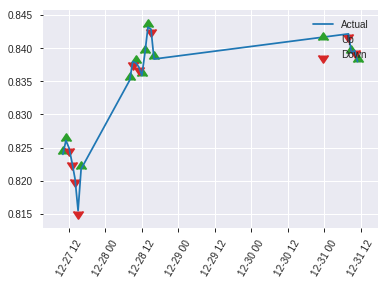


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1856921370791328
RMSE: 0.4309201052157265
LogLoss: 0.553479401004464
Mean Per-Class Error: 0.24108015640273706
AUC: 0.7956989247311829
pr_auc: 0.715780657247217
Gini: 0.5913978494623657
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4510062634944916: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      83   41   0.3306   (41.0/124.0)
1      15   84   0.1515   (15.0/99.0)
Total  98   125  0.2511   (56.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451006     0.75      124
max f2                       0.218393     0.834783  178
max f0point5                 0.524476     0.714286  102
max accuracy                 0.524476     0.748879  102
max precision                0.830526     1         0
max recall                   0.125445     1         218
max specificity              0.830526     1         0
max absolute_mcc             0.451006     0.518389  124
max min_per_class_accuracy   0.514153     0.747475  104
max mean_per_class_accuracy  0.451006     0.75892   124

Gains/Lift Table: Avg response rate: 44.39 %, avg score: 45.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.786611           2.25253   2.25253            1                0.801828  1                           0.801828            0.030303        0.030303                   125.253   125.253
    2        0.0224215                   0.768456           1.12626   1.80202            0.5              0.779455  0.8                         0.792879            0.010101        0.040404                   12.6263   80.202
    3        0.0313901                   0.75118            2.25253   1.93074            1                0.760543  0.857143                    0.78364             0.020202        0.0606061                  125.253   93.0736
    4        0.0403587                   0.736132           1.12626   1.75196            0.5              0.745606  0.777778                    0.775188            0.010101        0.0707071                  12.6263   75.1964
    5        0.0538117                   0.726384           2.25253   1.8771             1                0.730204  0.833333                    0.763942            0.030303        0.10101                    125.253   87.7104
    6        0.103139                    0.696109           2.04775   1.95872            0.909091         0.708105  0.869565                    0.737237            0.10101         0.20202                    104.775   95.8718
    7        0.152466                    0.66603            1.02388   1.65627            0.454545         0.680799  0.735294                    0.718978            0.0505051       0.252525                   2.38751   65.6269
    8        0.201794                    0.638006           1.84298   1.70191            0.818182         0.648863  0.755556                    0.701838            0.0909091       0.343434                   84.2975   70.1908
    9        0.300448                    0.592421           1.43343   1.61375            0.636364         0.620222  0.716418                    0.675039            0.141414        0.484848                   43.3425   61.3749
    10       0.399103                    0.553285           1.6382    1.61979            0.727273         0.574976  0.719101                    0.650304            0.161616        0.646465                   63.82     61.9793
    11       0.502242                    0.503225           1.17523   1.5285             0.521739         0.526885  0.678571                    0.624959            0.121212        0.767677                   17.5231   52.8499
    12       0.600897                    0.419911           1.12626   1.46246            0.5              0.453627  0.649254                    0.59683             0.111111        0.878788                   12.6263   46.246
    13       0.699552                    0.330893           0.307163  1.29953            0.136364         0.375257  0.576923                    0.565583            0.030303        0.909091                   -69.2837  29.9534
    14       0.798206                    0.221776           0.511938  1.20219            0.227273         0.267834  0.533708                    0.528782            0.0505051       0.959596                   -48.8062  20.219
    15       0.896861                    0.168872           0.204775  1.09247            0.0909091        0.18895   0.485                       0.491401            0.020202        0.979798                   -79.5225  9.24747
    16       1                           0.0939903          0.195872  1                  0.0869565        0.140876  0.443946                    0.455248            

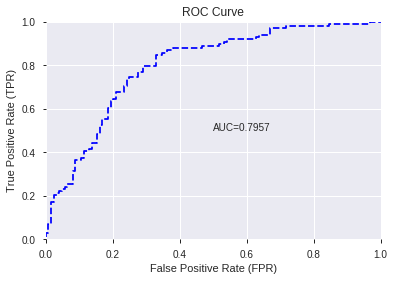

This function is available for GLM models only


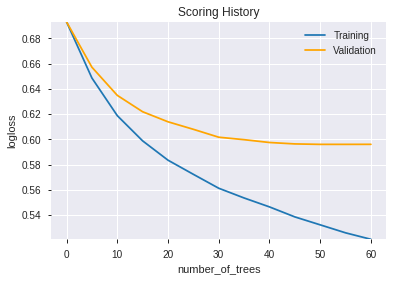

--2019-08-27 16:50:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

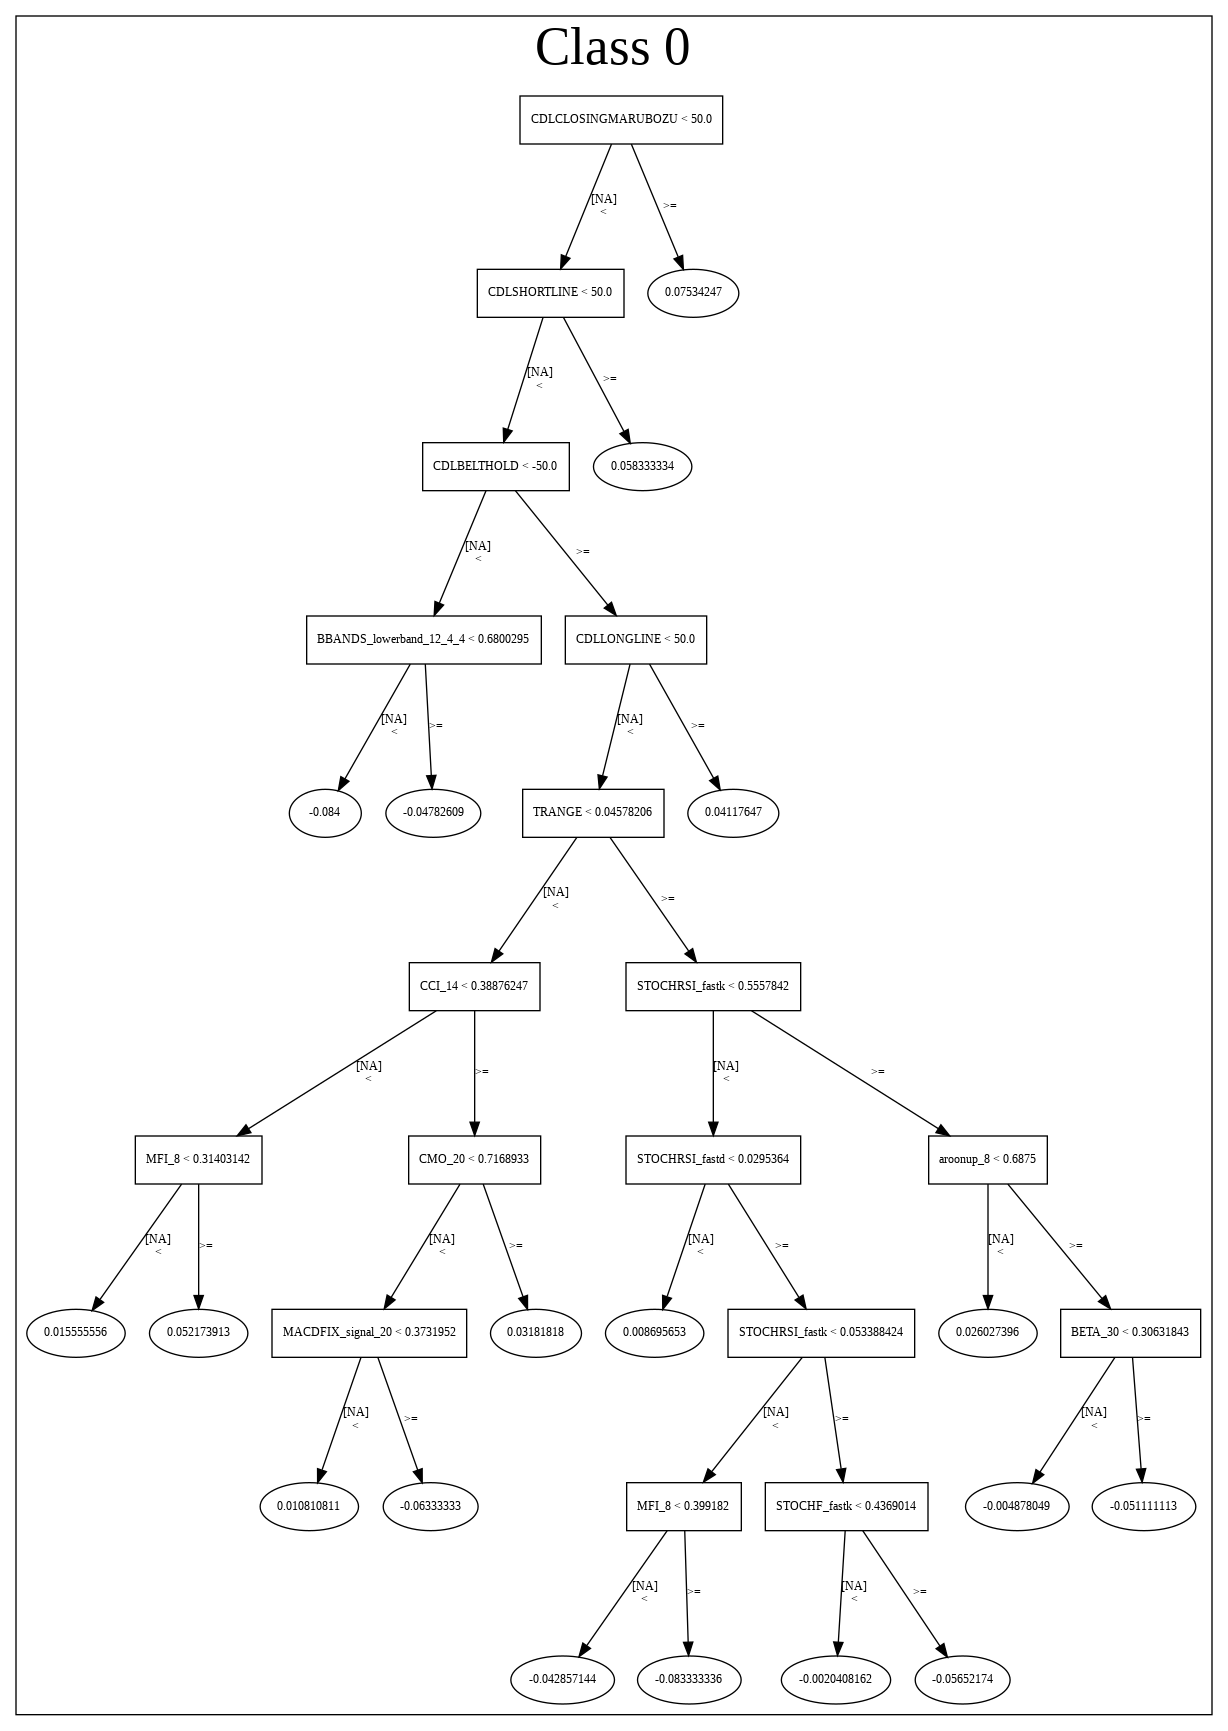

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_164949_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_164949_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_863b',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'ADOSC',
 'MFI_14',
 'STOCH_slowd',
 'ULTOSC',
 'DX_14',
 'OBV',
 'CMO_30',
 'MFI_24',
 'ADX_14',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'CCI_8',
 'PLUS_DI_20',
 'MACDFIX_hist_20',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'DX_30',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'CORREL_20',
 'MINUS_DI_8',
 'MFI_30',
 'aroondown_20',
 'BETA_8',
 'MOM_8',
 'MACDFIX_14',
 'DX_24',
 'PLUS_DM_24',
 'ATR_12',
 'CCI_20',
 'BETA_20',
 'WILLR_8',
 'NATR_12',
 'ADXR_12',
 'LINEARREG_ANGLE_8',
 'aroonup_14',
 'MINUS_DM_30',
 'PLUS_DI_24',
 'ATR_30',
 'aroonup_8',
 'WILLR_12',
 'MAVP_24_3',
 'ADXR_14',
 'aroonup_24',
 'aroonup_20',
 'MOM_14',
 'ATR_8',
 'STDDEV_14',
 'MACD',
 'ADXR_8',
 'ROCP_20',
 'NATR_24',
 'CMO_8',
 'CORREL_12',
 'ROCP_12',
 'WILLR_20',
 'CCI_14',
 'AROONOSC_24',
 'CDLBELTHOLD',
 'aroondown_30',
 'PLUS_DM_8',
 'MINUS_DI_24',
 'APO',
 'WILLR_24',
 'MFI_20',
 'BBANDS_upperband_20_1_3',
 'STOCH_slowk',
 'LINEARREG_14',
 'KAMA_20',
 'BBANDS_lowerband_30_1_4',
 'BBANDS_upperb

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.753
GLM             0.744
XGBoost         0.749
dtype: float64

DeepLearning    GLM  XGBoost
All          0.713  0.722    0.726
DLF          0.722  0.717    0.735
Fwe          0.753  0.744    0.722
RFE          0.749  0.744    0.749
XGBF         0.713  0.717    0.735





F1


DeepLearning    0.733
GLM             0.738
XGBoost         0.750
dtype: float64

DeepLearning    GLM  XGBoost
All          0.711  0.726    0.718
DLF          0.723  0.712    0.744
Fwe          0.721  0.734    0.718
RFE          0.733  0.738    0.750
XGBF         0.726  0.712    0.744





auc


DeepLearning    0.795
GLM             0.801
XGBoost         0.796
dtype: float64

DeepLearning    GLM  XGBoost
All          0.754  0.757    0.791
DLF          0.773  0.766    0.781
Fwe          0.795  0.801    0.790
RFE          0.767  0.790    0.796
XGBF         0.768  0.766    0.781





logloss


DeepLearning    0.871
GLM             0.590
XGBoost         0.560
dtype: float64

DeepLearning    GLM  XGBoost
All          0.871  0.590    0.555
DLF          0.598  0.585    0.560
Fwe          0.561  0.557    0.554
RFE          0.597  0.564    0.553
XGBF         0.593  0.585    0.560





mean_per_class_error


DeepLearning    0.287
GLM             0.278
XGBoost         0.270
dtype: float64

DeepLearning    GLM  XGBoost
All          0.287  0.267    0.270
DLF          0.268  0.278    0.253
Fwe          0.250  0.260    0.270
RFE          0.248  0.255    0.241
XGBF         0.272  0.278    0.253





rmse


DeepLearning    0.526
GLM             0.449
XGBoost         0.435
dtype: float64

DeepLearning    GLM  XGBoost
All          0.526  0.449    0.433
DLF          0.454  0.446    0.435
Fwe          0.435  0.430    0.433
RFE          0.451  0.433    0.431
XGBF         0.447  0.446    0.435





mse


DeepLearning    0.276
GLM             0.202
XGBoost         0.190
dtype: float64

DeepLearning    GLM  XGBoost
All          0.276  0.202    0.188
DLF          0.206  0.199    0.190
Fwe          0.189  0.185    0.188
RFE          0.204  0.188    0.186
XGBF         0.200  0.199    0.190

{'F1':       DeepLearning    GLM  XGBoost
 All          0.711    NaN      NaN
 DLF          0.723    NaN      NaN
 DLF            NaN  0.712      NaN
 DLF            NaN    NaN    0.744
 All            NaN  0.726      NaN
 All            NaN    NaN    0.718
 XGBF         0.726    NaN      NaN
 XGBF           NaN  0.712      NaN
 XGBF           NaN    NaN    0.744
 Fwe          0.721    NaN      NaN
 Fwe            NaN  0.734      NaN
 Fwe            NaN    NaN    0.718
 RFE          0.733    NaN      NaN
 RFE            NaN  0.738      NaN
 RFE            NaN    NaN    0.750,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.713    NaN      NaN
 DLF          0.722    NaN      NaN
 DLF            NaN  0.717      NaN
 DLF            NaN    NaN    0.735
 All            NaN  0.722      NaN
 All            NaN    NaN    0.726
 XGBF         0.713    NaN      NaN
 XGBF           NaN  0.717      NaN
 XGBF           NaN    NaN    0.735
 Fwe          0.753    NaN      NaN
 Fwe     